In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# First align the sequences against IGHC, then integrate this table with all_info
# And generate a new clones file (integration and creating new files in this script)
MYDIR = "./"

In [3]:
# Get list of files with aligned sequences (IGHC)
ighc_files = dict()
for myfile in os.listdir(MYDIR):
    if myfile.endswith("-IGHC_CH12_human-easy-import.txt"):
        mysample = myfile.split("_L001")[0]
        ighc_files[mysample] = myfile
ighc_files

{'IgSub1-3_S100': 'IgSub1-3_S100_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt',
 'IgSub2-3_S104': 'IgSub2-3_S104_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt',
 'IgSub3-3_S122': 'IgSub3-3_S122_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt',
 'IgSub4-3_S126': 'IgSub4-3_S126_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt',
 'IgSub5-3_S144': 'IgSub5-3_S144_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt',
 'IgSub6-3_S148': 'IgSub6-3_S148_L001.assembled-ACGTACGT-IGHC_CH12_human-easy-import.txt'}

In [4]:
# Retrieve the all_info.csv files
allinfo_files = dict()
for myfile in os.listdir(MYDIR):
    if myfile.endswith("HUMAN-all_info.csv"):
        mysample = myfile.split("_L001")[0]
        allinfo_files[mysample] = myfile
allinfo_files

{'IgSub1-3_S100': 'IgSub1-3_S100_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv',
 'IgSub2-3_S104': 'IgSub2-3_S104_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv',
 'IgSub3-3_S122': 'IgSub3-3_S122_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv',
 'IgSub4-3_S126': 'IgSub4-3_S126_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv',
 'IgSub5-3_S144': 'IgSub5-3_S144_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv',
 'IgSub6-3_S148': 'IgSub6-3_S148_L001.assembled-ACGTACGT-IGH_HUMAN-all_info.csv'}

In [5]:
# Retrieve the .sam.mut.txt files
sam_mut_files = dict()
for myfile in os.listdir(MYDIR):
    if myfile.endswith(".sam.mut.txt"):
        mysample = myfile.split("_L001")[0]
        sam_mut_files[mysample] = myfile
sam_mut_files

{'IgSub1-3_S100': 'IgSub1-3_S100_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt',
 'IgSub2-3_S104': 'IgSub2-3_S104_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt',
 'IgSub3-3_S122': 'IgSub3-3_S122_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt',
 'IgSub4-3_S126': 'IgSub4-3_S126_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt',
 'IgSub5-3_S144': 'IgSub5-3_S144_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt',
 'IgSub6-3_S148': 'IgSub6-3_S148_L001.assembled-ACGTACGT-IGHC_CH12_human-e-clean.sam.mut.txt'}

In [6]:
def integrateIghcAllinfo(sample, allinfo_files, ighc_files):
    # Read all_info and IGHC tables
    df_a = pd.read_csv(MYDIR + allinfo_files[sample], sep="\t", na_values=['None', ''])
    df_c = pd.read_csv(MYDIR + ighc_files[sample], sep="\t", header=None, na_values=['None', ''])
    df_c.columns = ['acc', 'bwa_flag', 'C_region']

    # Clean up the gene name from the alignment
    clean_name = lambda x: x.split("|")[1]
    df_c["C_region"] = [g for g in map(clean_name, df_c['C_region'])]

    # Filter on bwa_flag (should be 0 or 16)
    df_c = df_c.loc[(df_c['bwa_flag'] == 16) | (df_c['bwa_flag'] == 0)]

    # Merge the two tables
    df = pd.merge(df_a, df_c, how="left", on="acc")
    
    return(df)

In [7]:
def concat_jc_gene(genes):
    # Remove allele information
    genes = [str(g).split("*")[0] for g in genes]
    
    # Count unique genes
    values, counts = np.unique(genes, return_counts=True)
    d = dict(zip(values, counts))
    concatenated = list()
    for gene in sorted(d, key=d.get, reverse=True):
        concatenated.append(str(gene) + ":" + str(d[gene]))
    return(",".join(concatenated))

In [8]:
def create_clones(df):
    # Apply filter to all info
    df = df.loc[(df['cdr3_qual_min'] >= 30) & (pd.isna(df['V_sub']) == False) & (pd.isna(df['J_sub']) == False) & ((df['V_flag'] == 0) | (df['V_flag'] == 16)) & ((df['J_flag'] == 0) | (df['J_flag'] == 16))]
    
    # Now group it into clones
    select = ['cdr3pep', 'V_sub', 'J_sub', 'C_region', 'acc', 'beforeMID', 'cdr3nuc']
    cols = ['cdr3pep', 'V_sub']
    clones = df[select].groupby(cols).agg({'J_sub': concat_jc_gene, 'C_region': concat_jc_gene, 'beforeMID': 'nunique', 'acc': 'nunique'})
    clones = clones.sort_values(by='beforeMID', ascending=False)
    clones = clones.reset_index()
    
    return(clones)

In [9]:
for sample in list(ighc_files.keys()):
    df = integrateIghcAllinfo(sample, allinfo_files, ighc_files)
    allinfonew = allinfo_files[sample].replace("-all_info.csv", "-ighc-all_info.csv")
    df.to_csv(MYDIR + allinfonew, sep="\t", index=False)
    print("Wrote", MYDIR + allinfonew, "to disk")

    clones = create_clones(df)
    clonesnew = allinfo_files[sample].replace("-all_info.csv", "-ighc-clones.csv")
    clones.to_csv(MYDIR + clonesnew, sep="\t", index=False)
    print("Wrote", MYDIR + clonesnew, "to disk")

Wrote ./IgSub5-3_S144_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub5-3_S144_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk
Wrote ./IgSub4-3_S126_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub4-3_S126_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk
Wrote ./IgSub6-3_S148_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub6-3_S148_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk
Wrote ./IgSub2-3_S104_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub2-3_S104_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk
Wrote ./IgSub3-3_S122_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub3-3_S122_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk
Wrote ./IgSub1-3_S100_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-all_info.csv to disk
Wrote ./IgSub1-3_S100_L001.assembled-ACGTACGT-IGH_HUMAN-ighc-clones.csv to disk


## Get the variant positions

In [14]:
def getVariants(gene, pos, seq):
    variants = dict()
    if pos < 250: # do not trust alignments that start earlier than position 250
        return(variants)
    for i, s in enumerate(seq):
        if s != "=":
            variants[i] = s
    return(variants)
test_df = pd.DataFrame({"gene": ["A", "B"], "start.pos": [50, 300], "align.seq": ["=====A====C==", "=====A====C=="]})
list(map(getVariants, test_df["gene"], test_df["start.pos"], test_df["align.seq"]))

[{}, {5: 'A', 10: 'C'}]

In [15]:
def plotVariants(sam_mut, gene, sample):

    # Select gene from the dataframe
    sam_mut = sam_mut[sam_mut["gene"] == gene]
    
    # Get variants
    count_variants = dict()
    for d in map(getVariants, sam_mut["gene"], sam_mut["start.pos"], sam_mut["align.seq"]):
        for pos, nuc in d.items():
            count_variants[(pos, nuc)] = count_variants.get((pos, nuc), 0) + 1

    # Put variants in a dataframe
    positions = list()
    nucleotides = list()
    counts = list()
    all_pos = list(range(0,145))
    for pos, nuc in count_variants:
        positions.append(pos)
        nucleotides.append(nuc)
        counts.append(count_variants[(pos, nuc)])
        if pos in all_pos:
            all_pos.remove(pos)
    for my_dummy_pos in all_pos:  # add count=0 to positions without a variant
        positions.append(my_dummy_pos)
        nucleotides.append("x")
        counts.append(0)
        
    variants = pd.DataFrame({"pos": positions, "nuc": nucleotides, "counts": counts})

    # Make a stacked bar graph of variants. Example code: https://pstblog.com/2016/10/04/stacked-charts
    pivot_df = variants.pivot(index='pos', columns='nuc', values='counts')
    colors = ["green", "blue", "orange", "red"]
    if len(pivot_df) < 1:   # Skip empty dataframes
        return
    pivot_df.plot.bar(stacked=True, color=colors, figsize=(20,7), title=sample + " - " + gene)
    return(variants)

Sample: IgSub5-3_S144


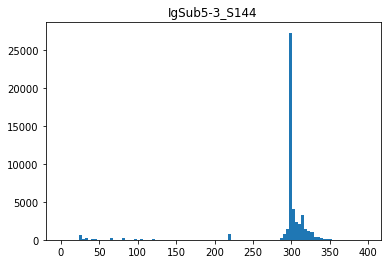

/home/barbera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sample: IgSub4-3_S126


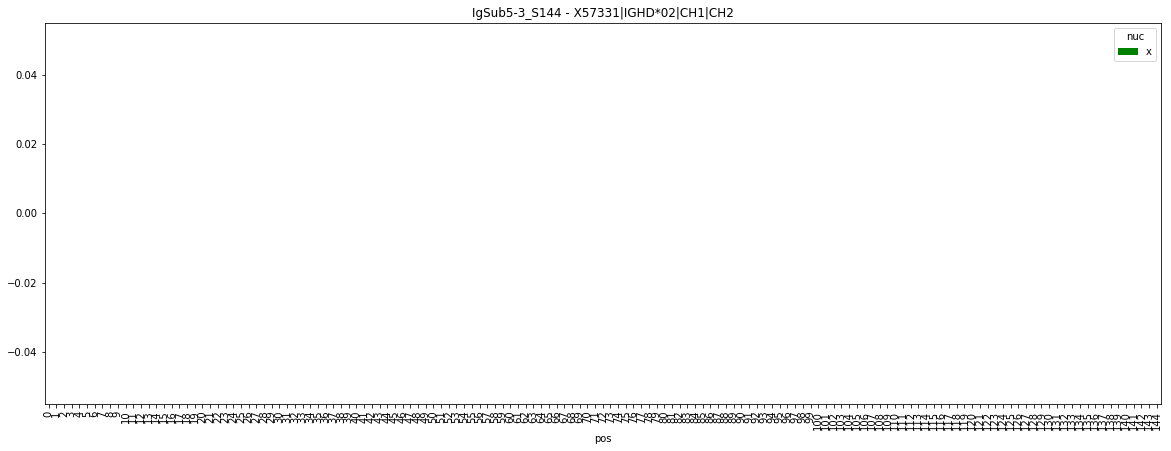

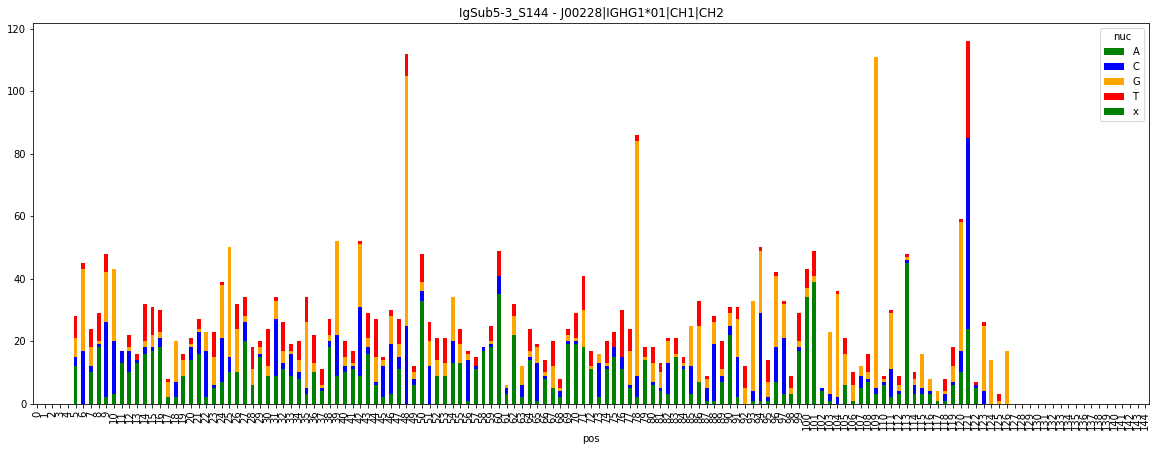

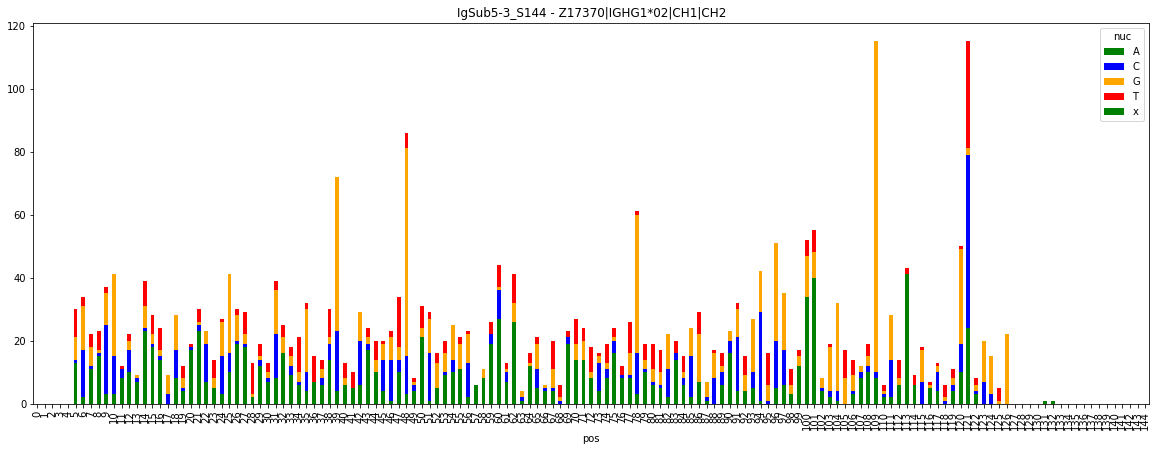

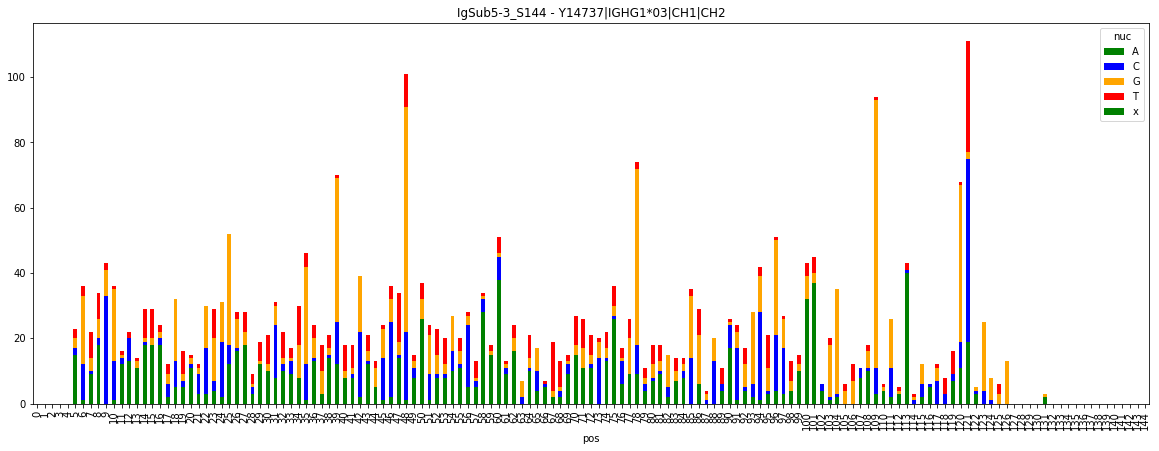

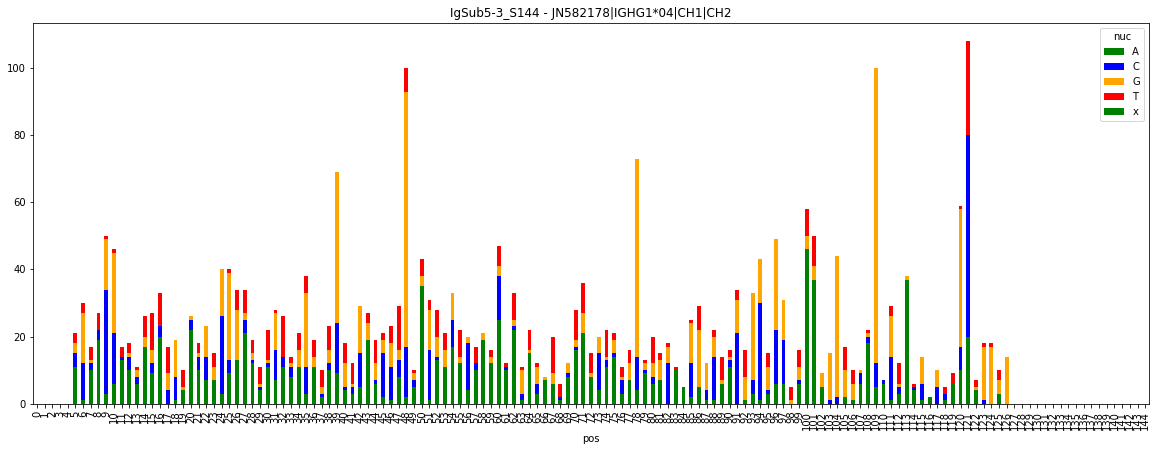

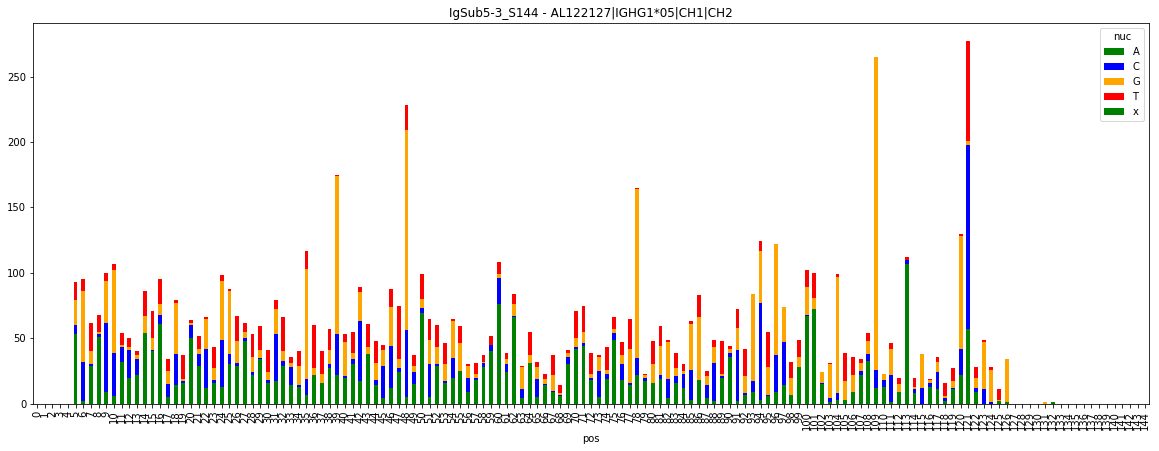

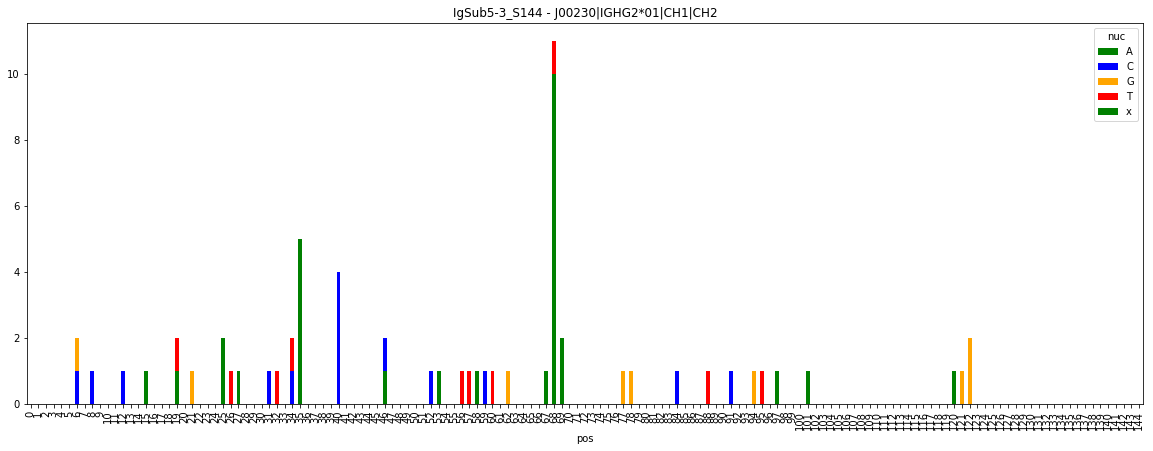

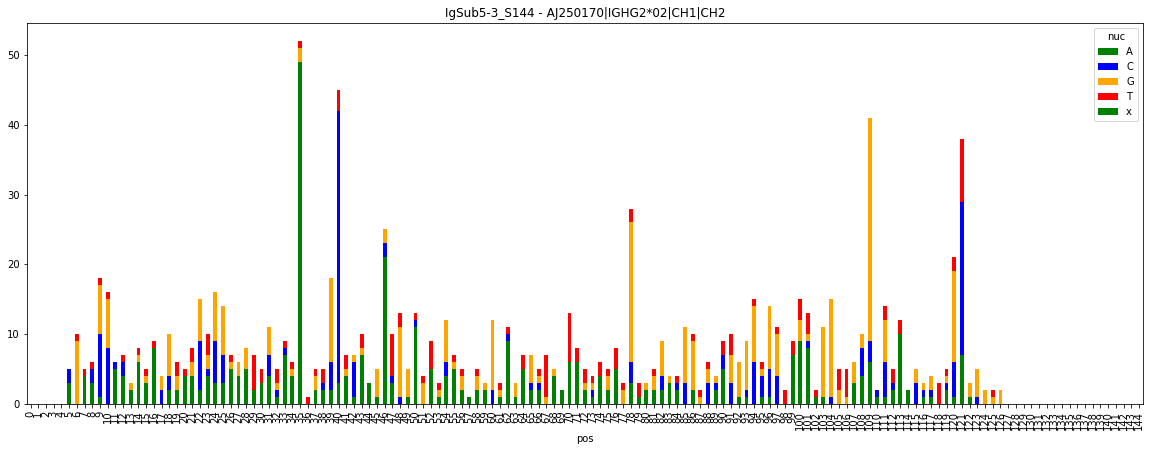

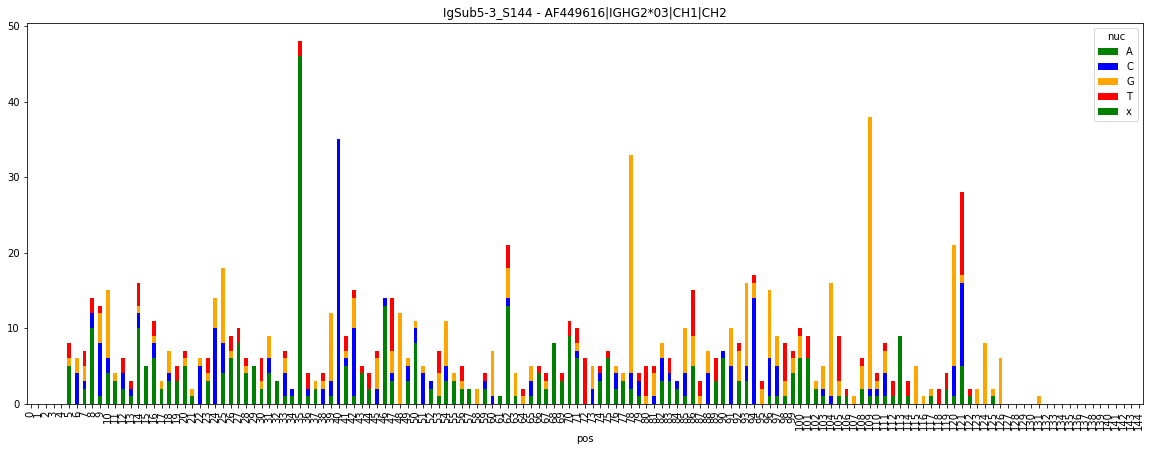

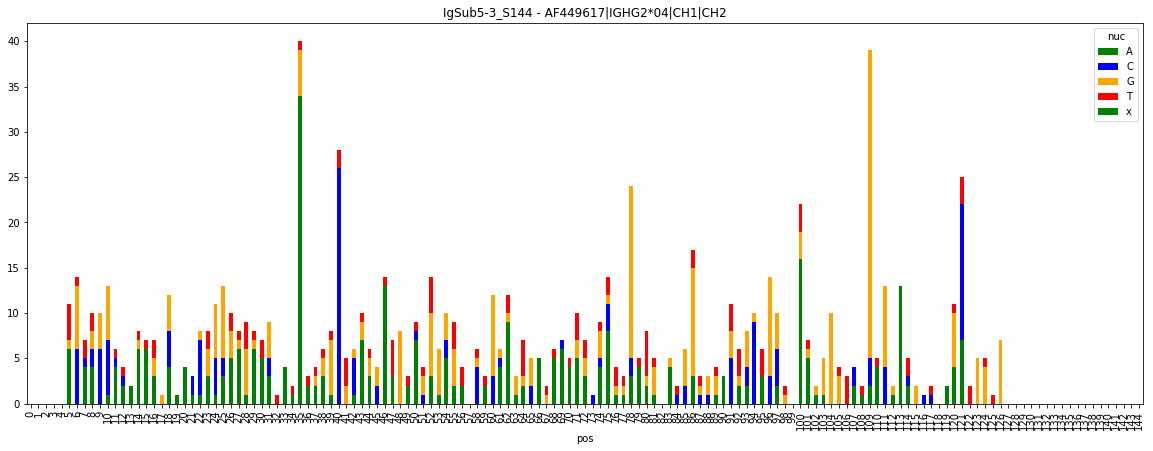

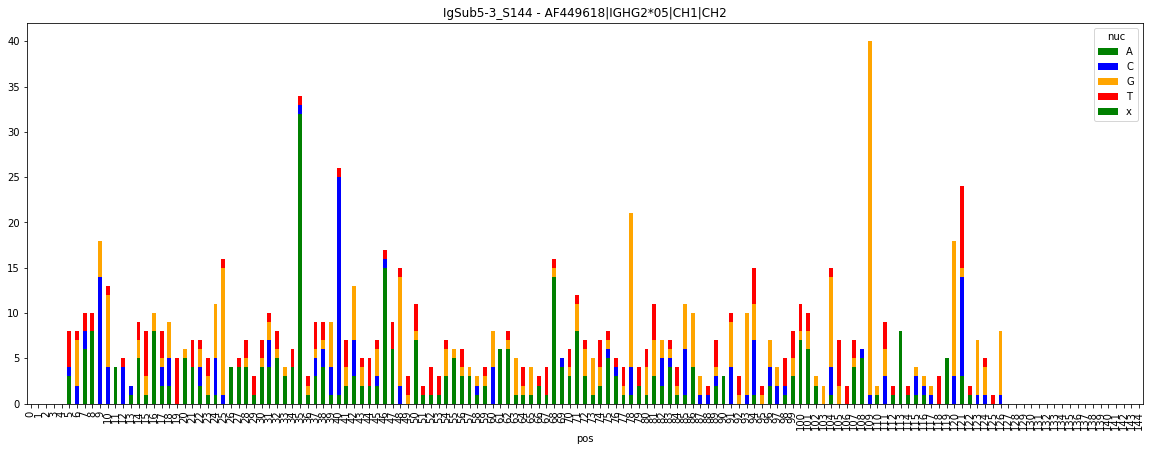

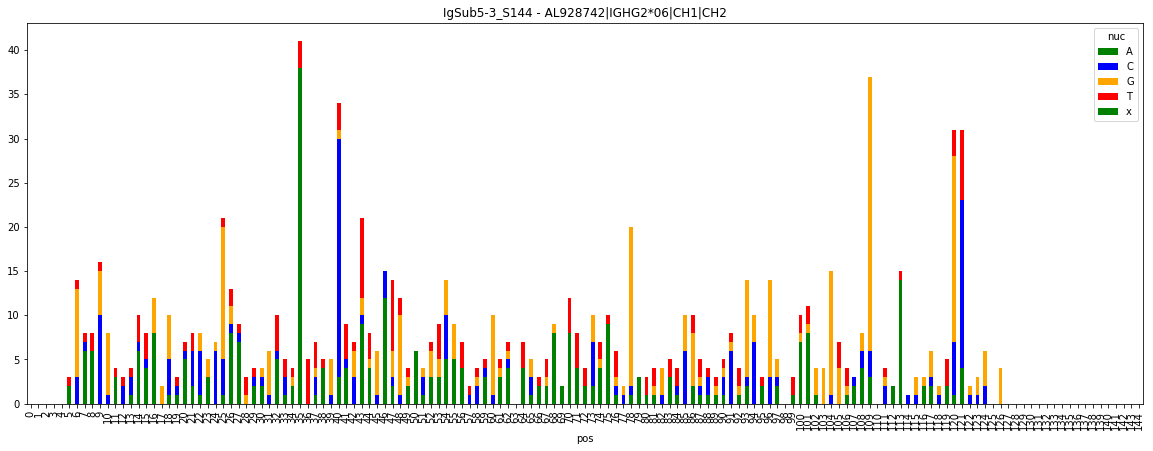

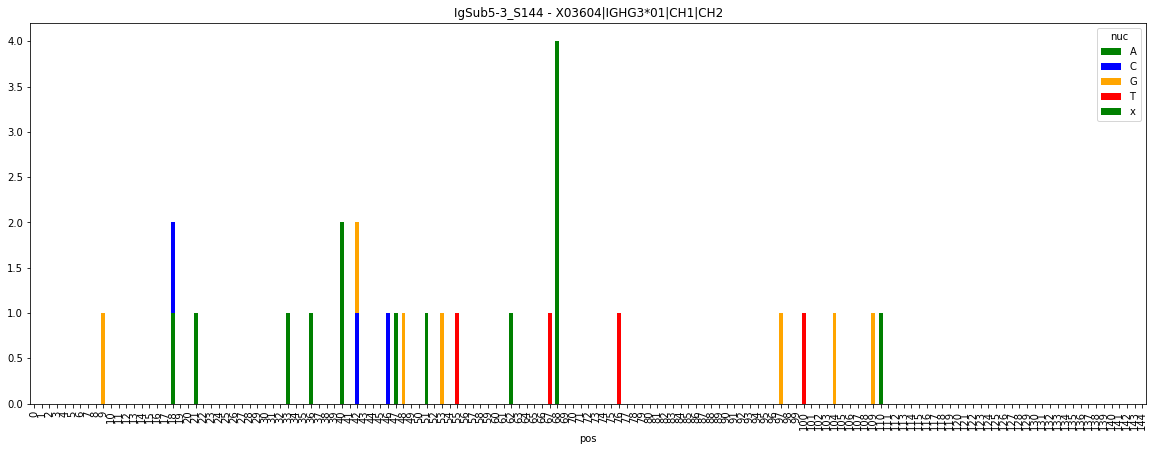

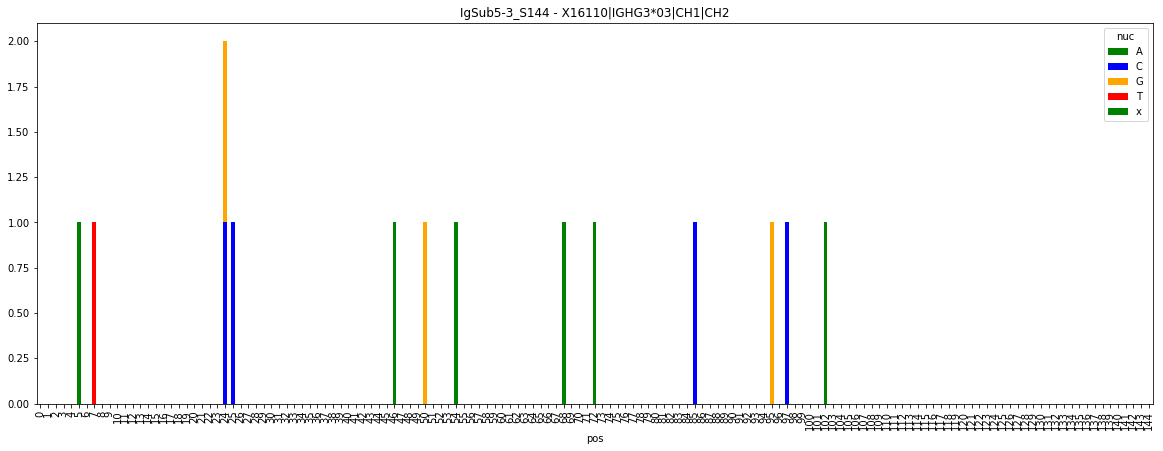

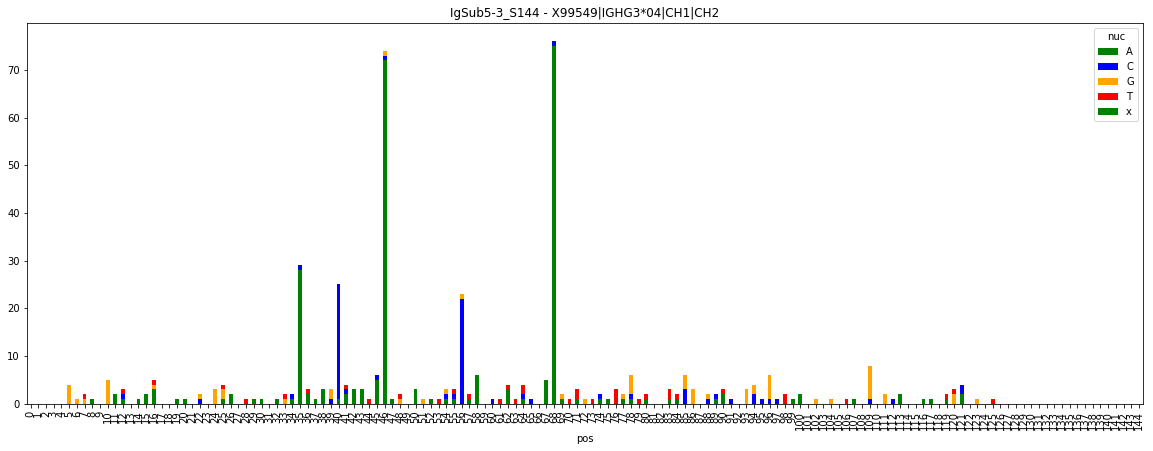

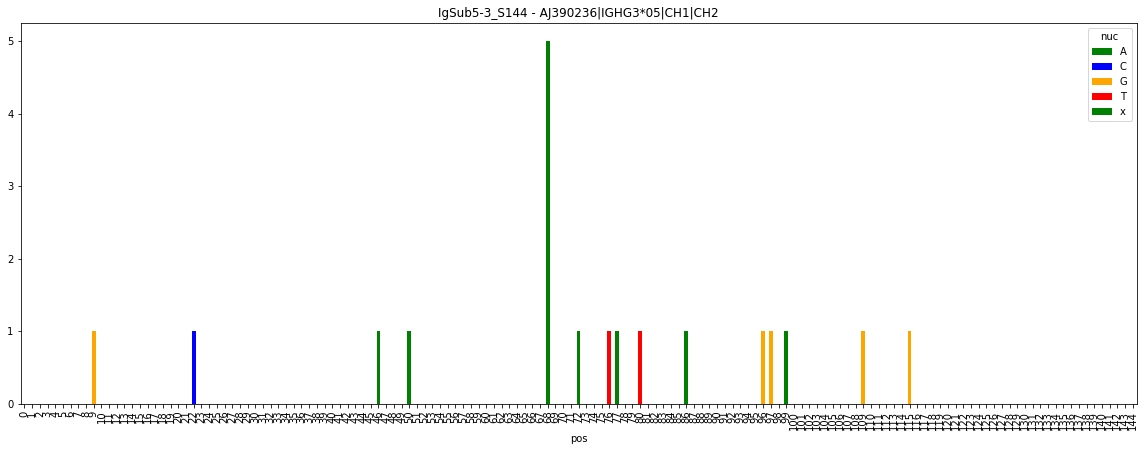

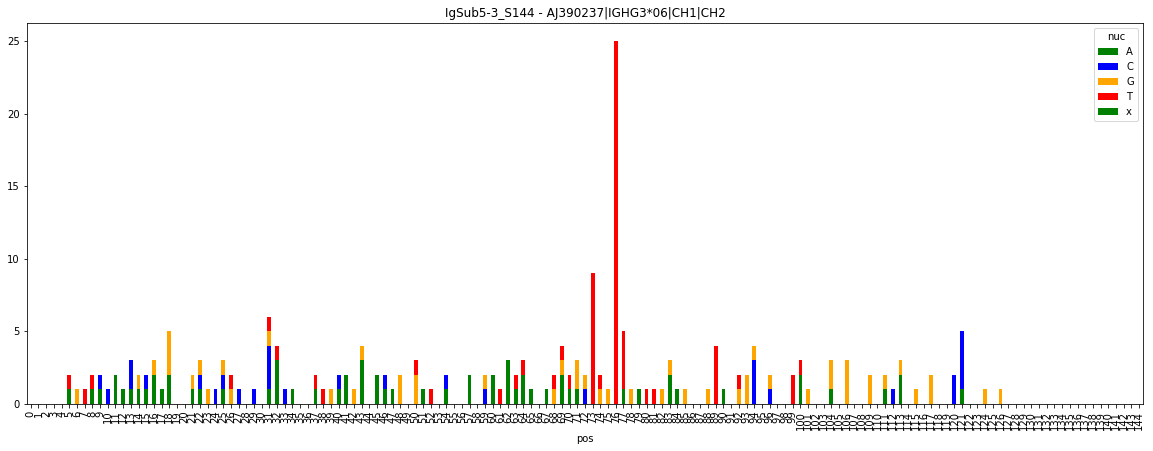

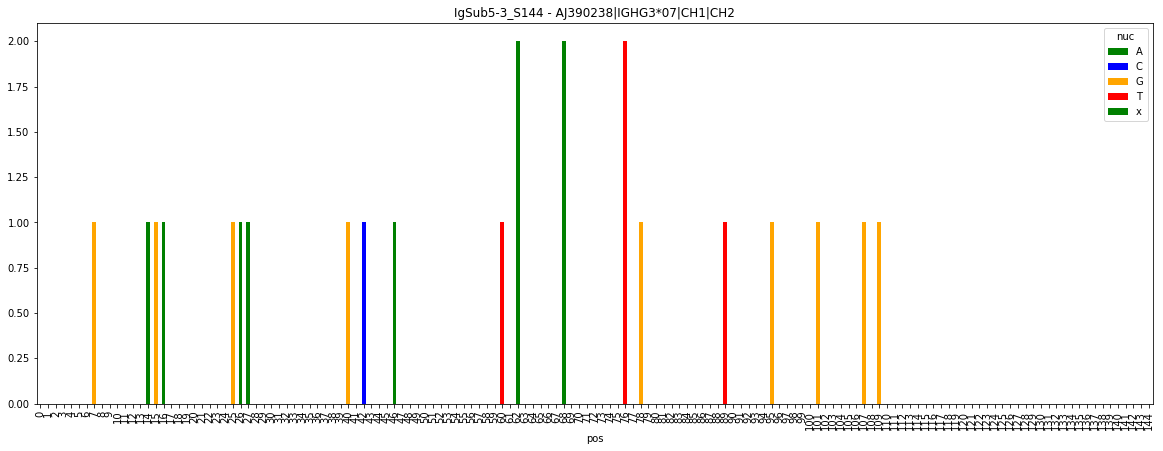

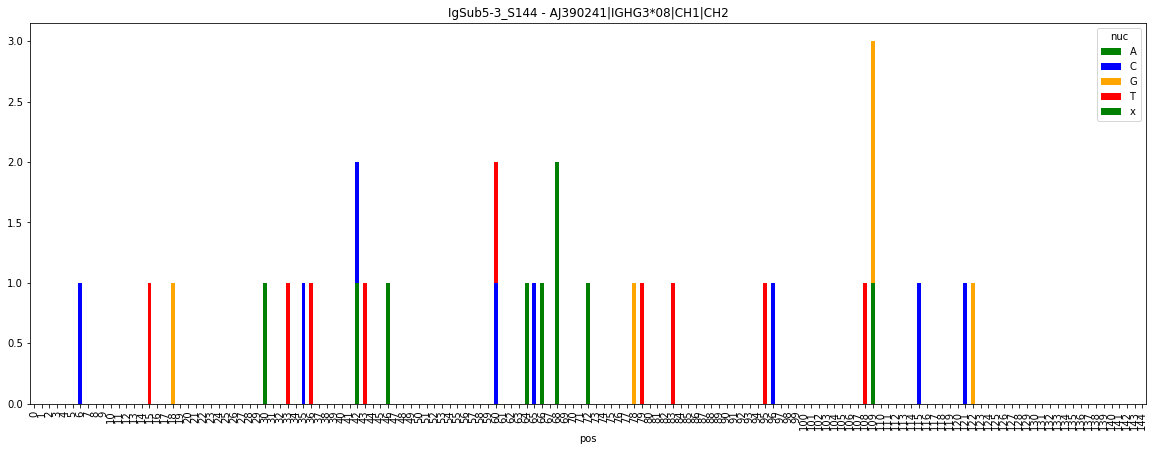

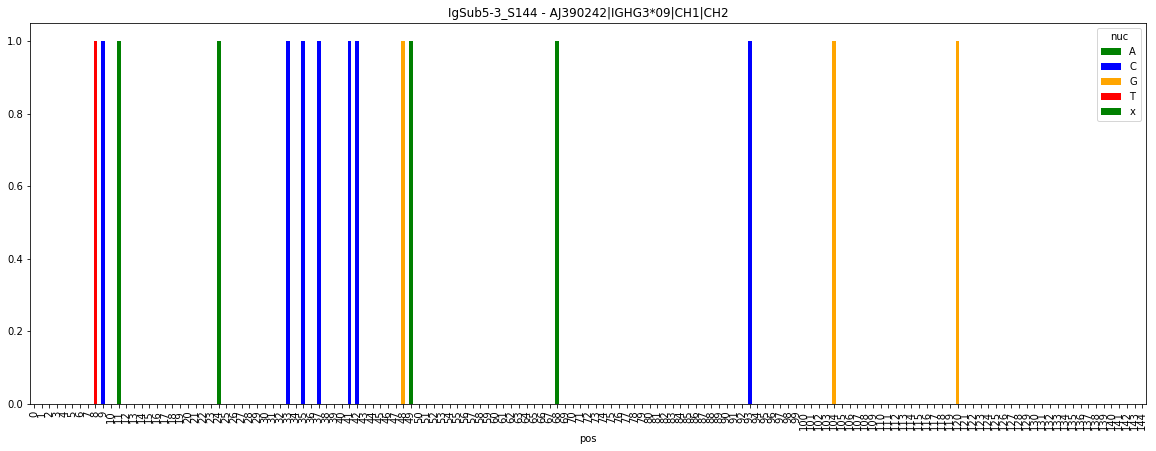

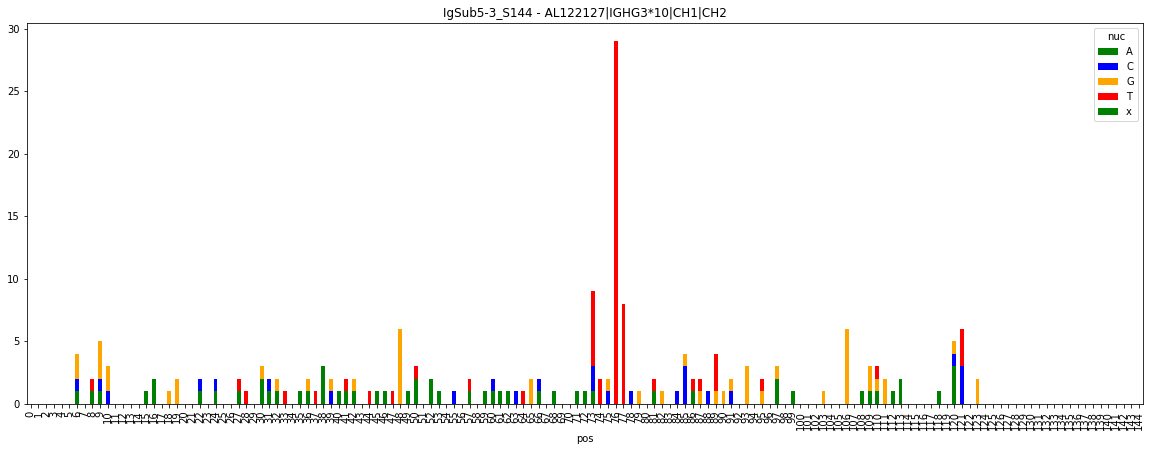

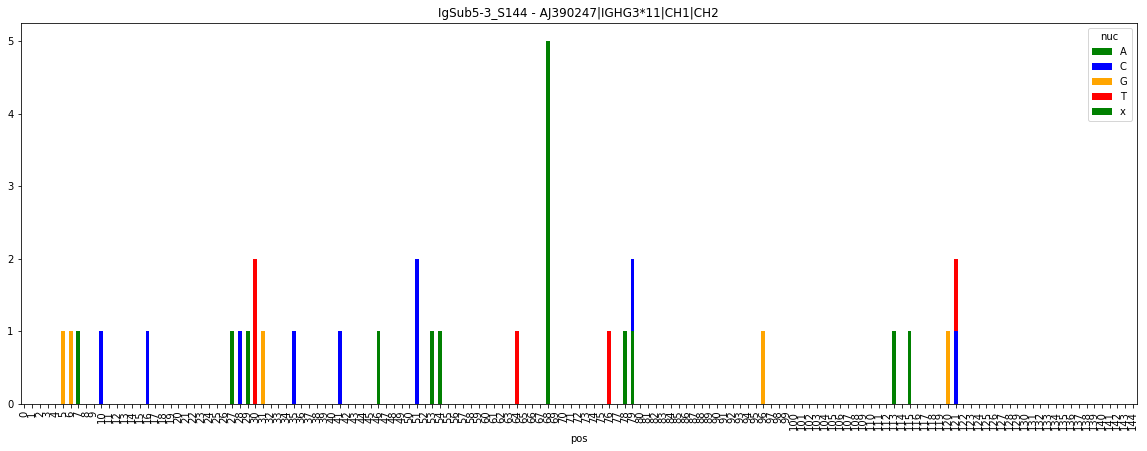

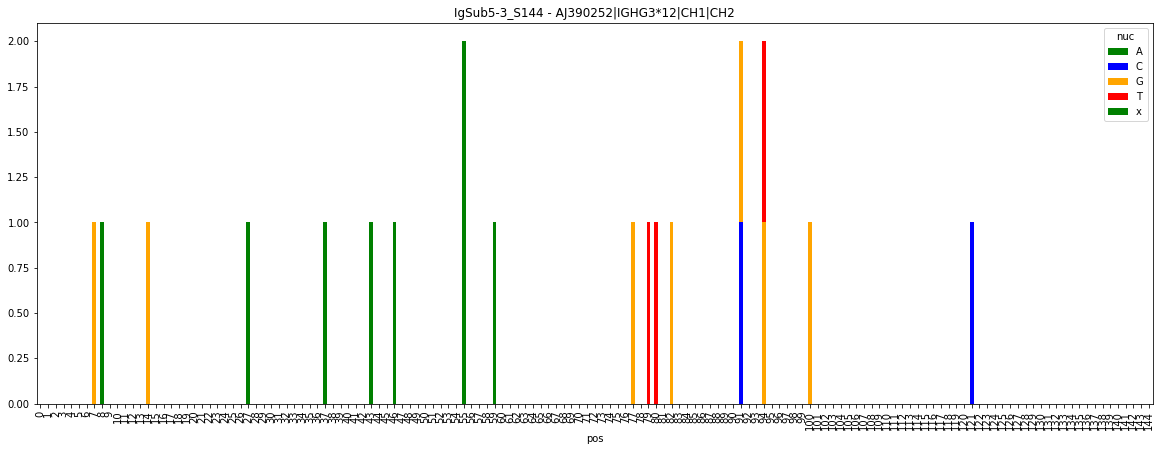

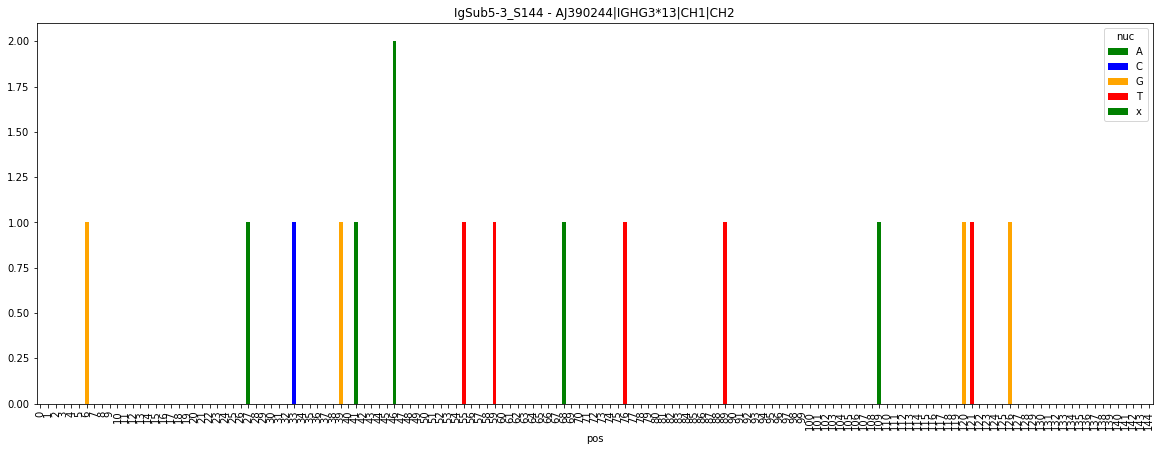

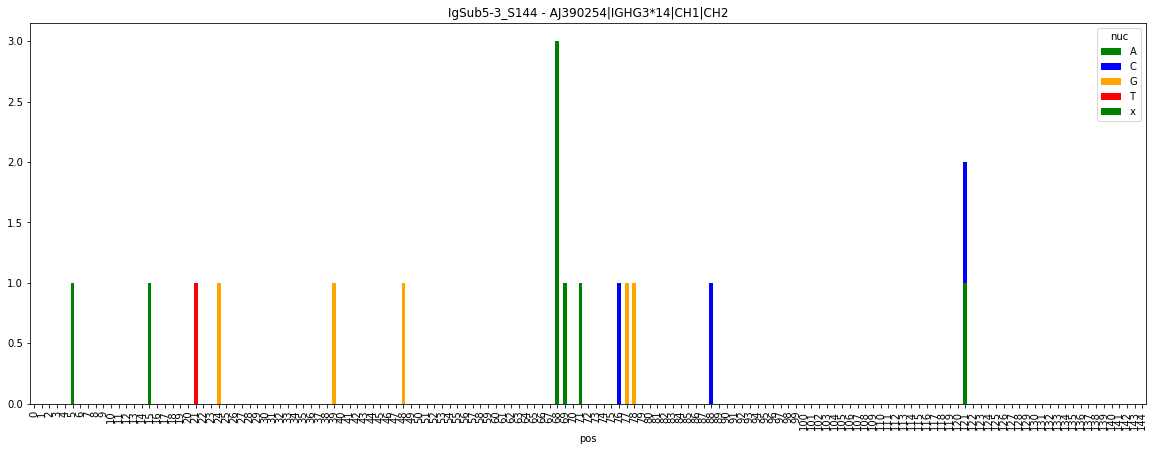

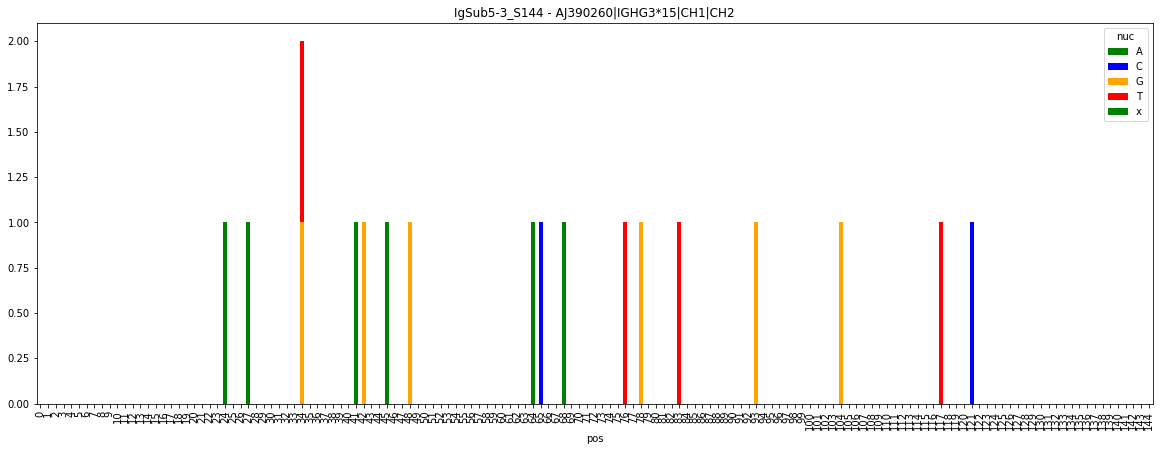

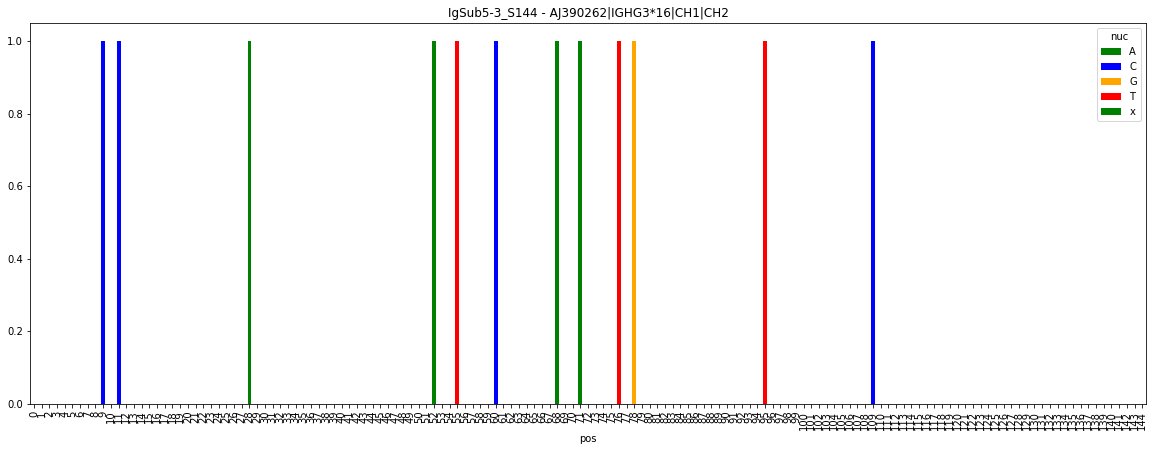

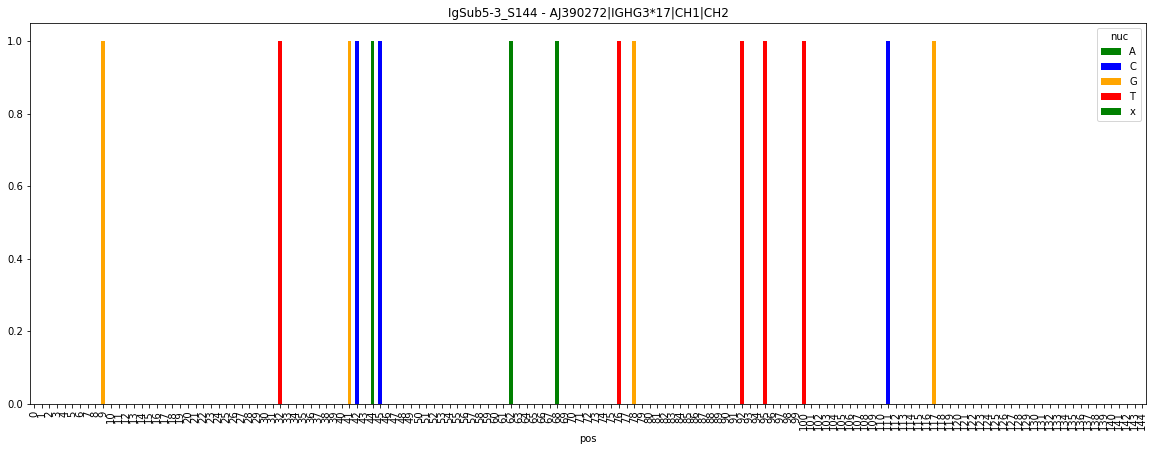

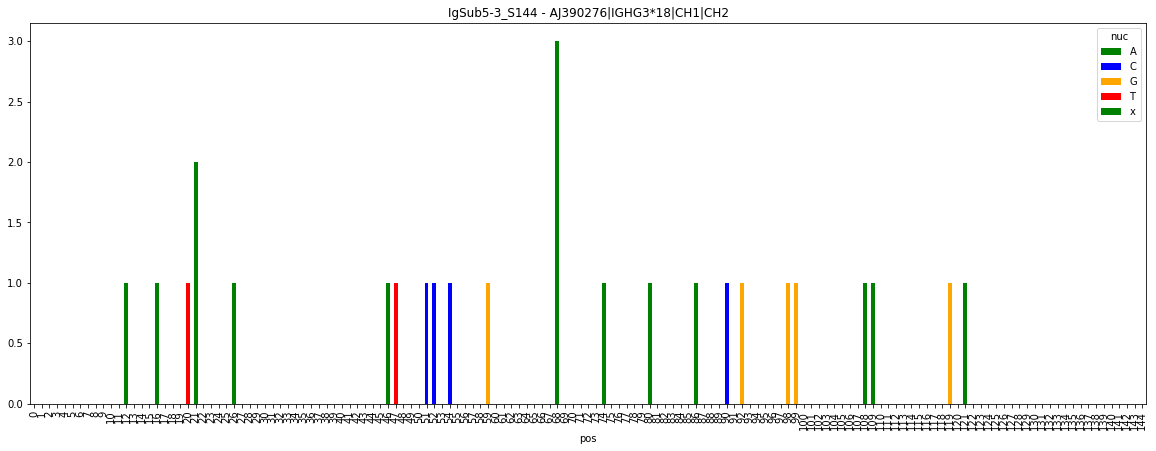

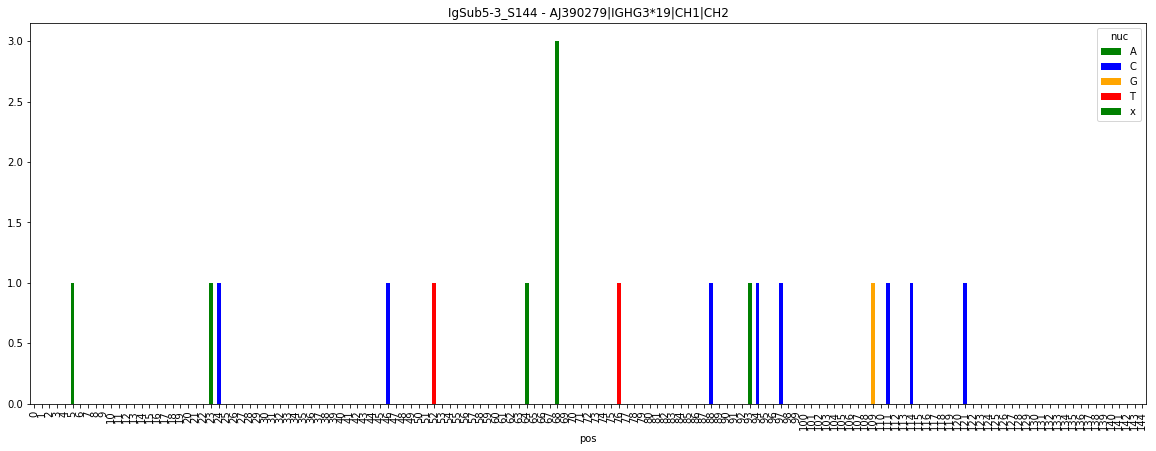

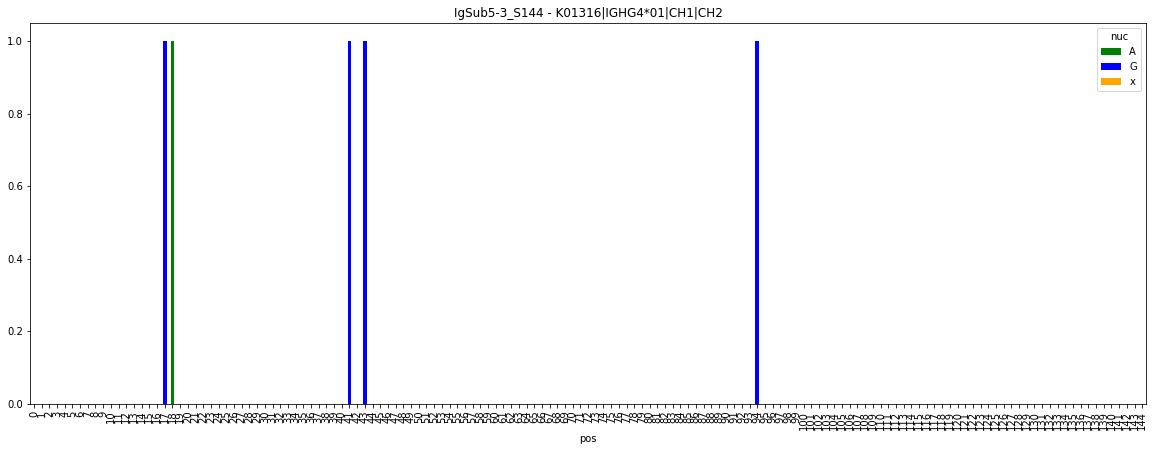

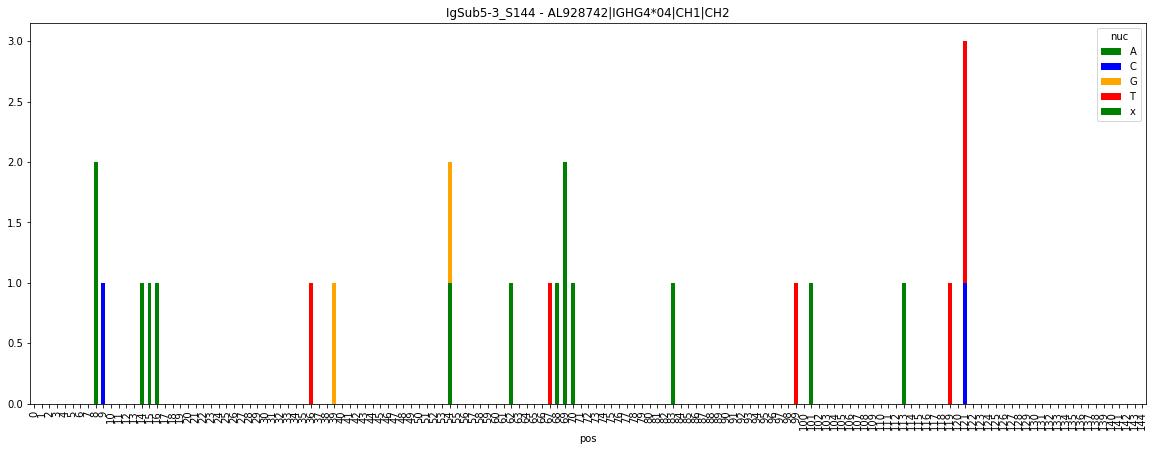

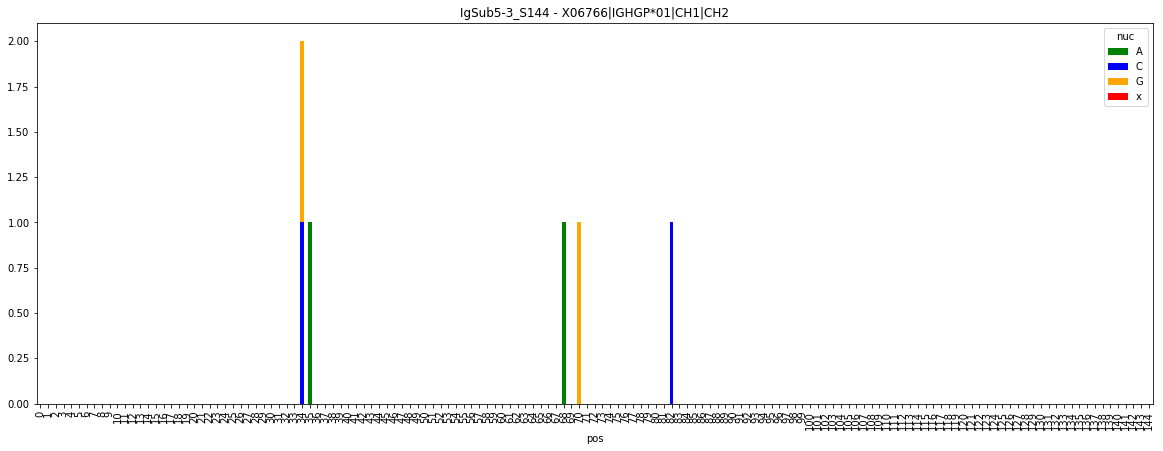

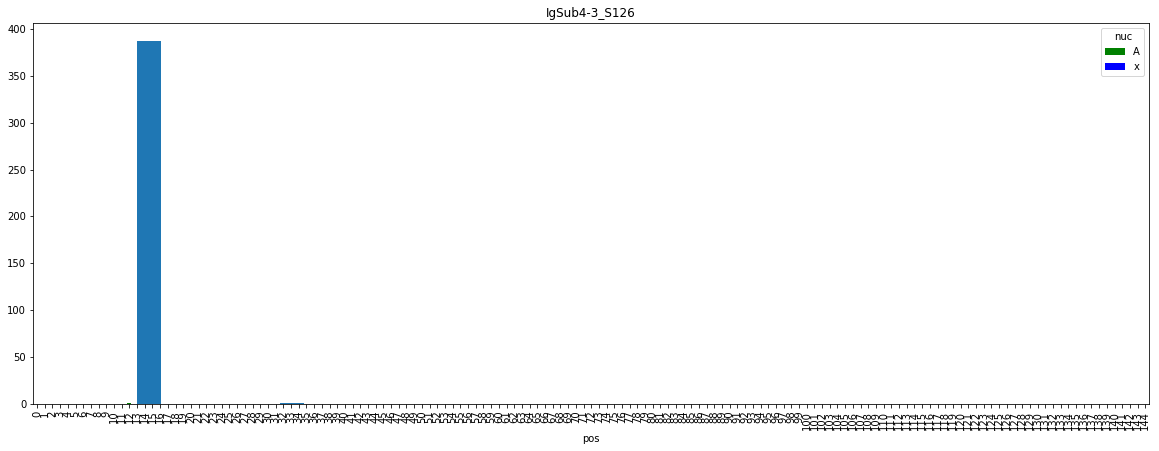

Sample: IgSub6-3_S148


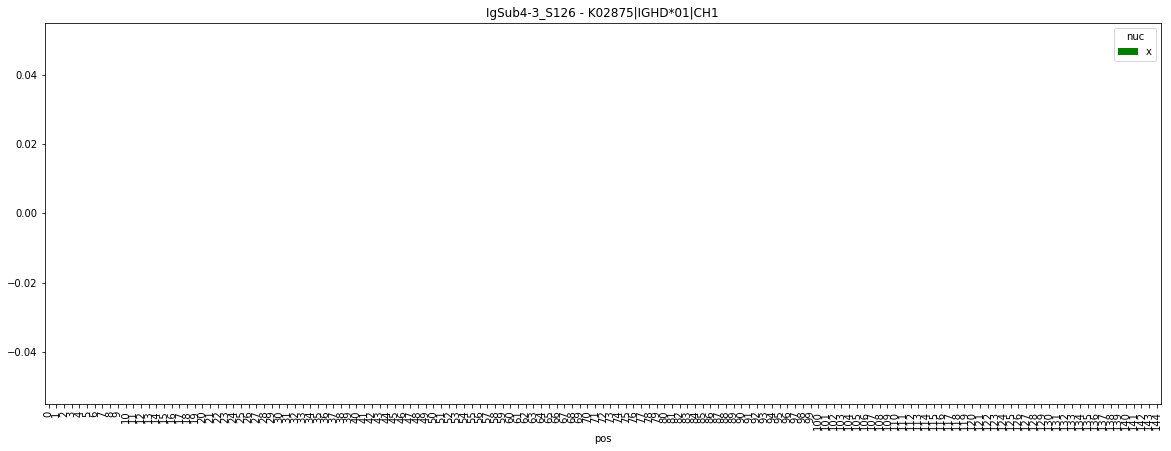

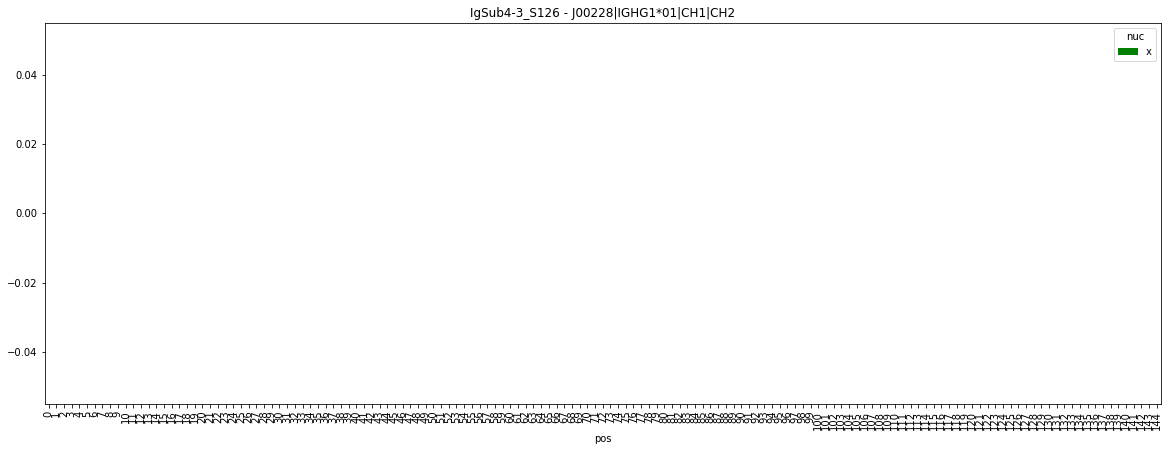

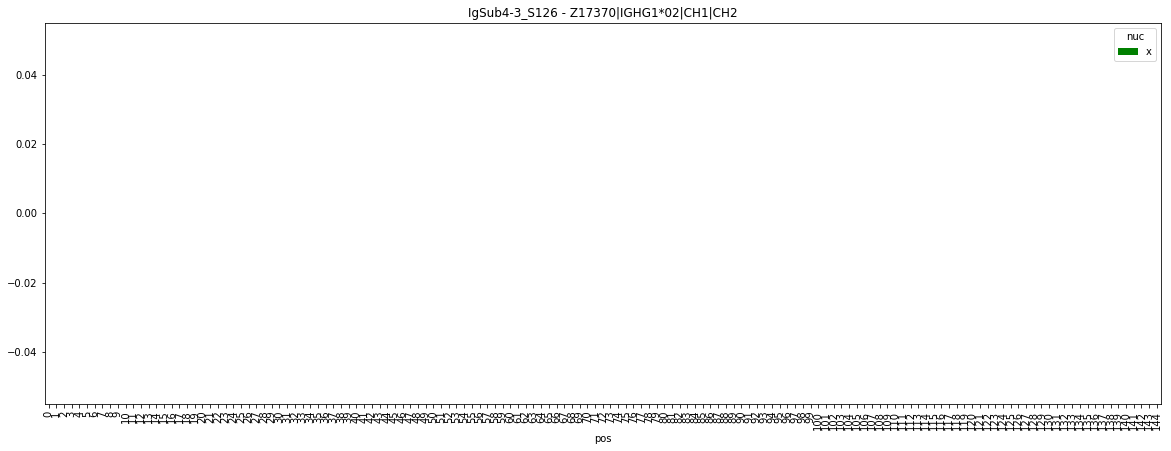

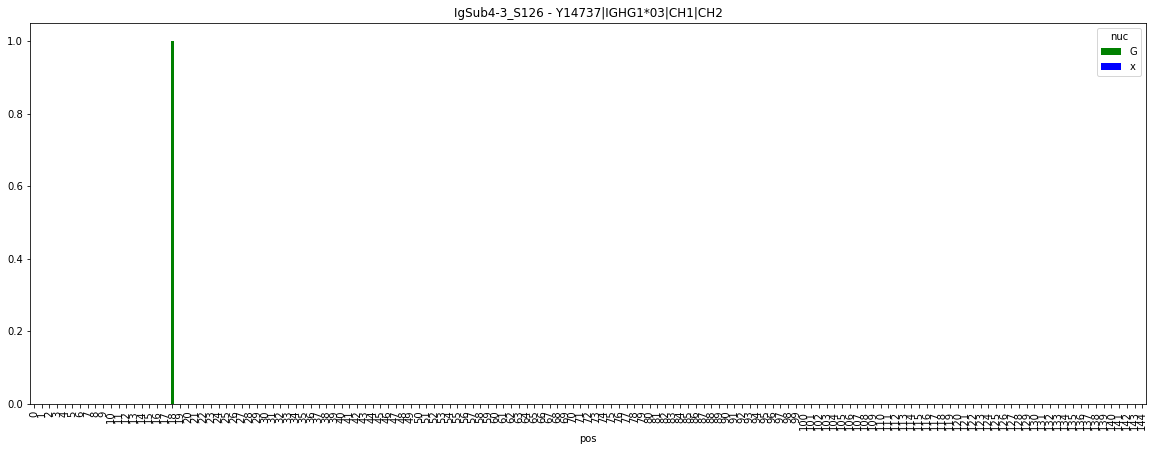

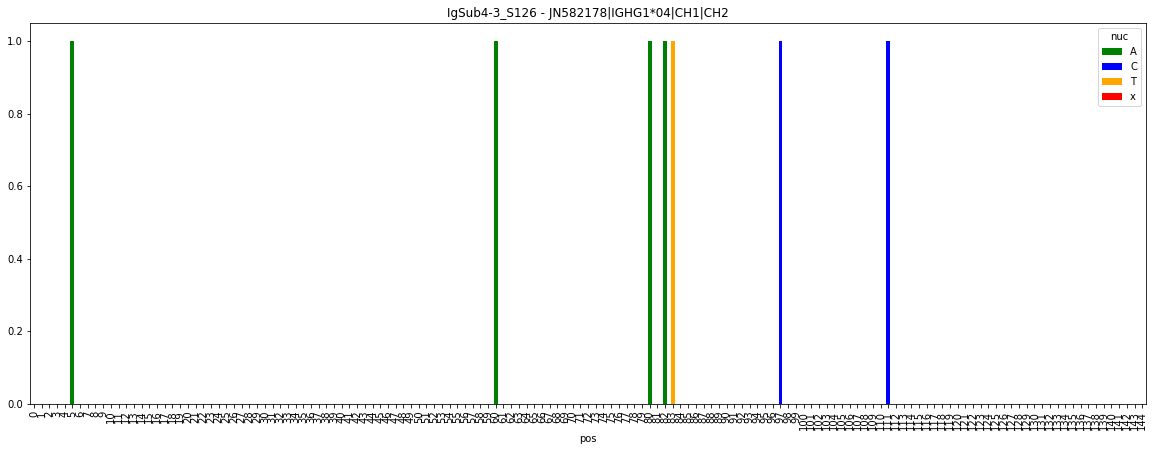

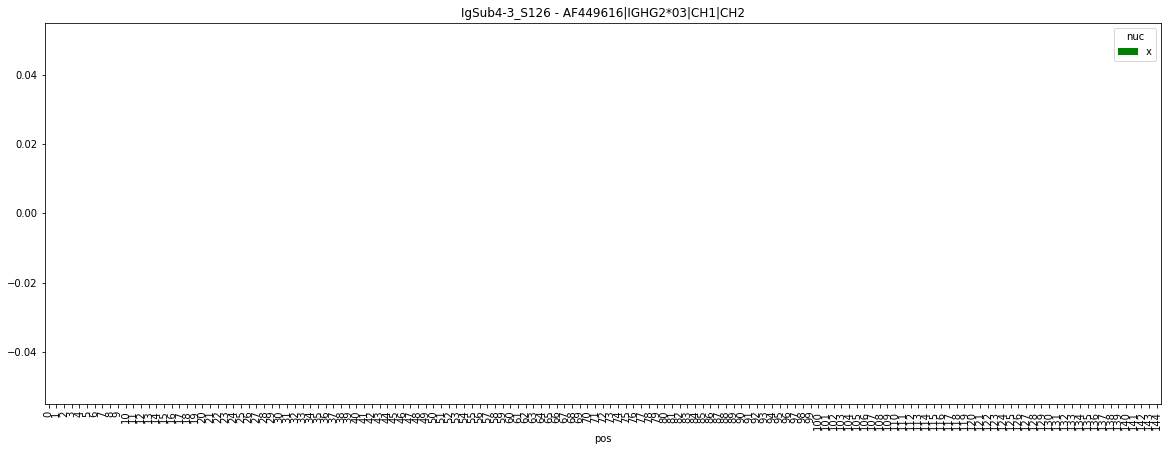

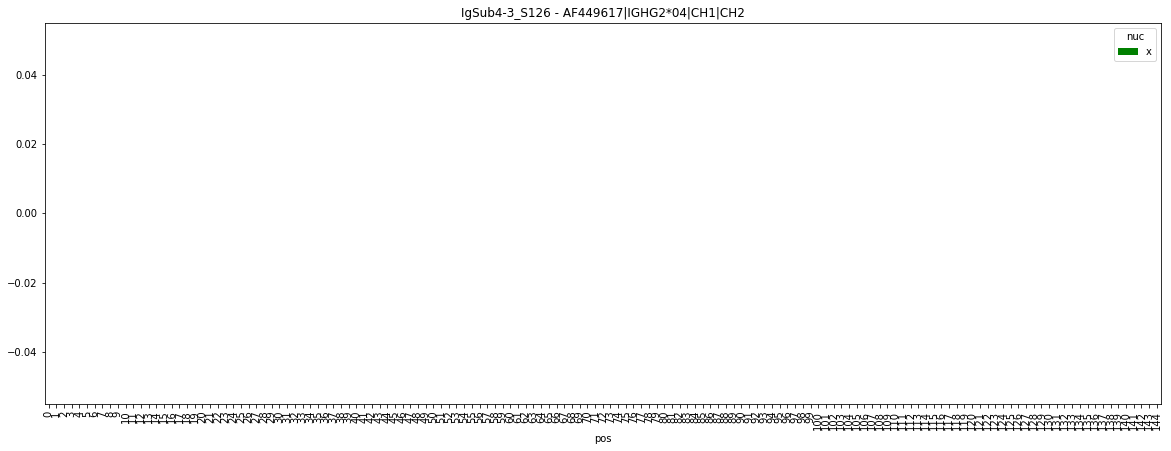

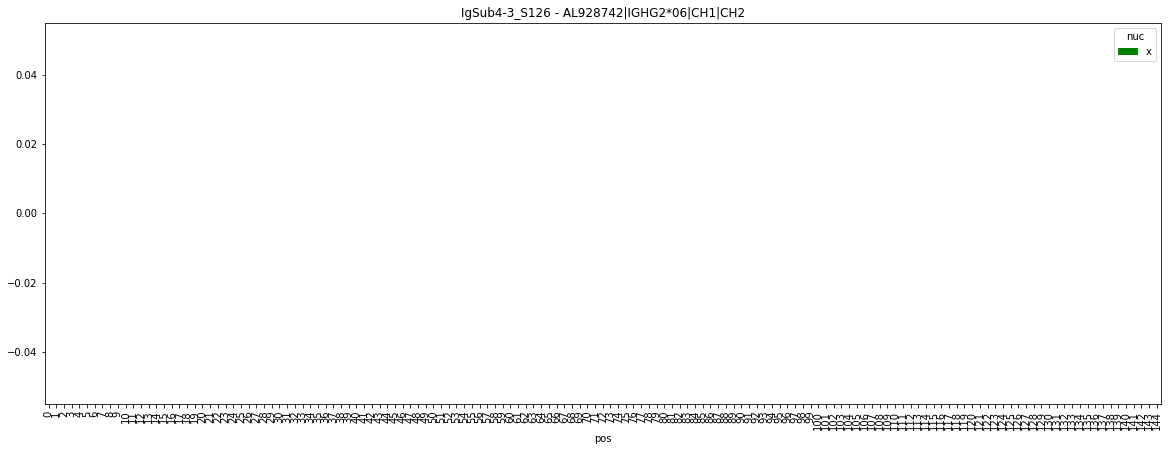

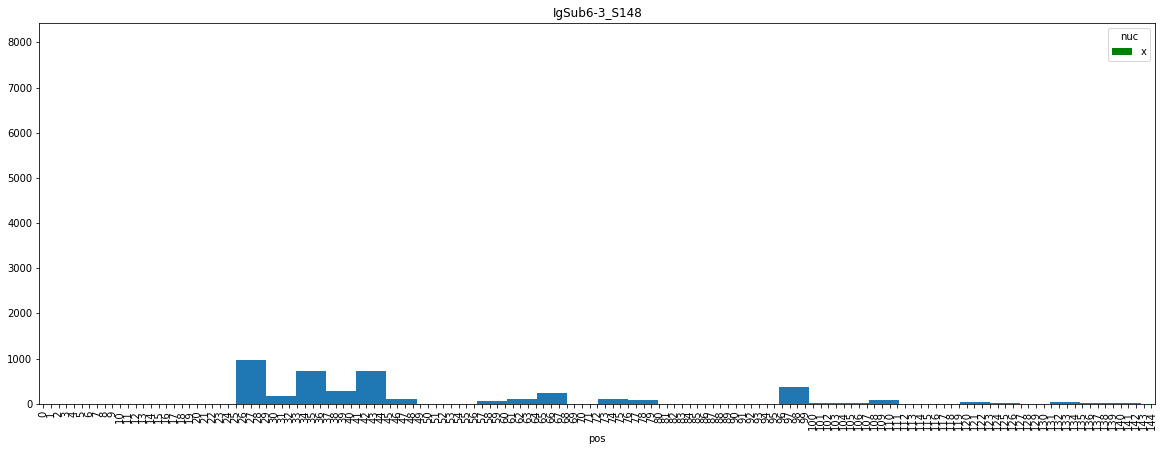

Sample: IgSub2-3_S104


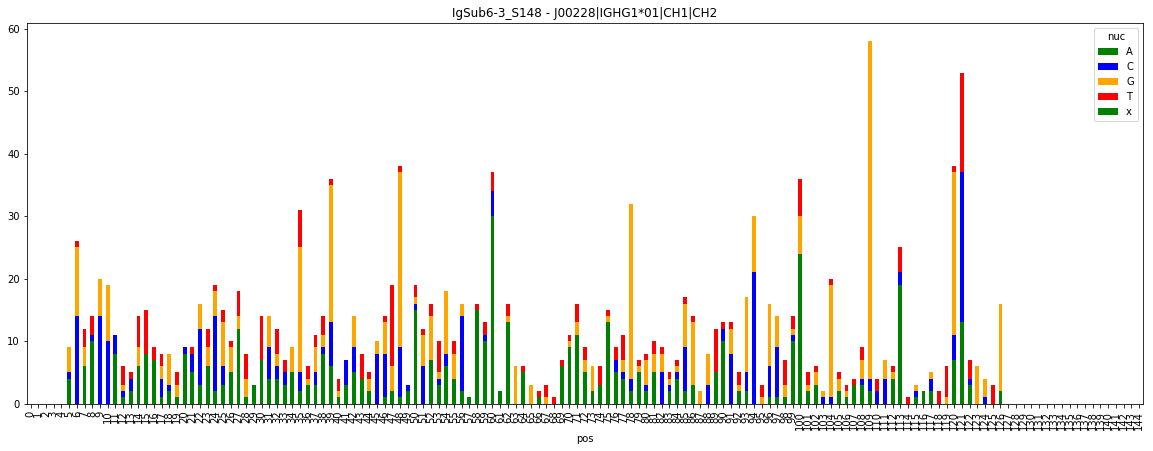

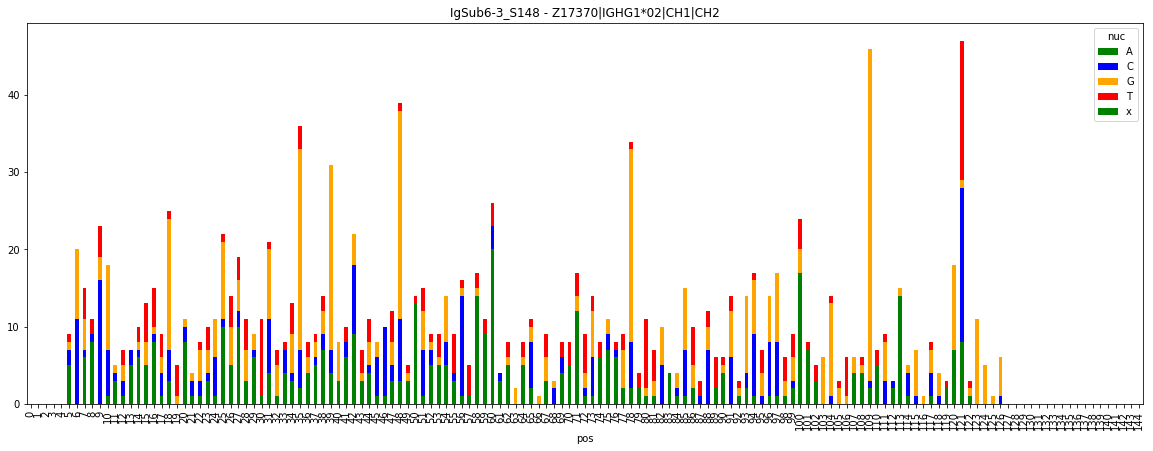

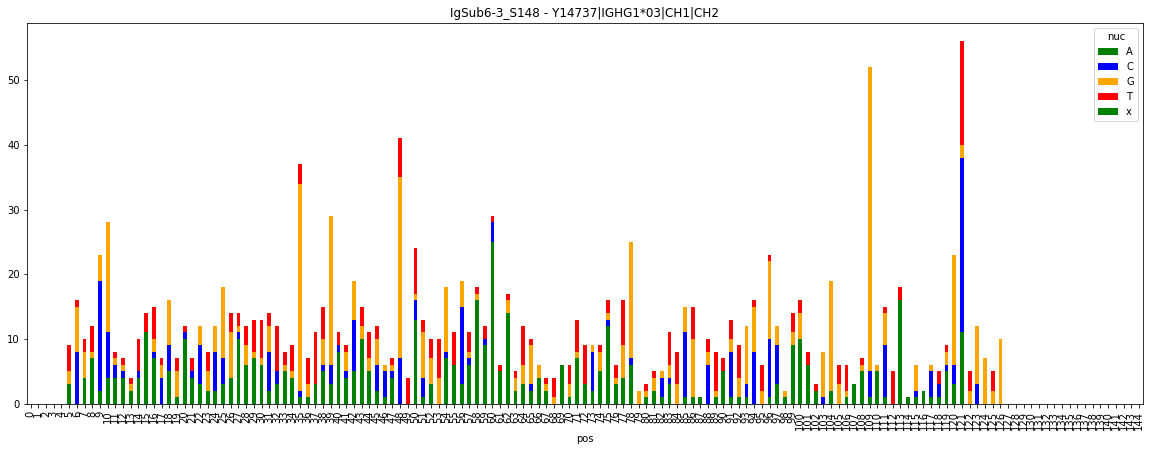

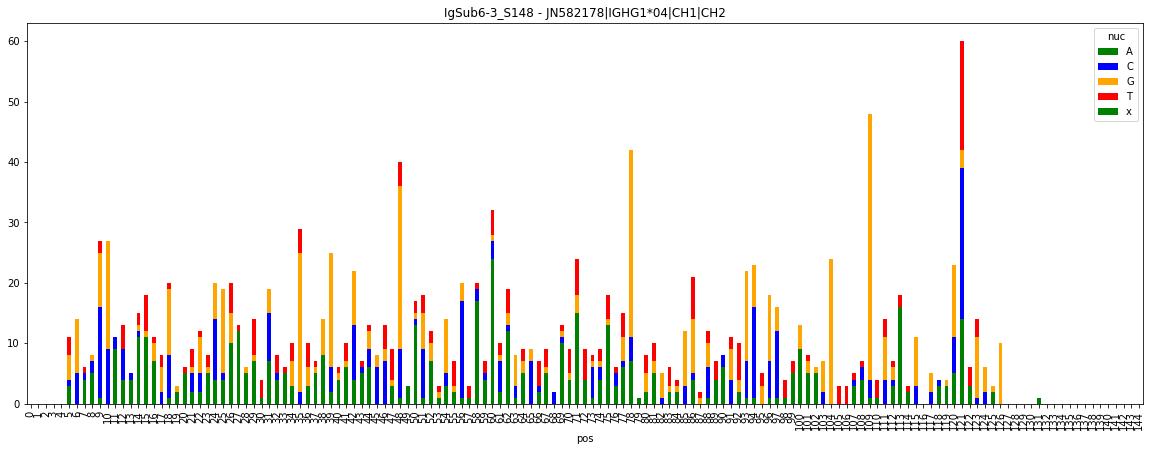

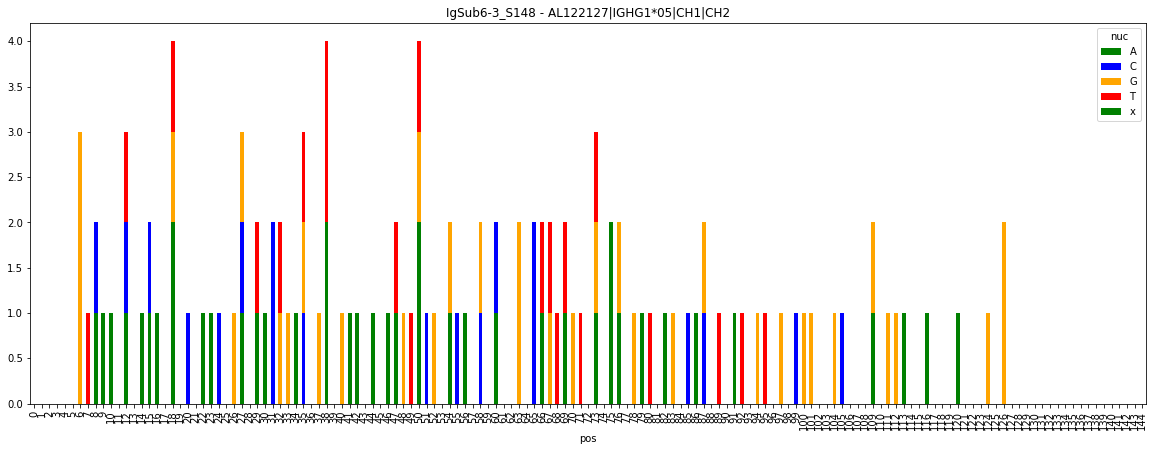

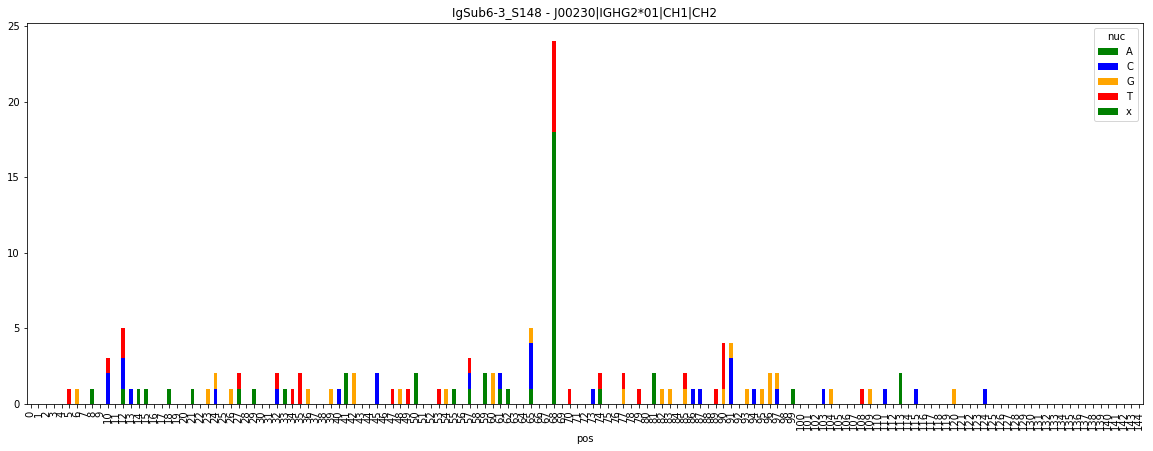

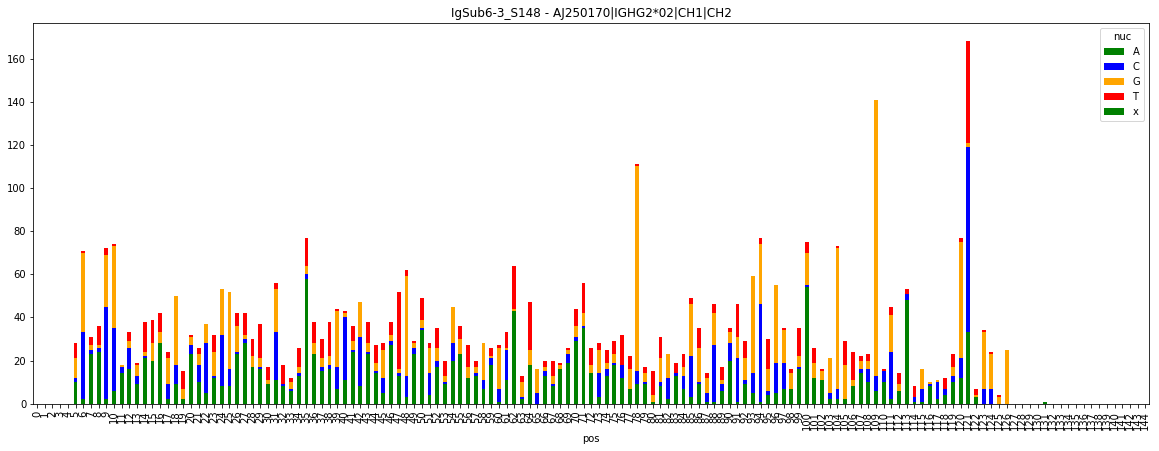

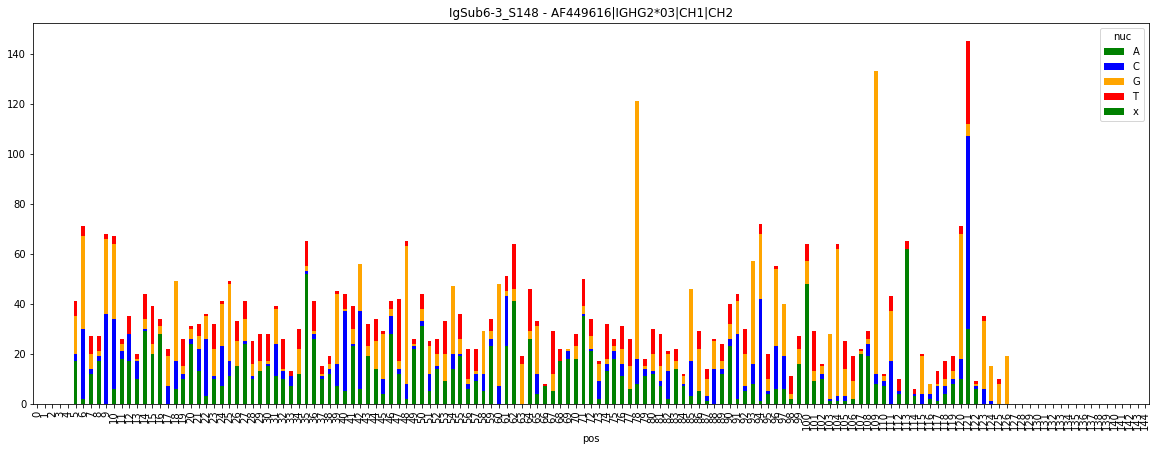

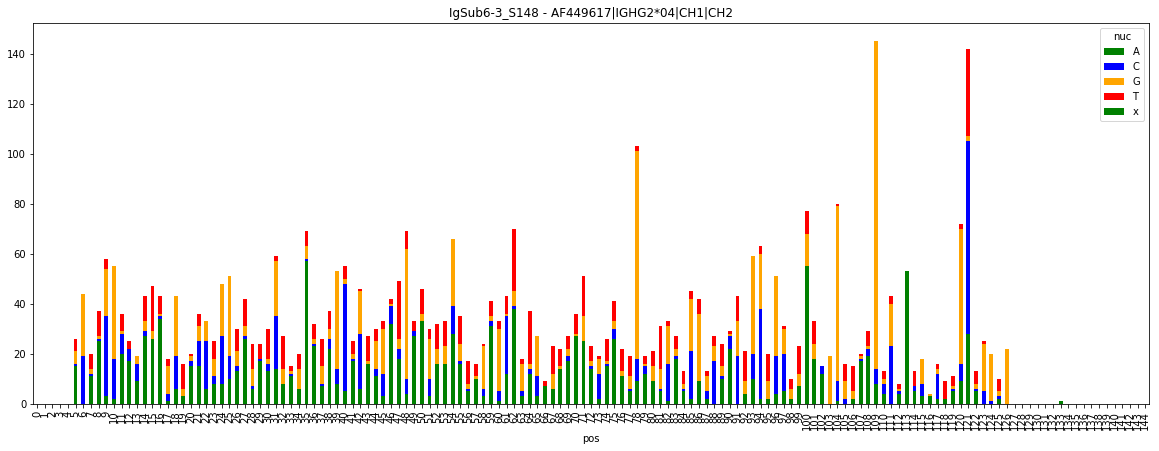

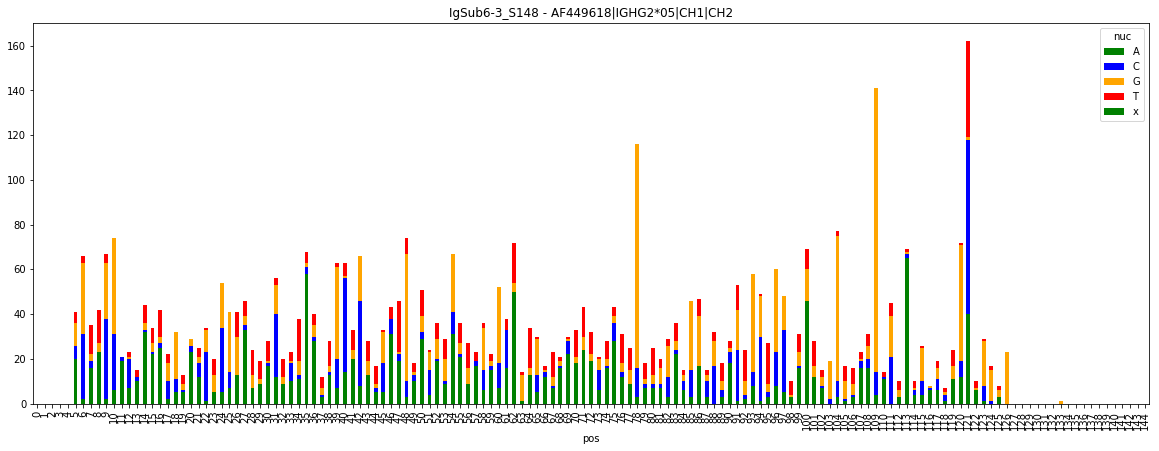

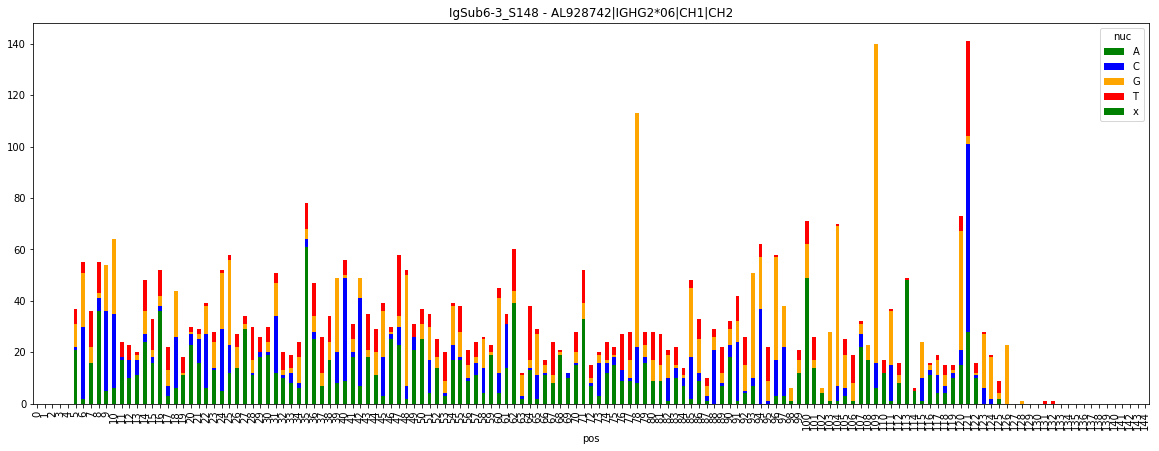

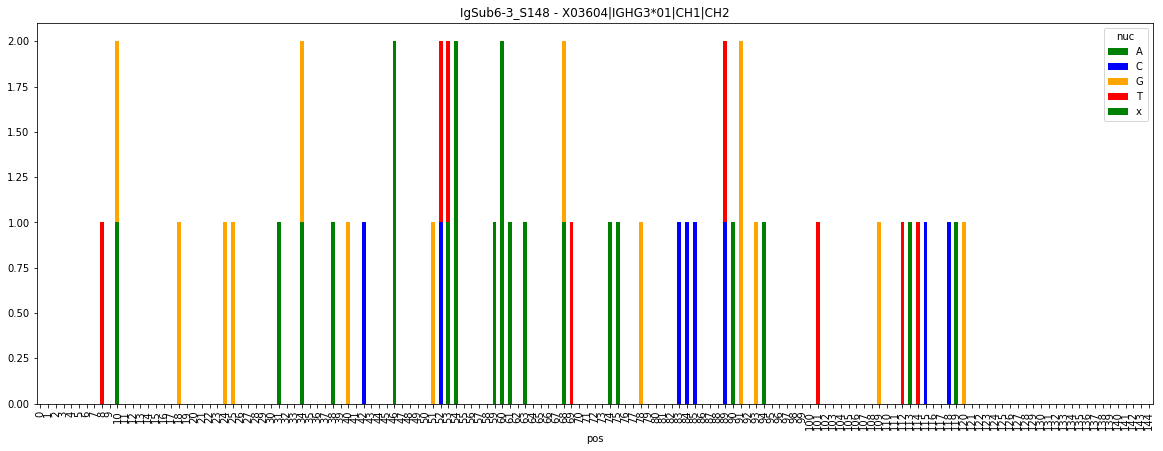

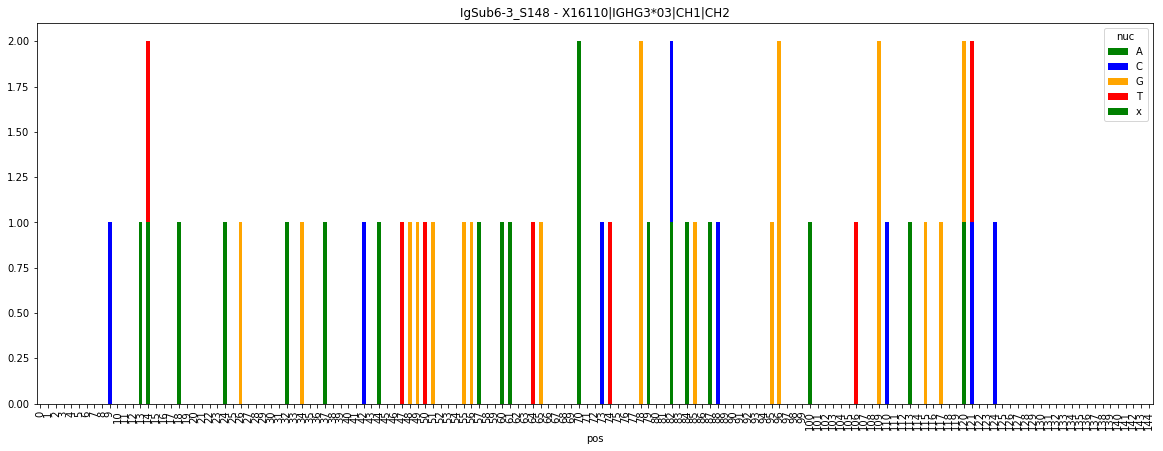

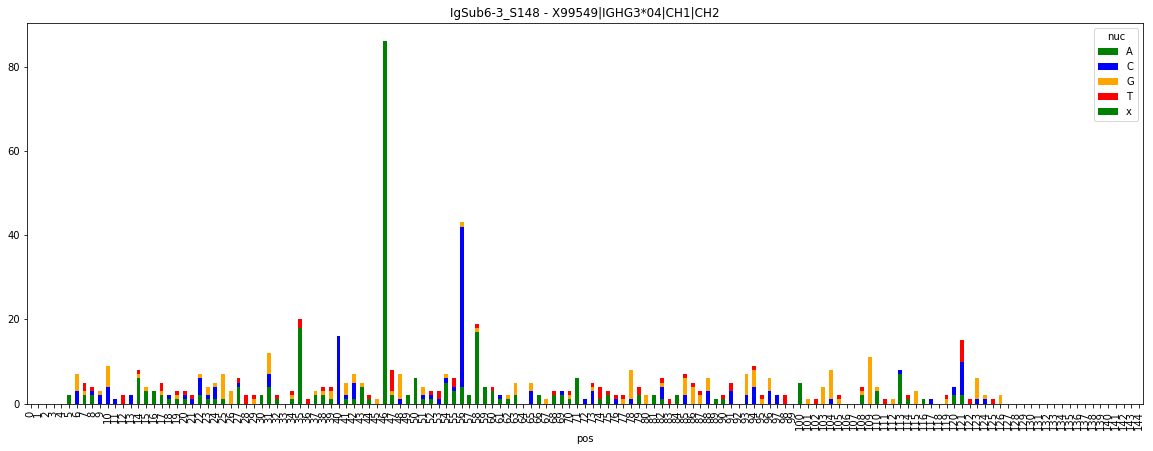

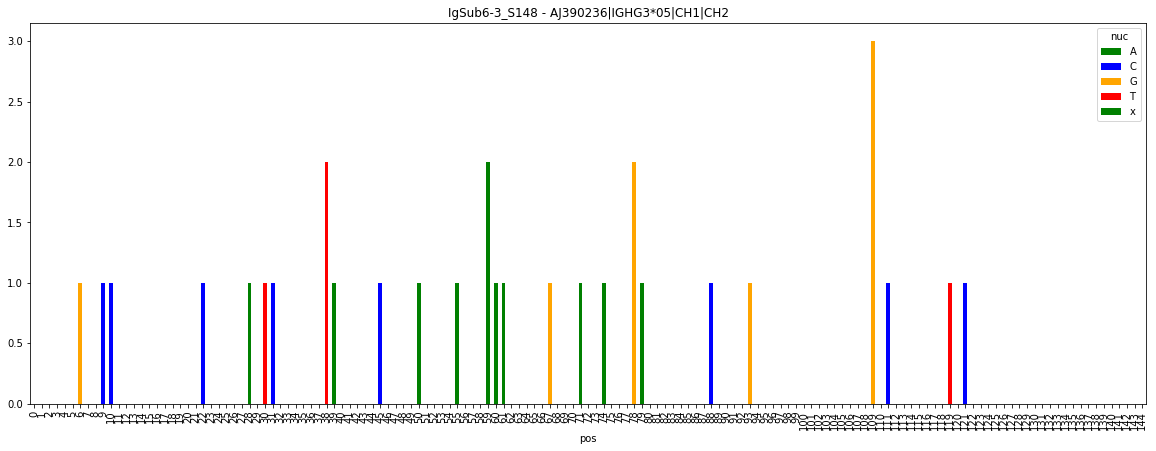

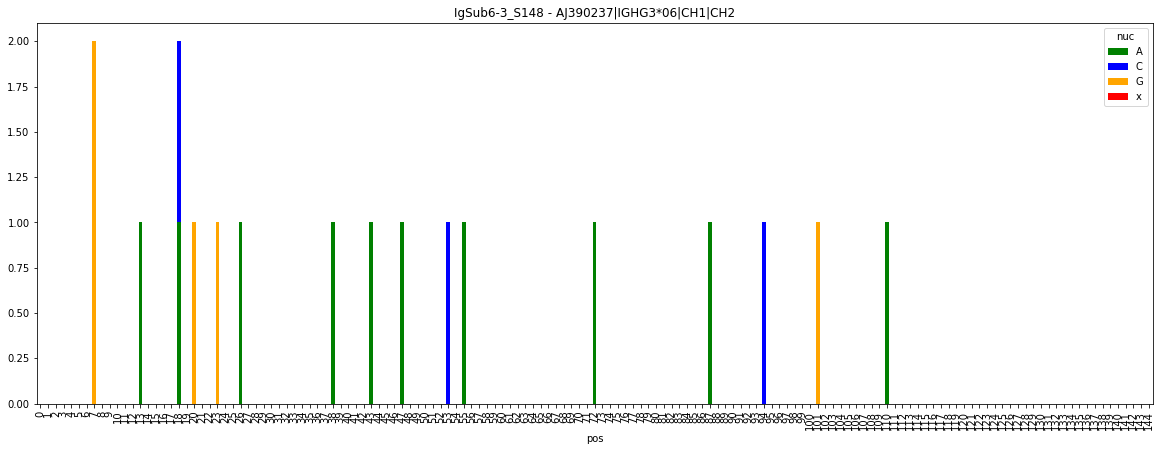

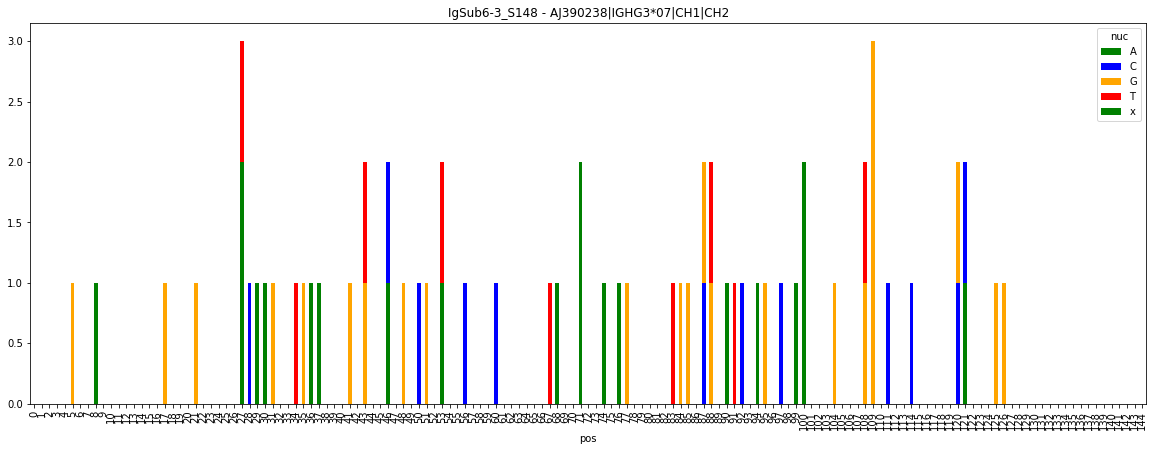

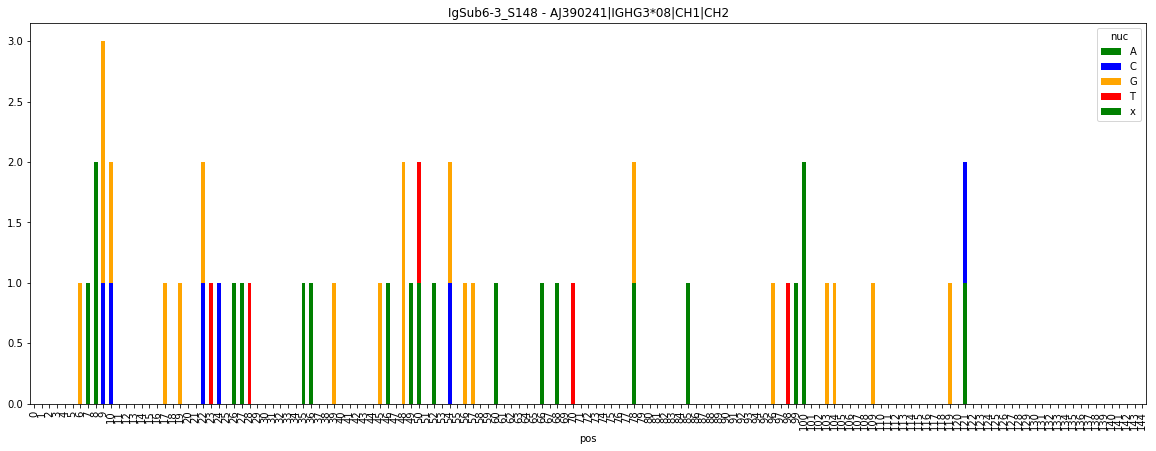

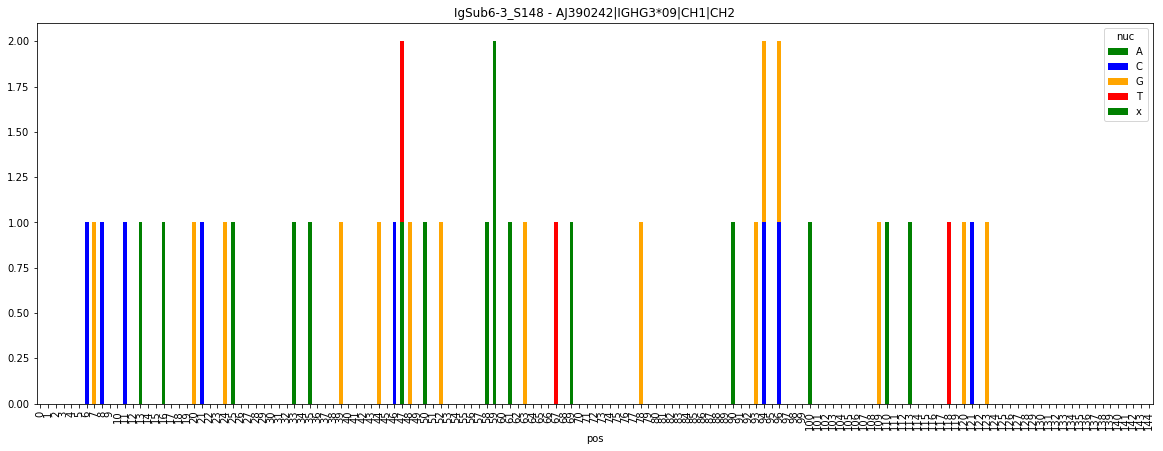

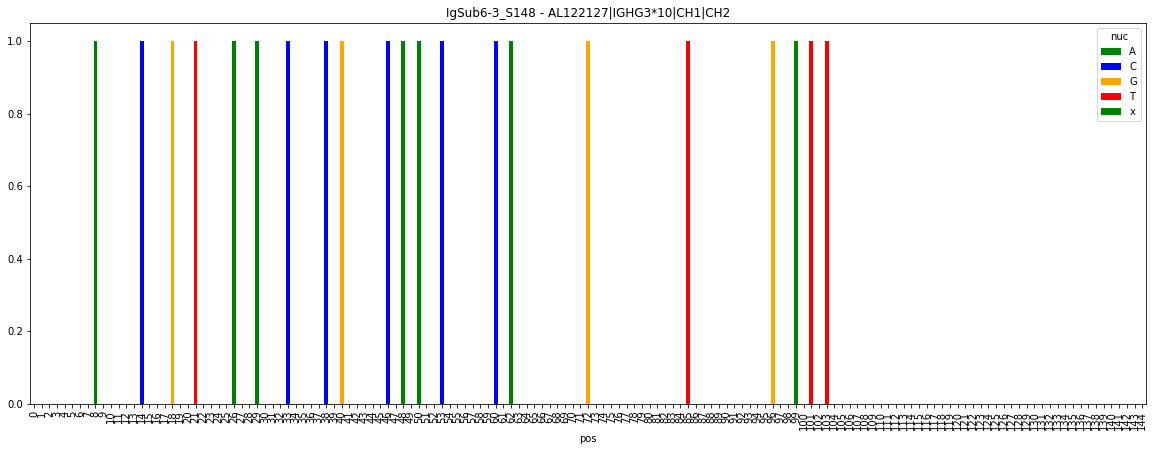

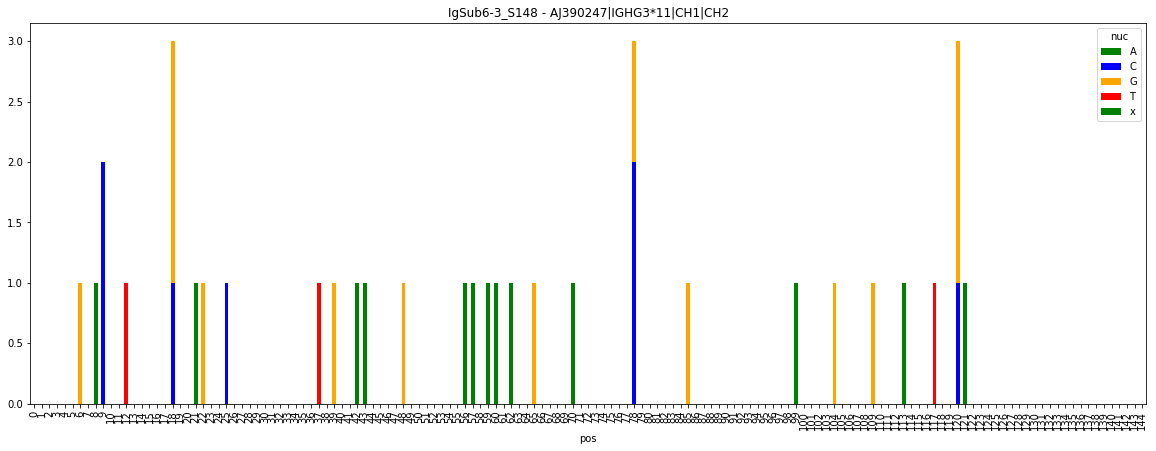

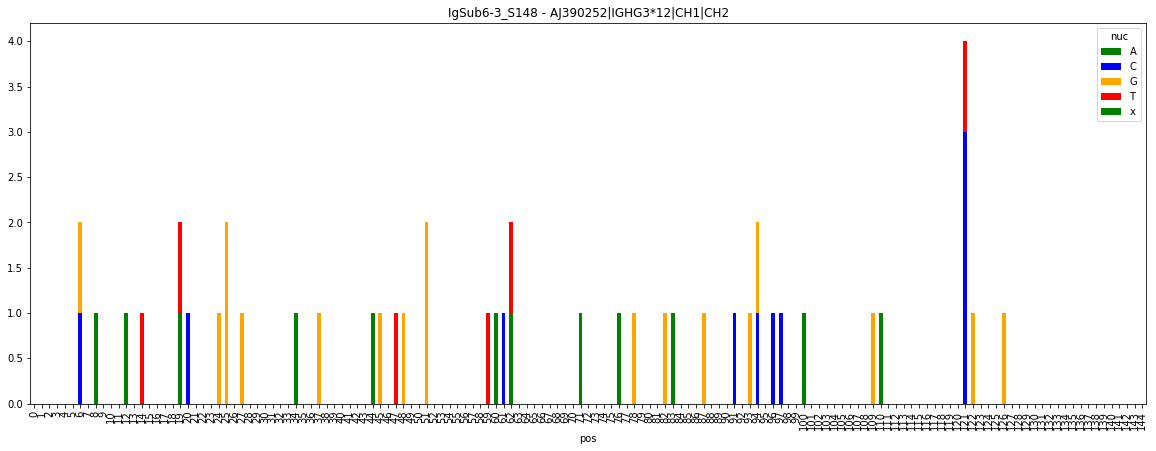

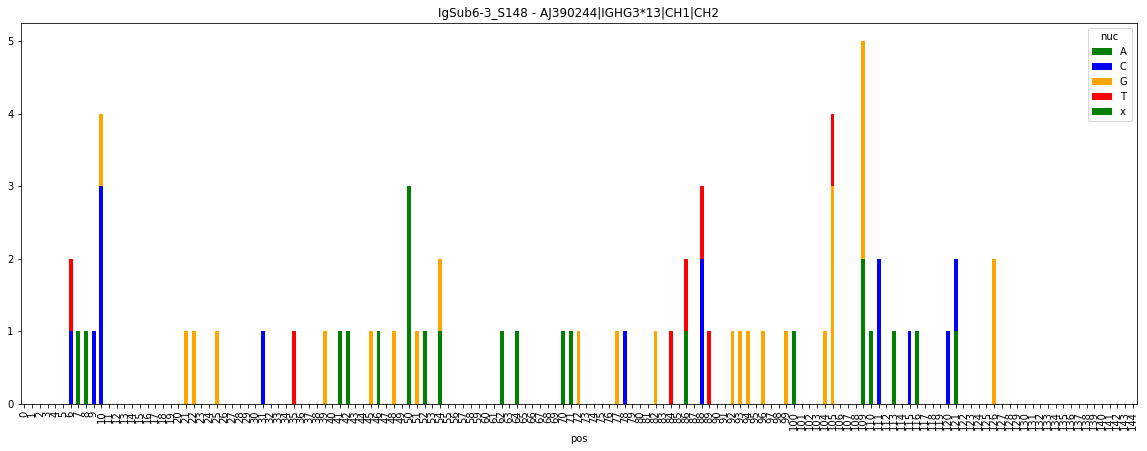

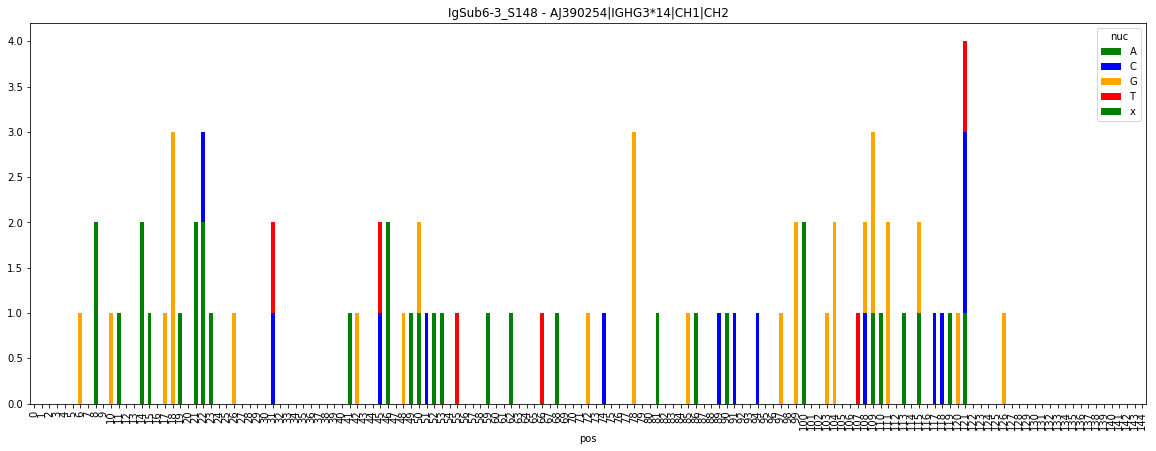

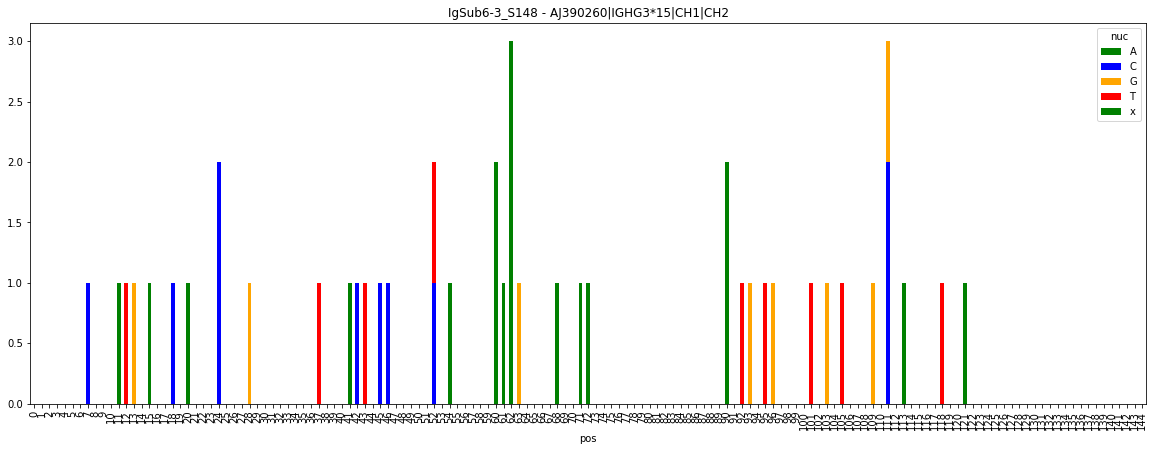

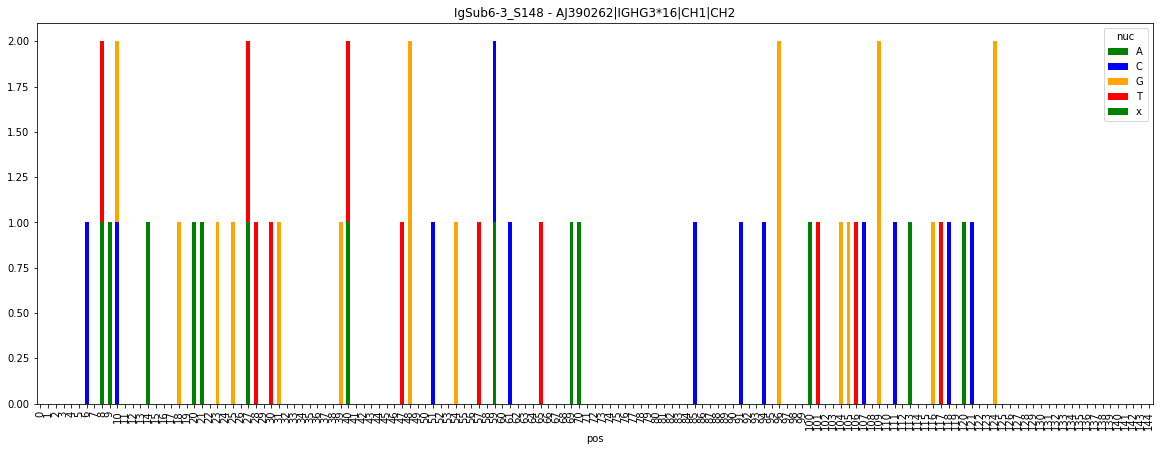

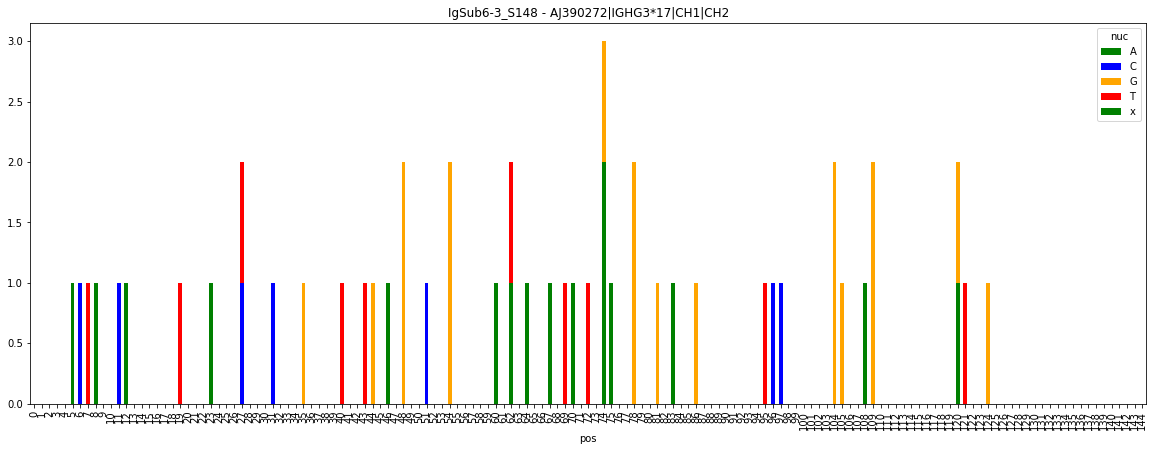

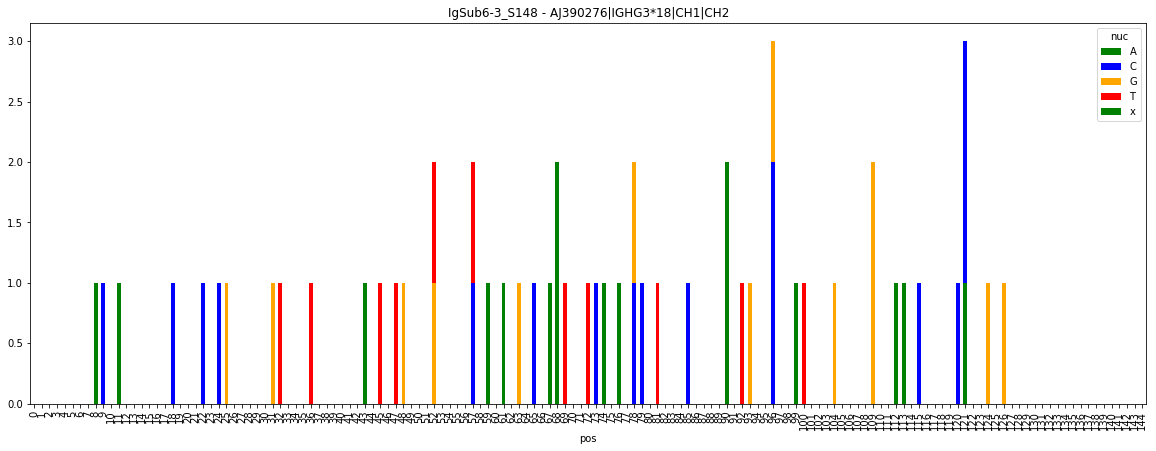

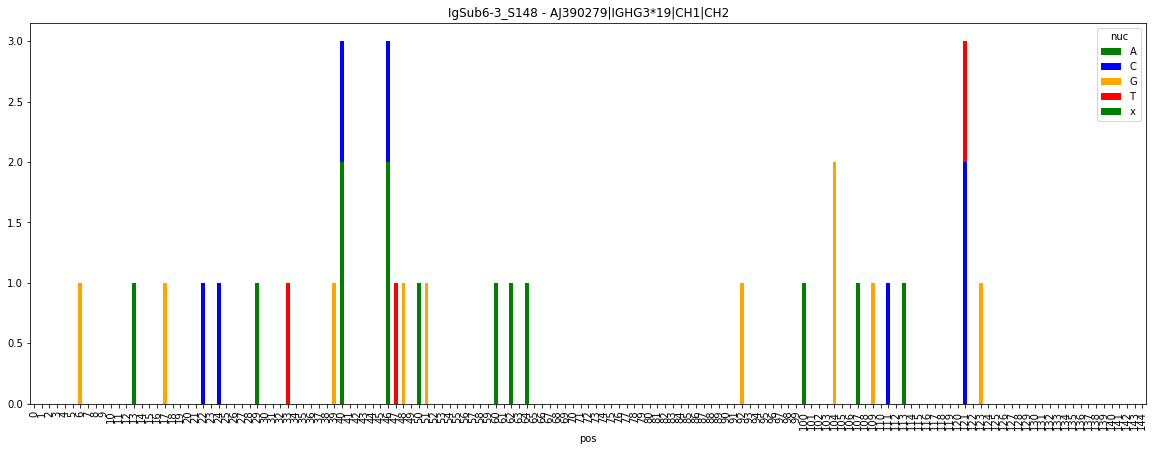

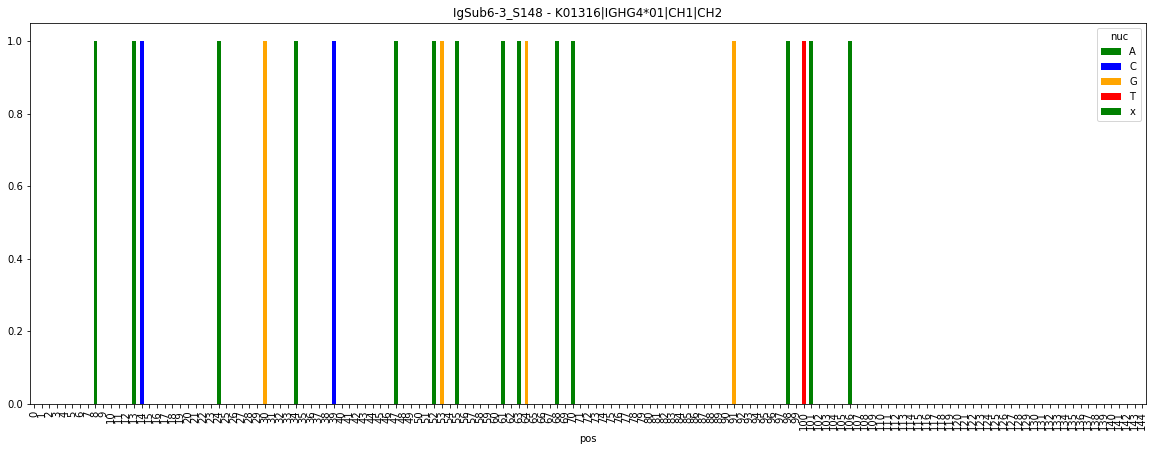

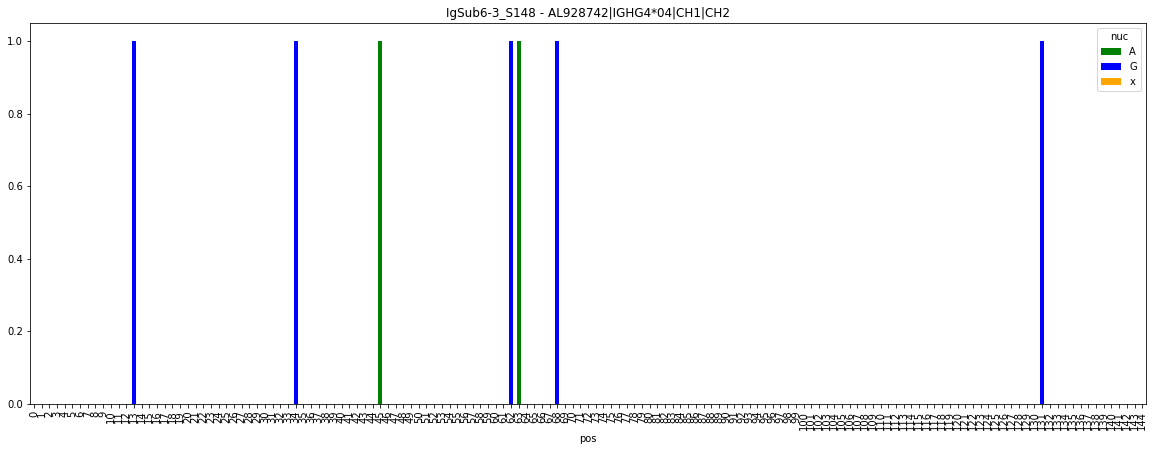

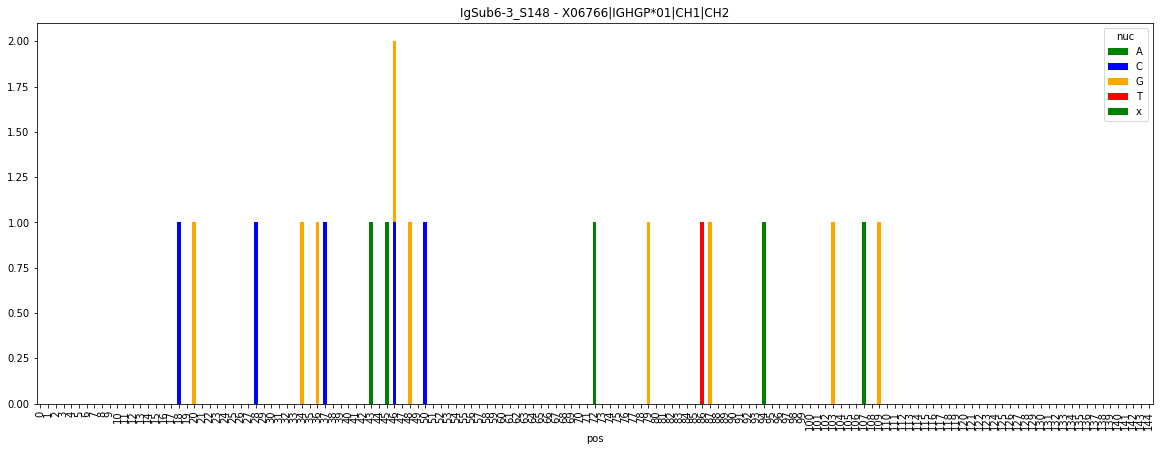

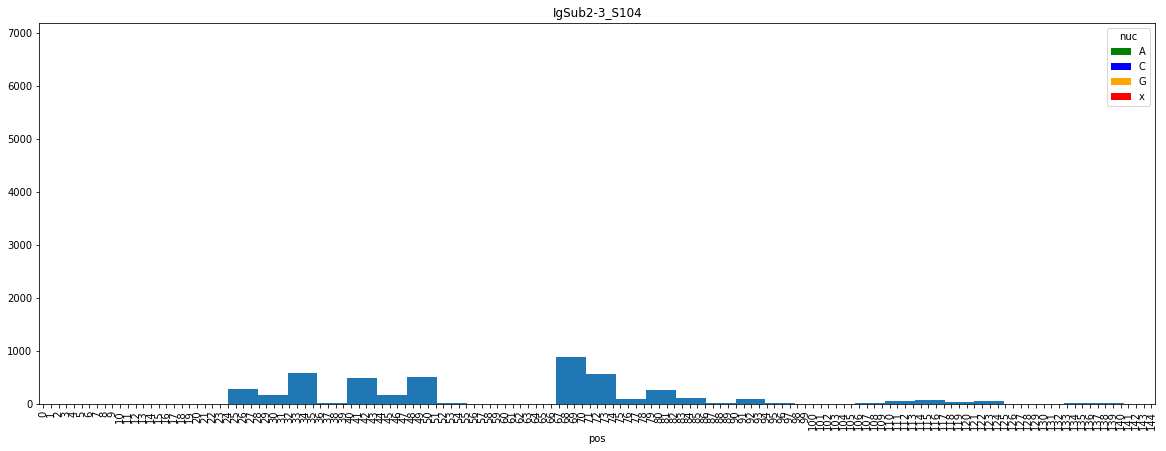

Sample: IgSub3-3_S122


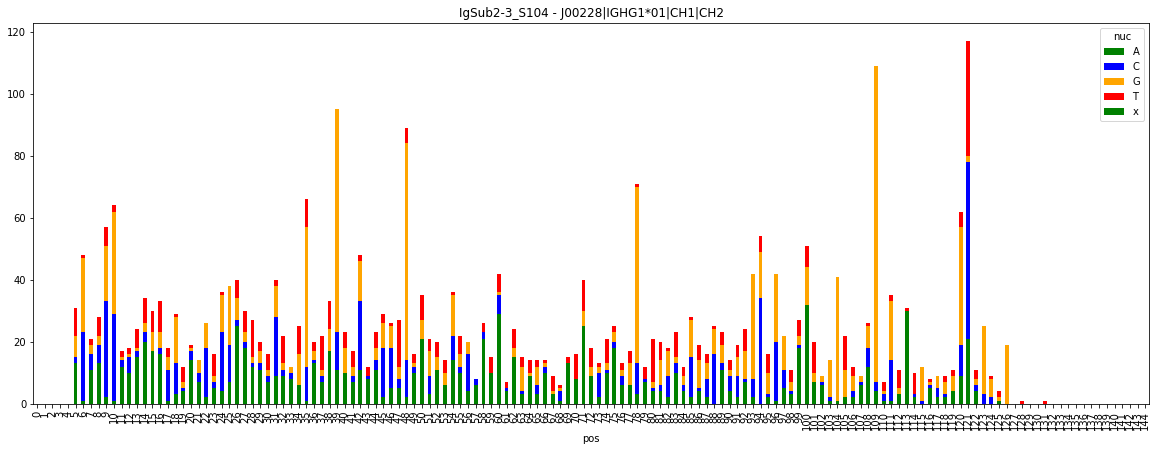

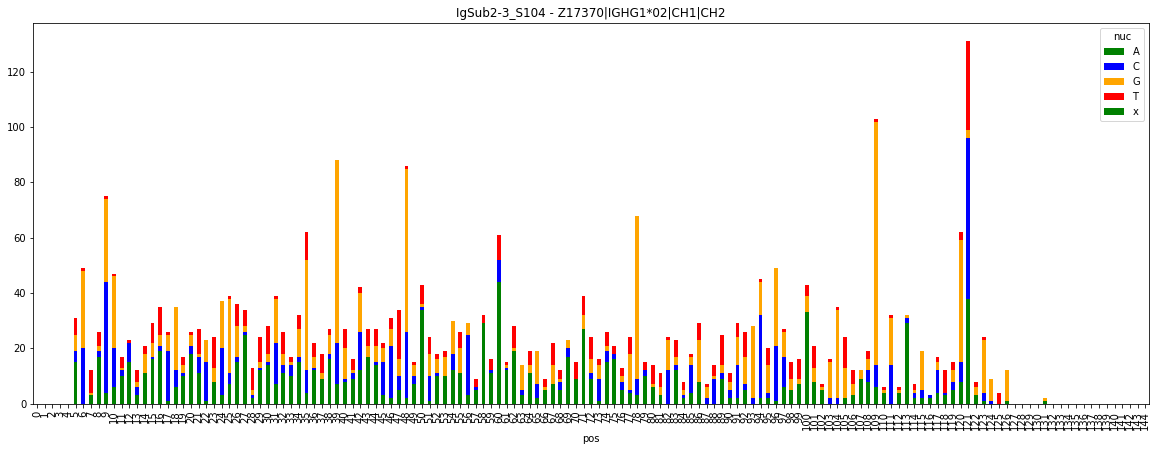

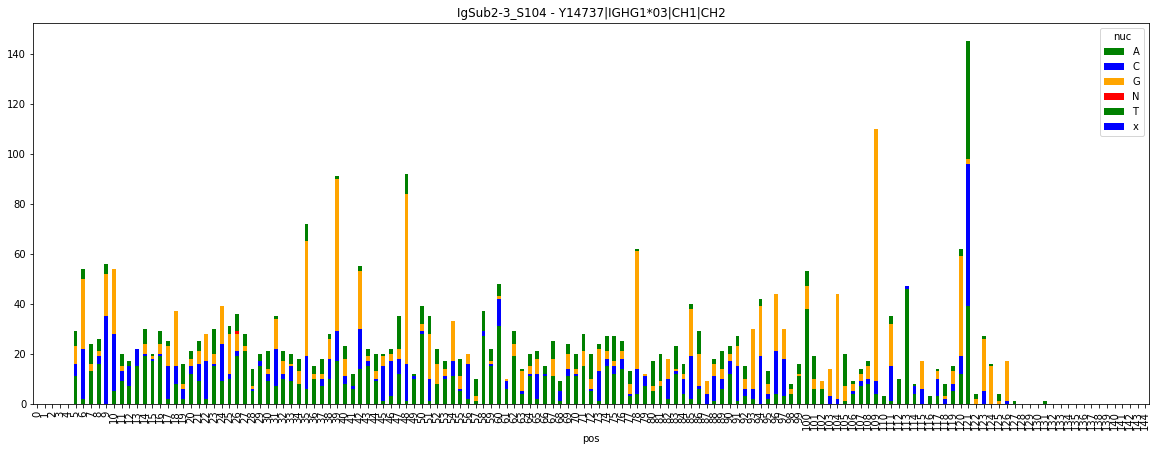

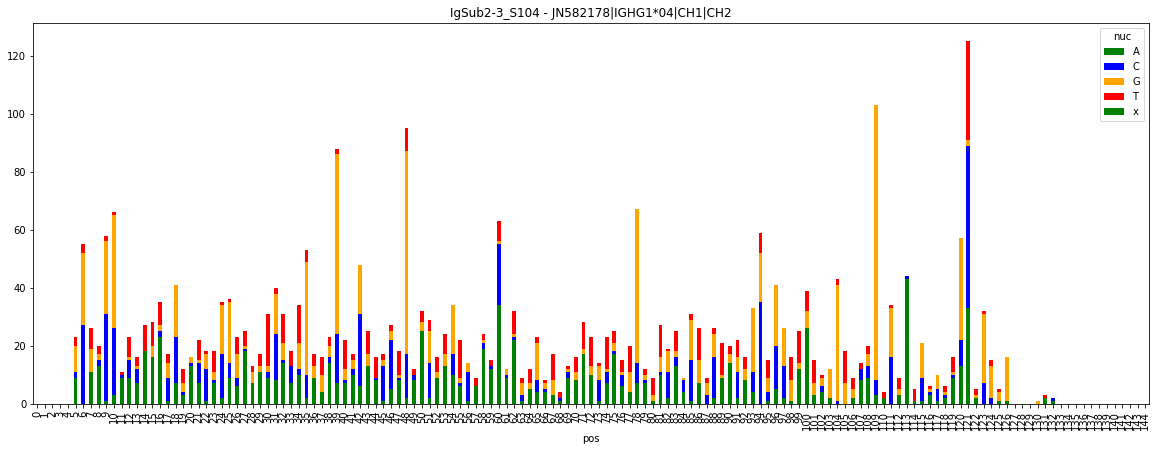

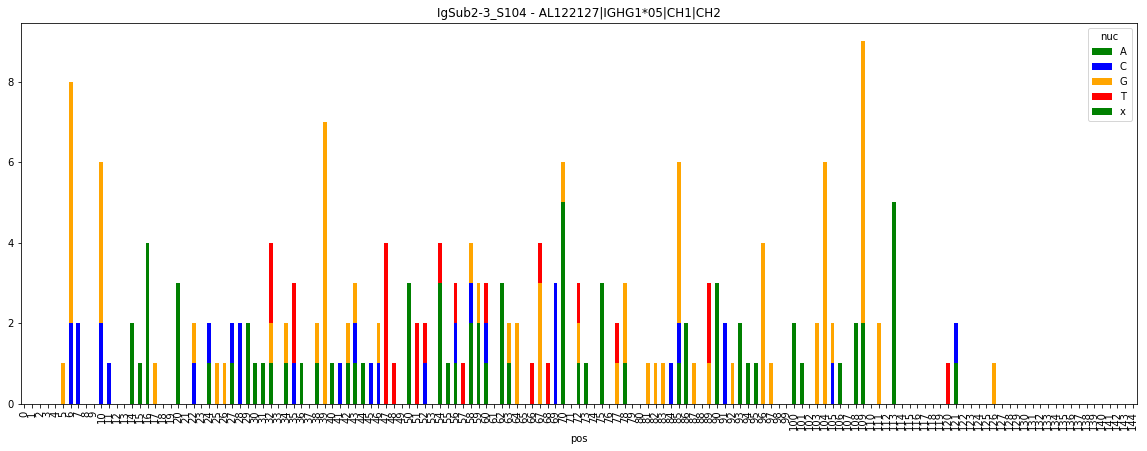

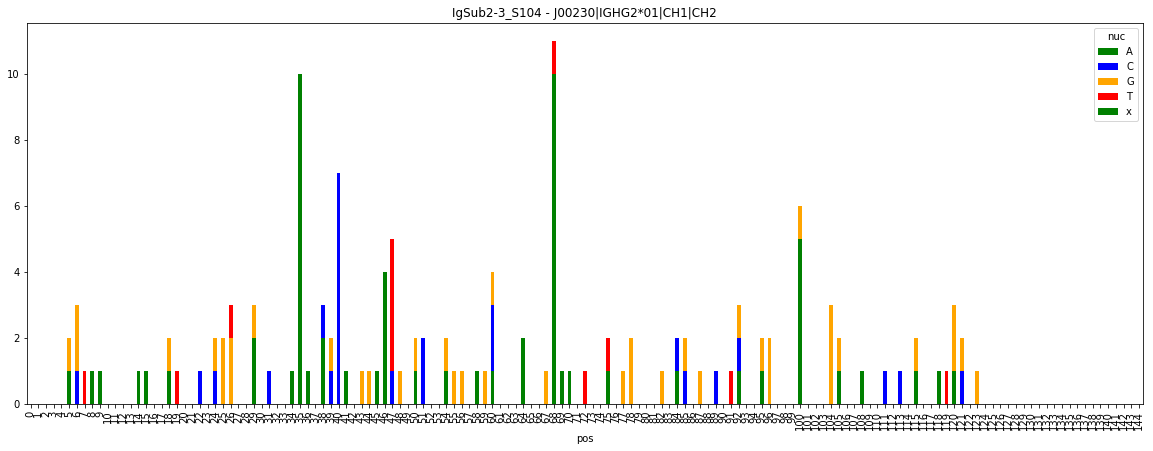

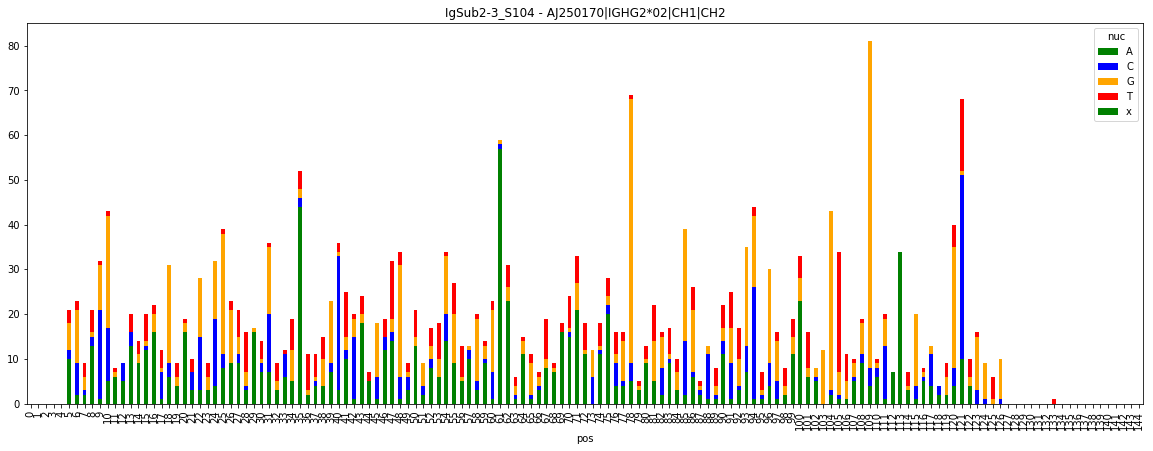

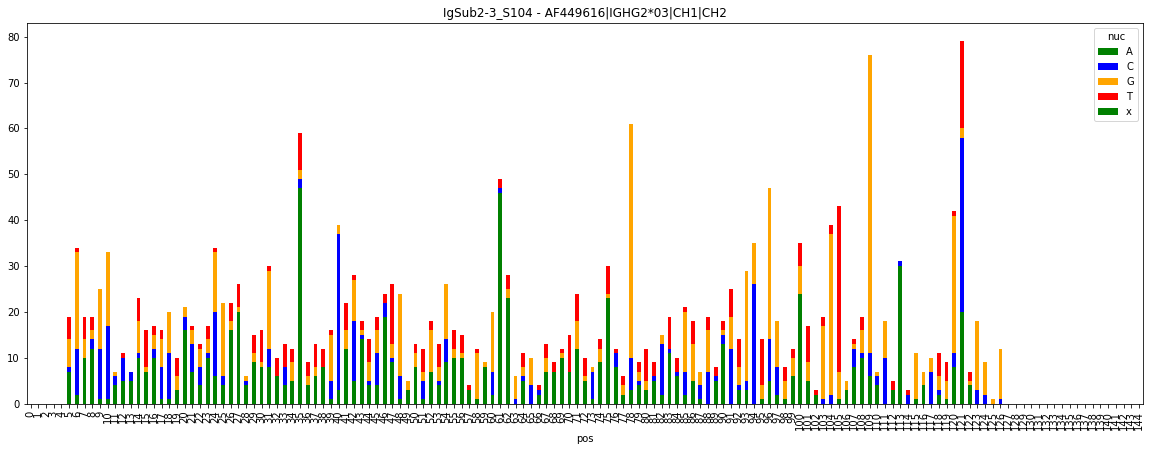

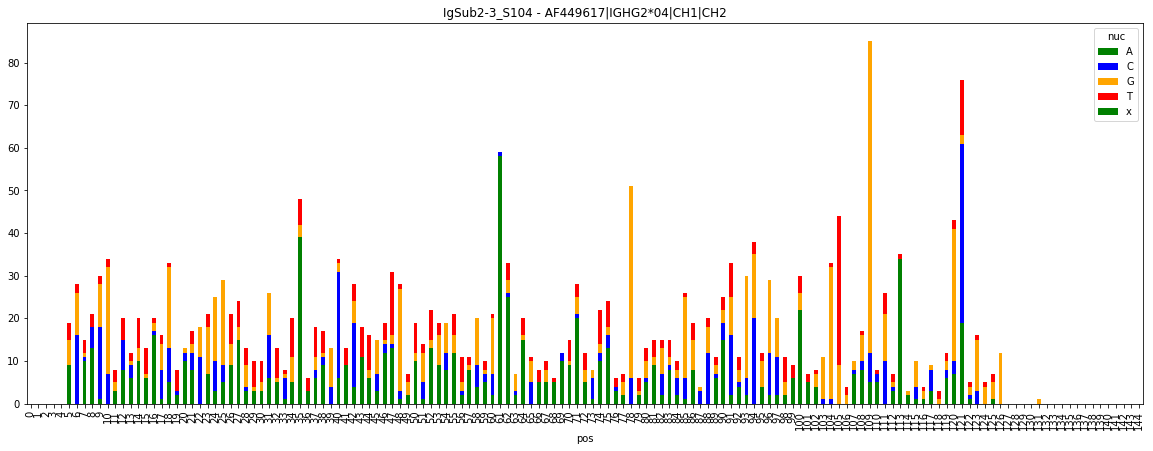

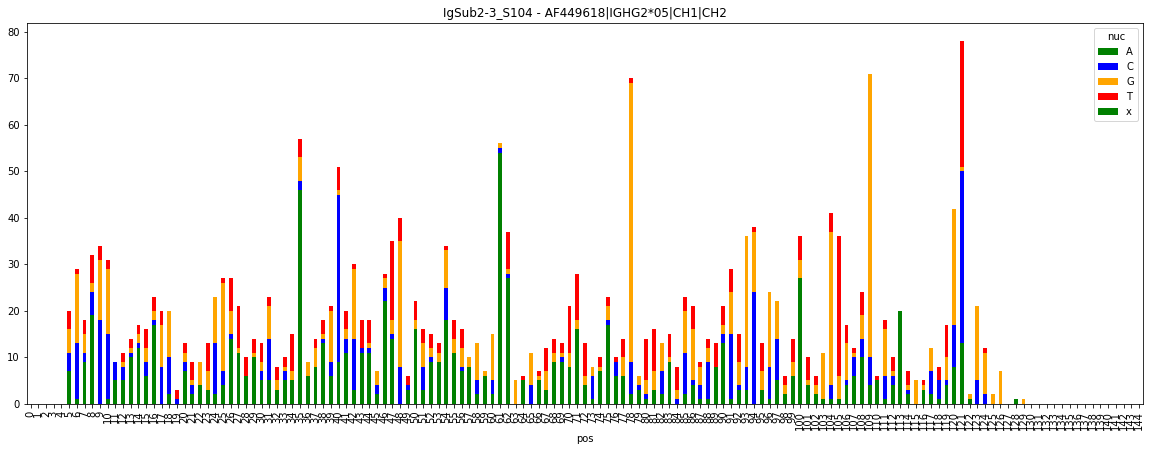

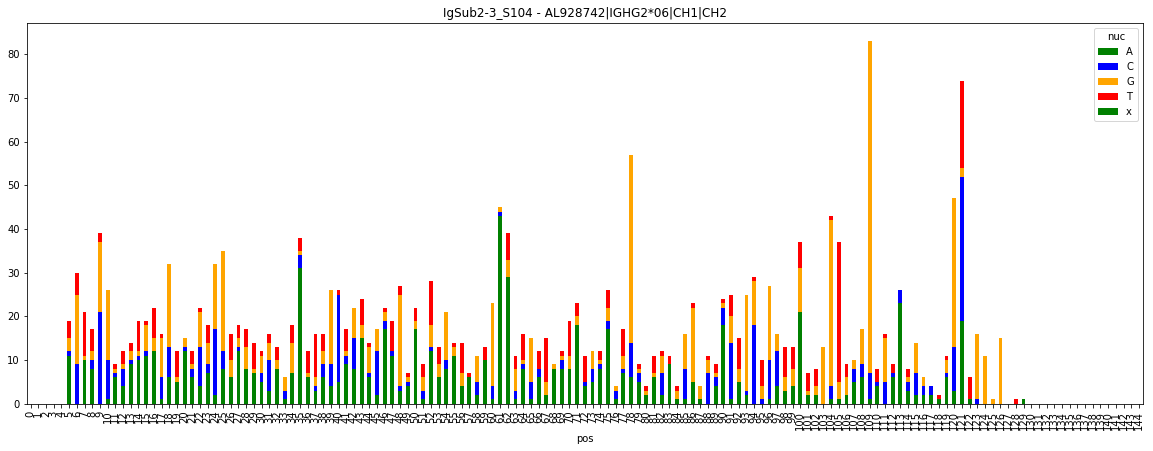

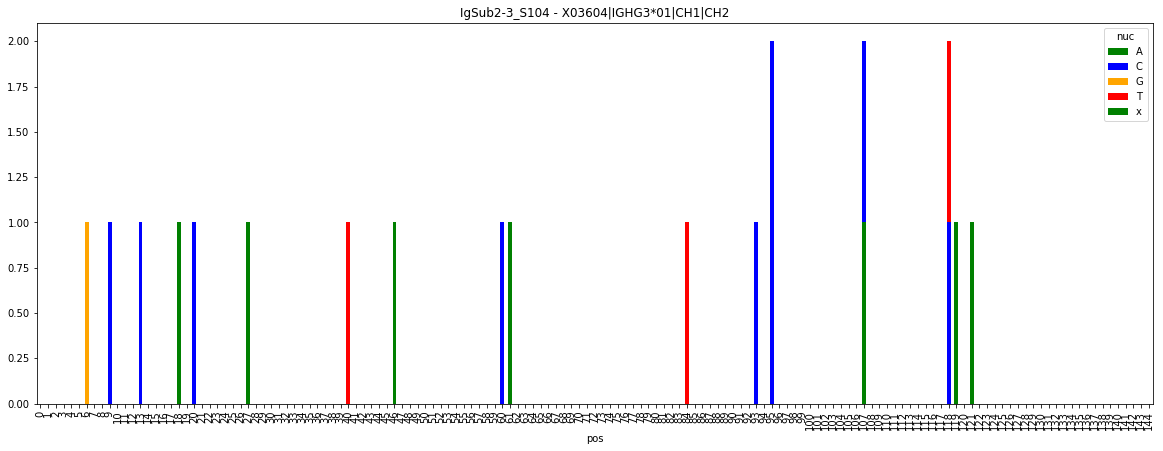

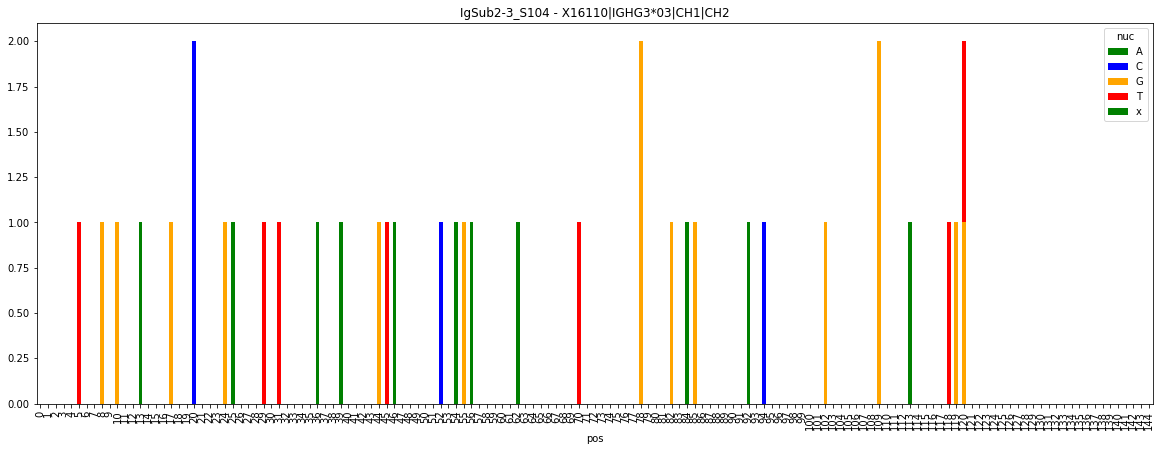

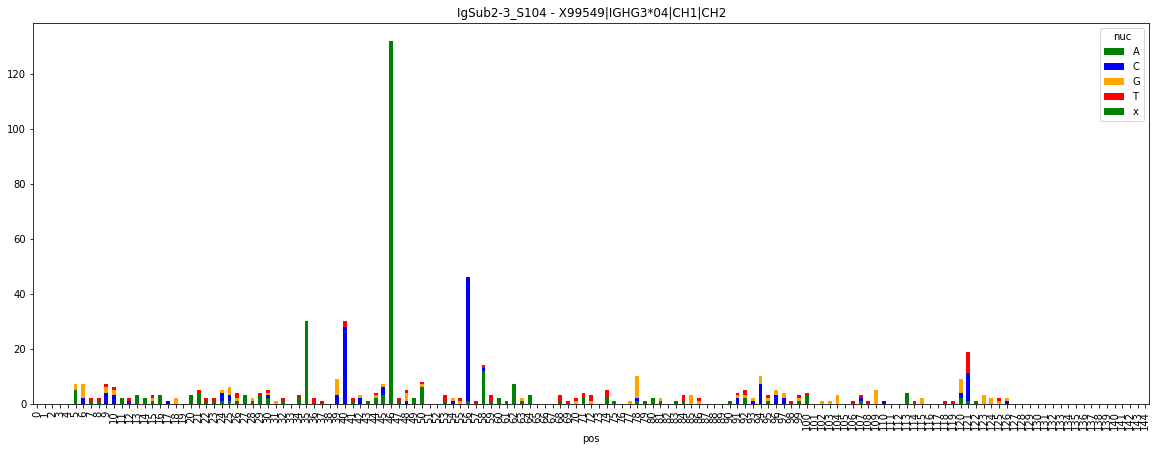

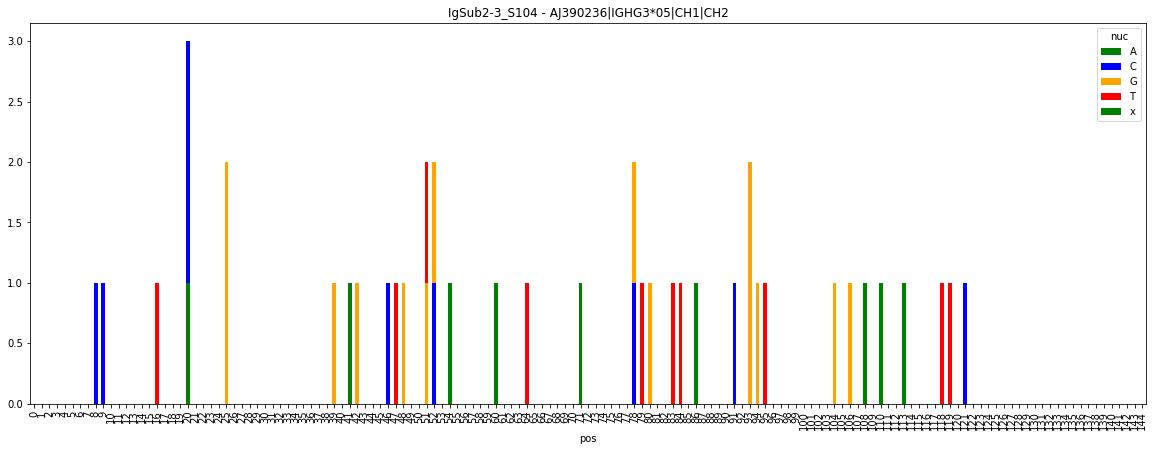

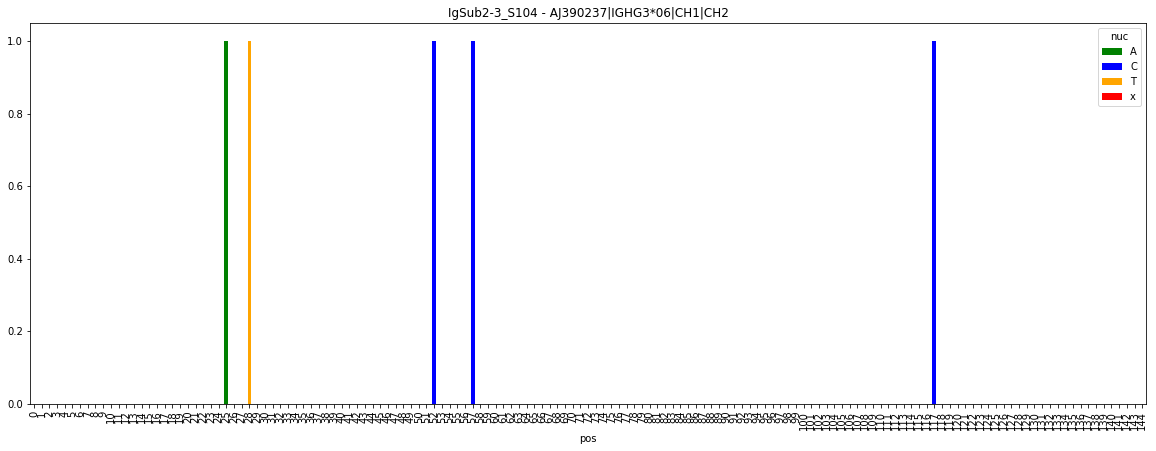

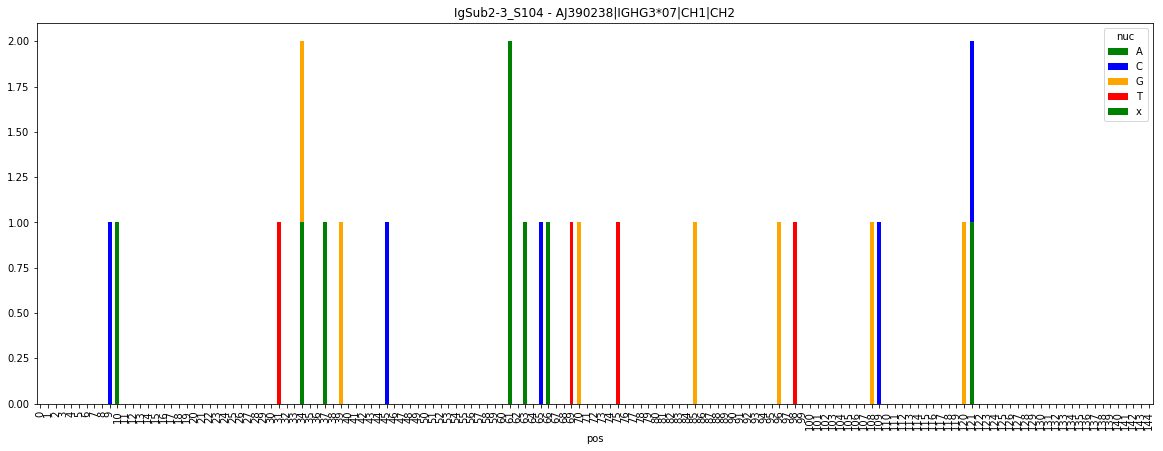

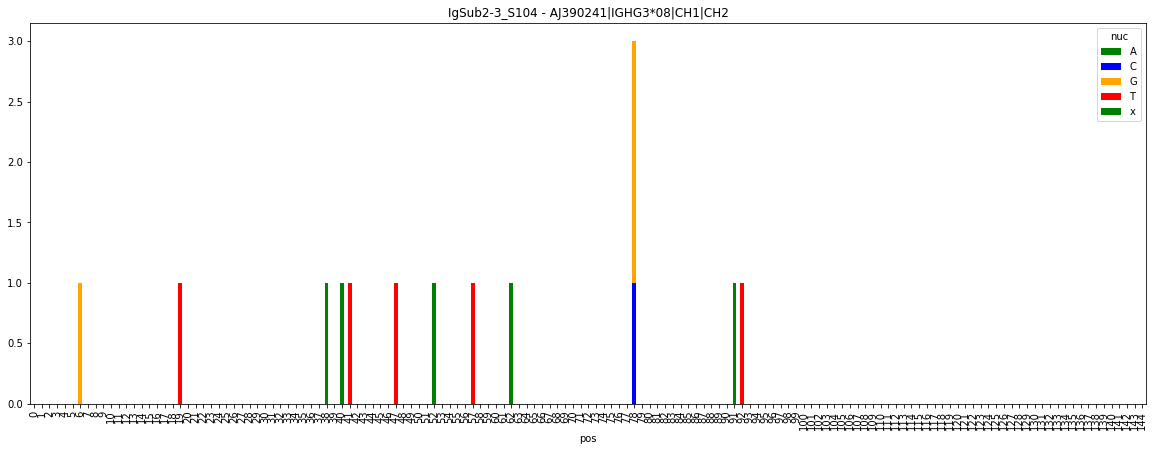

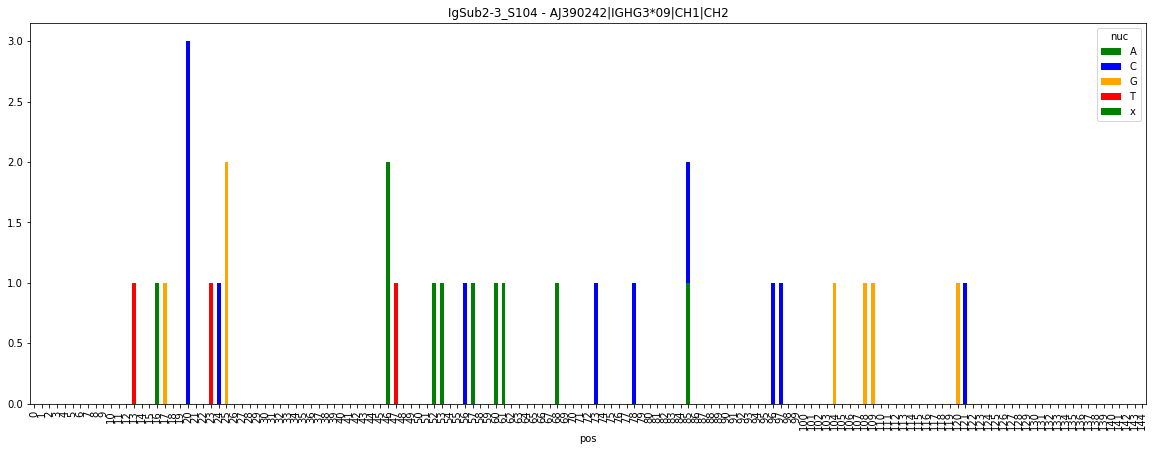

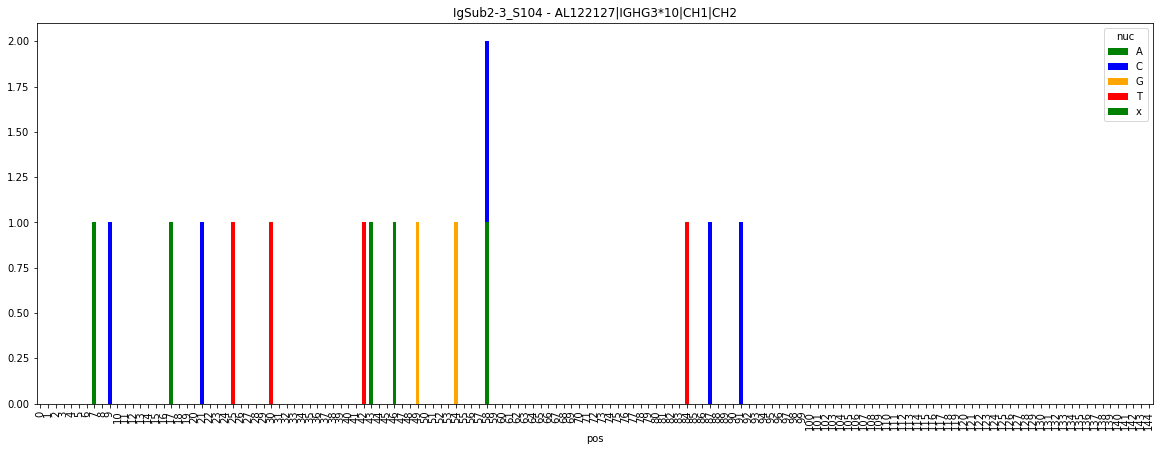

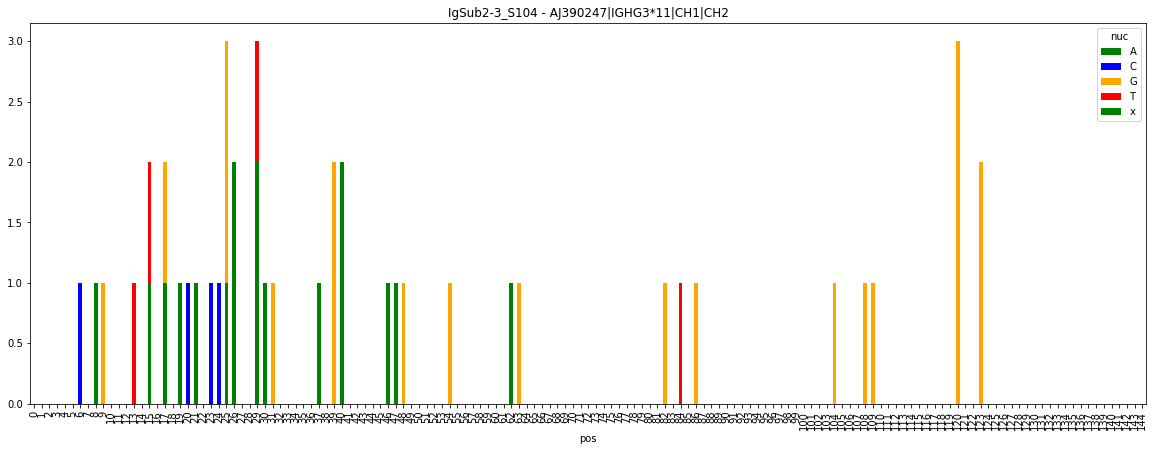

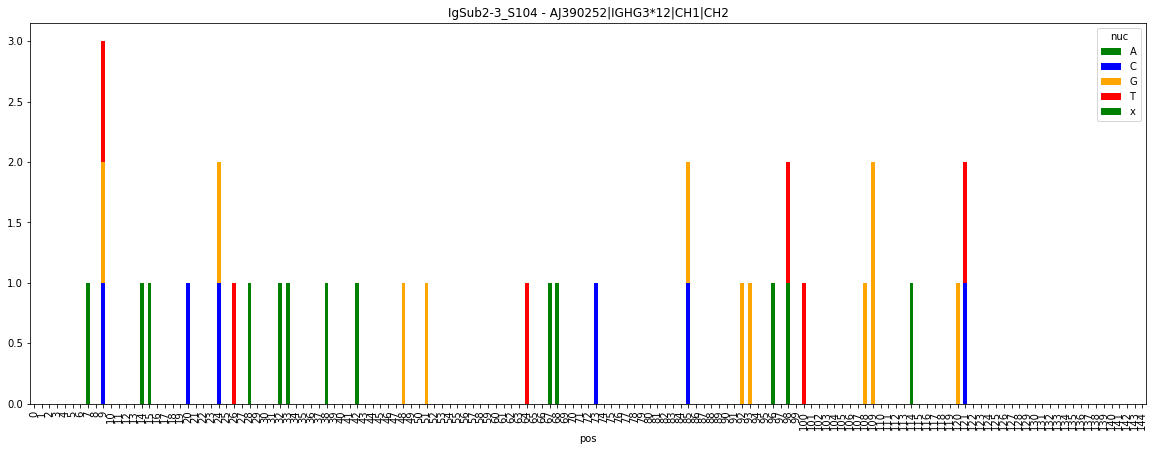

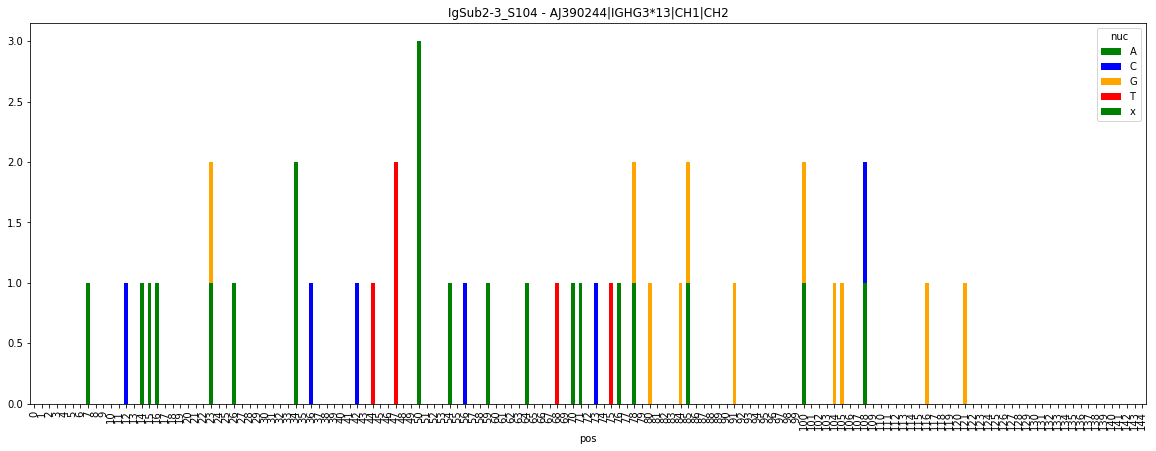

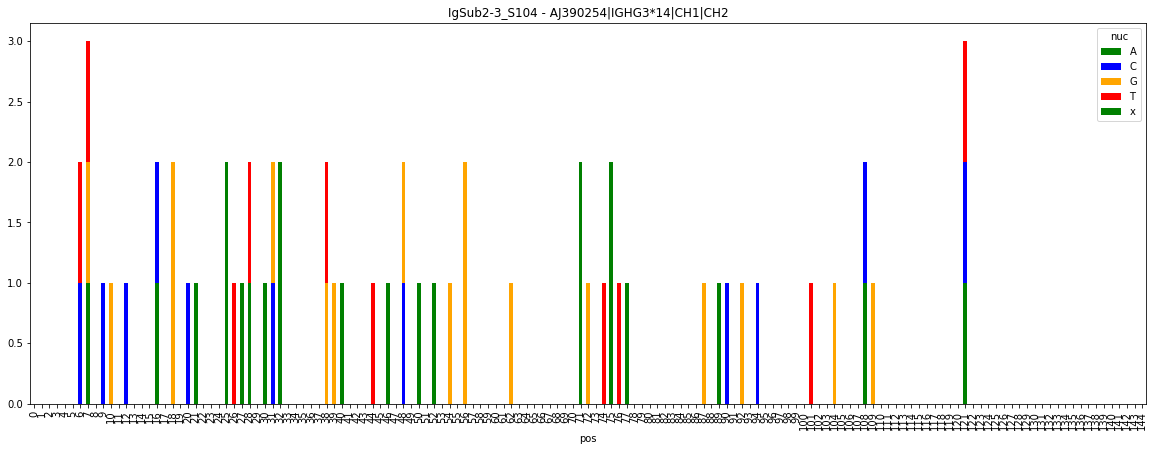

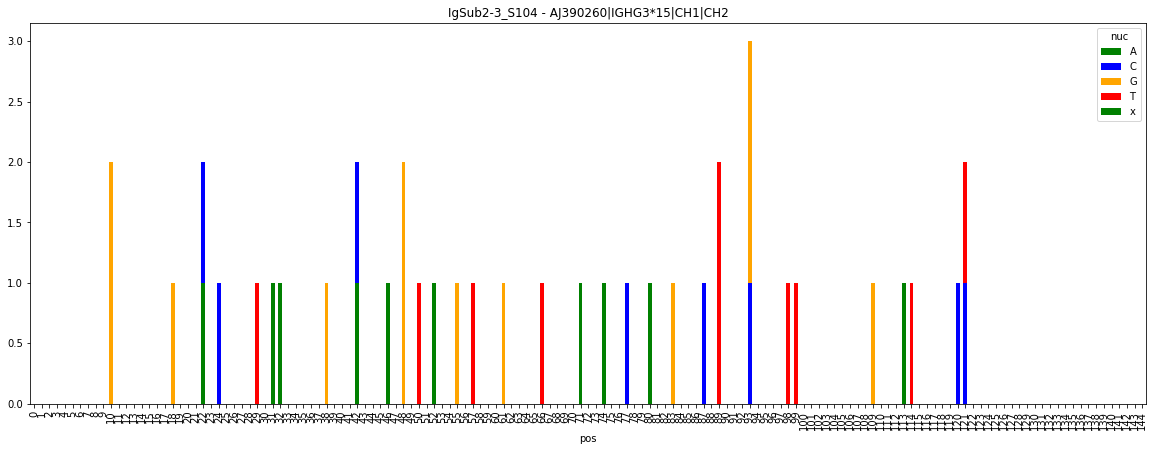

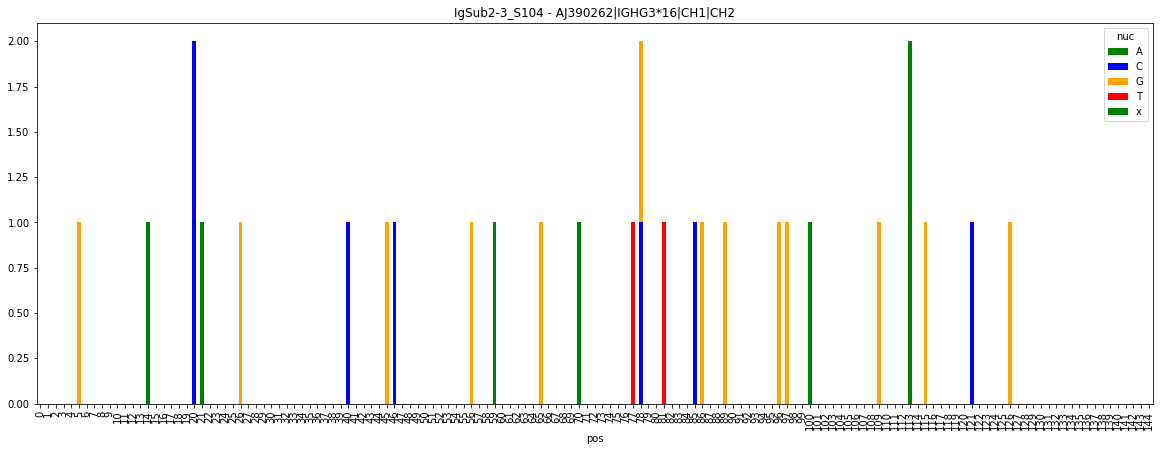

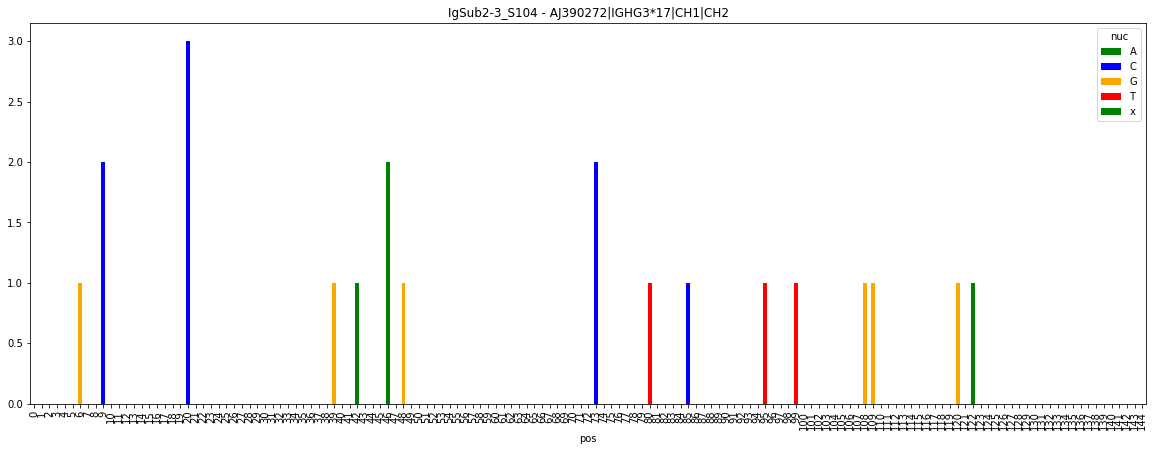

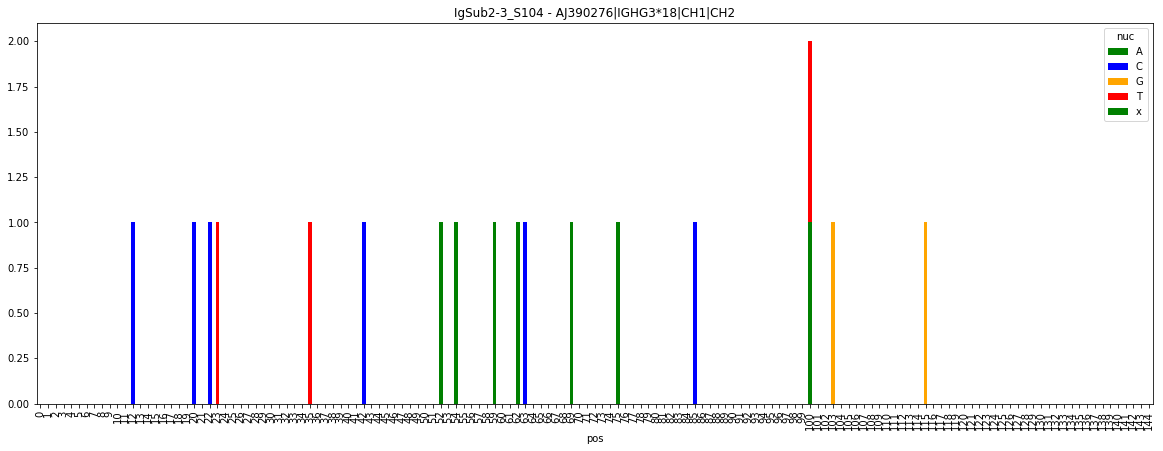

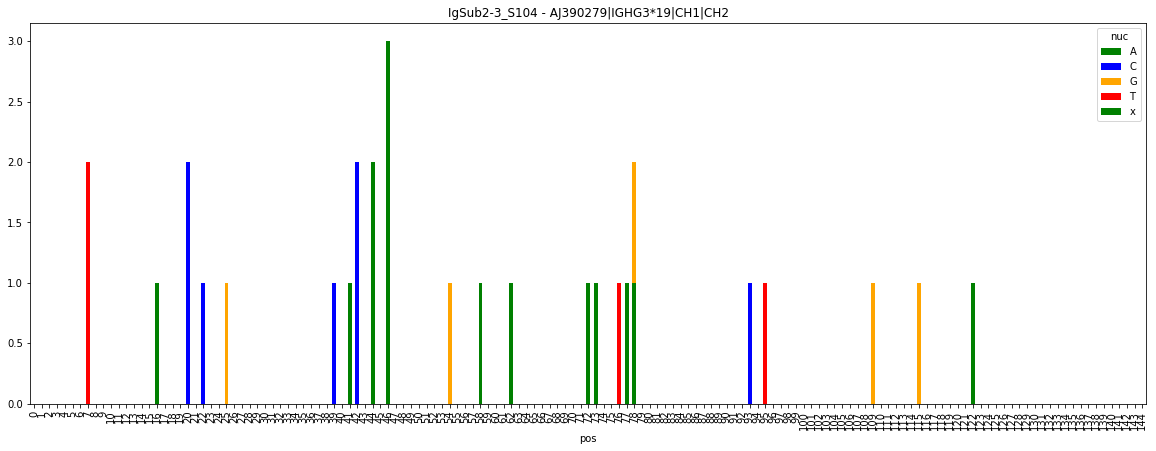

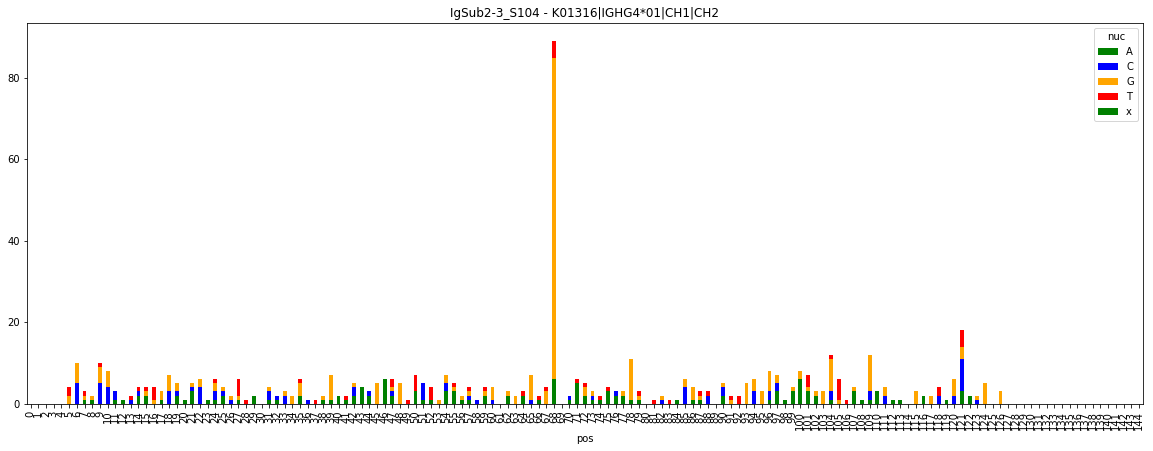

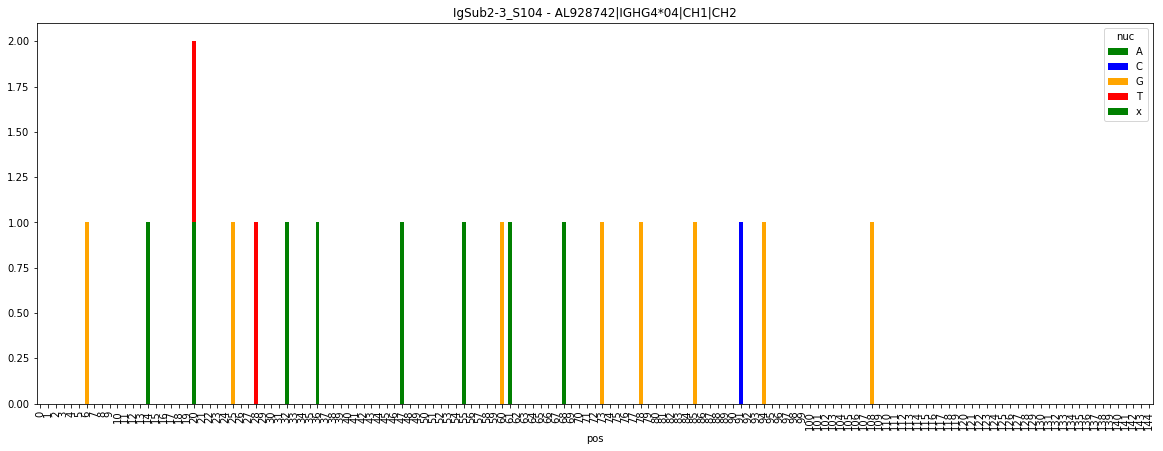

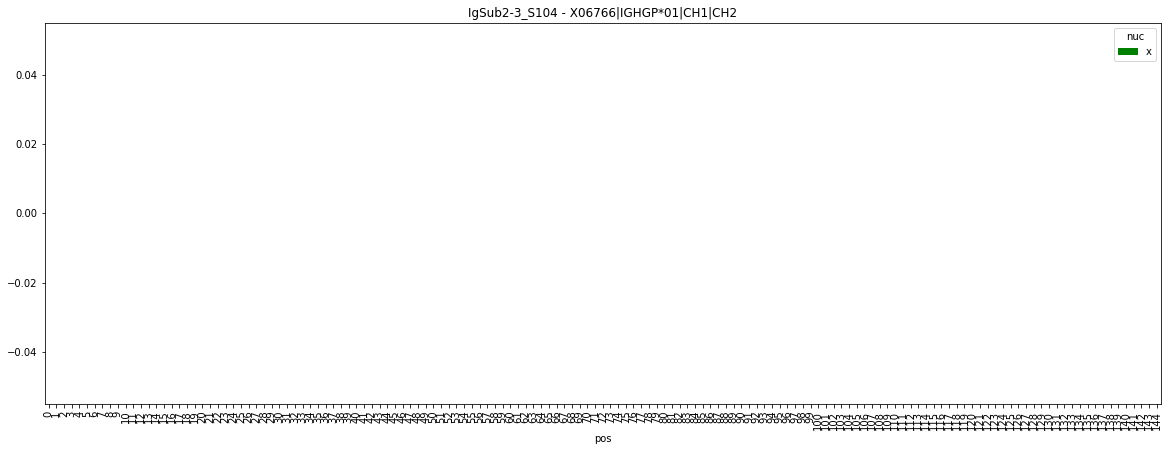

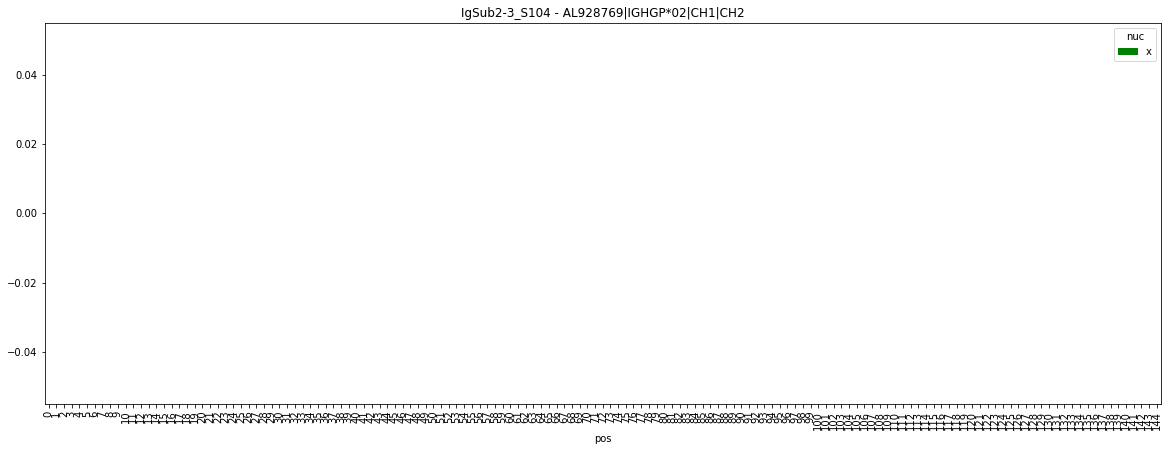

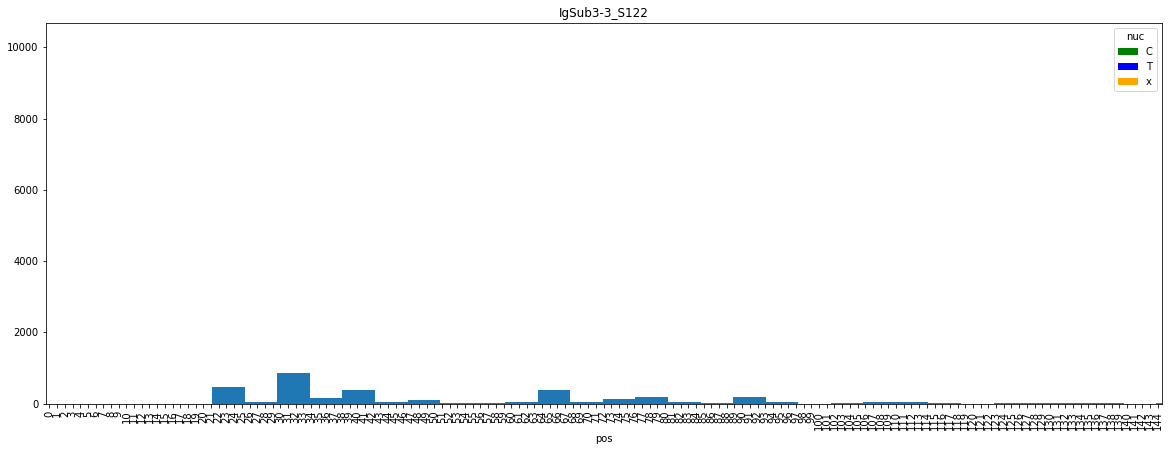

Sample: IgSub1-3_S100


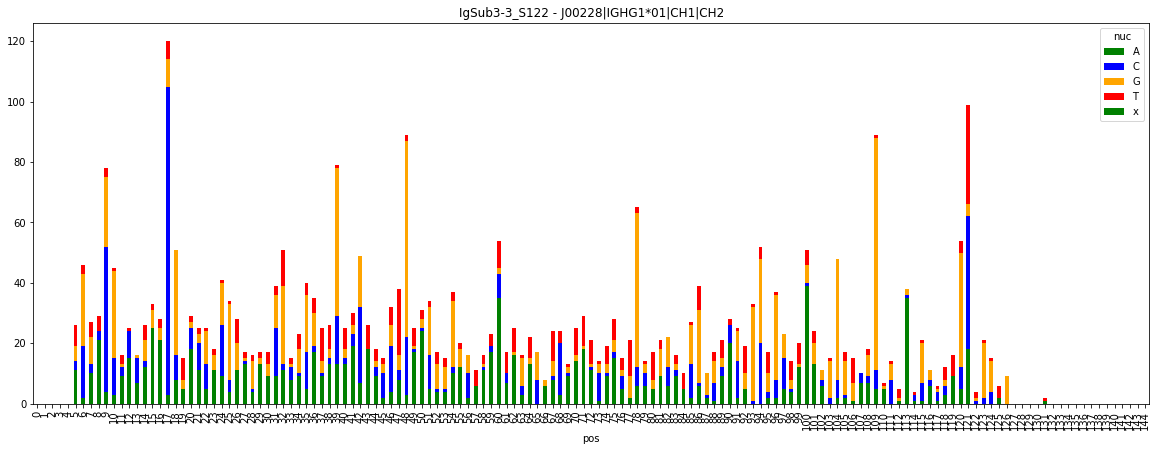

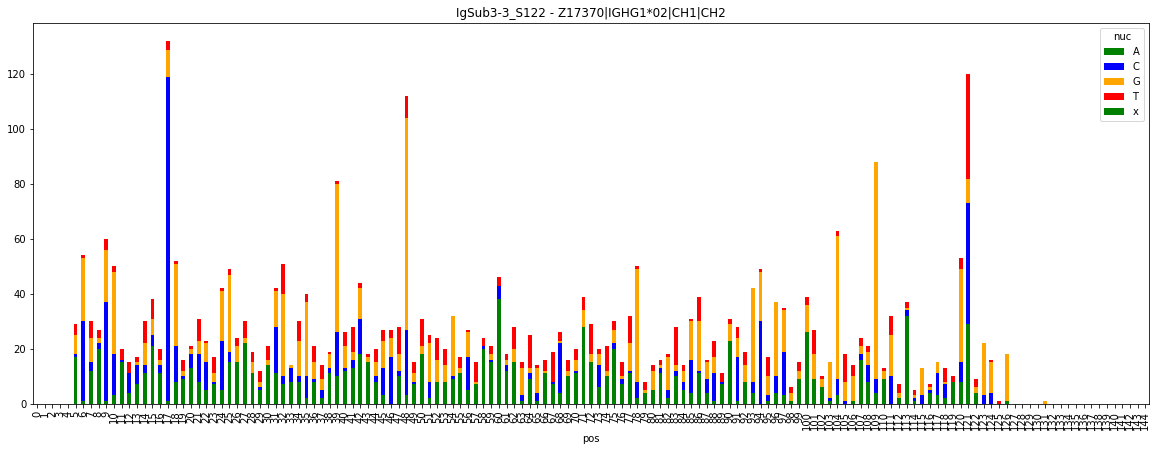

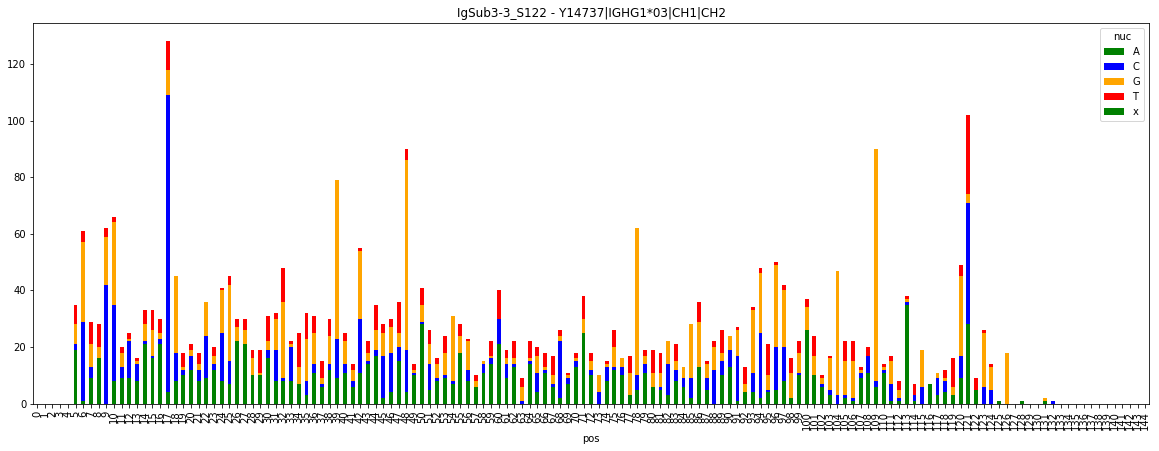

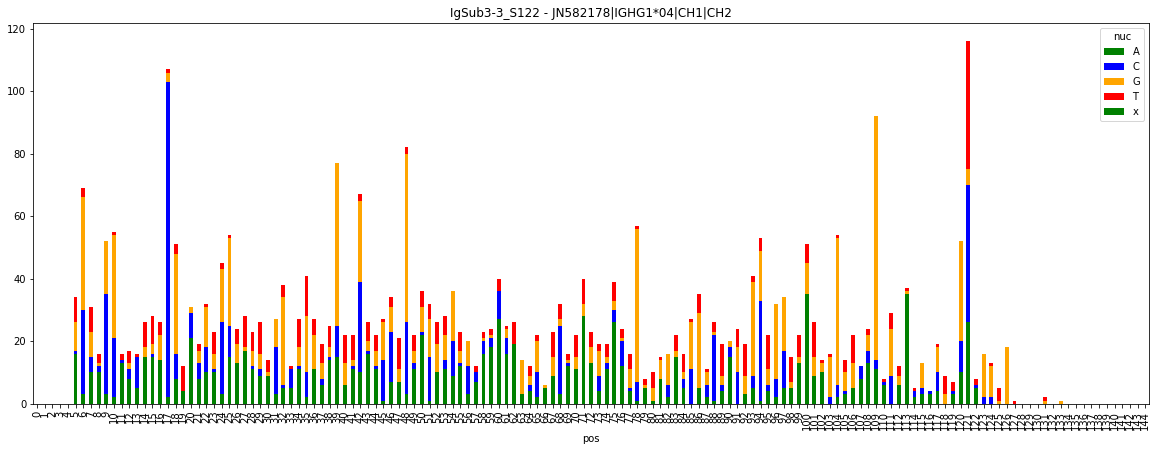

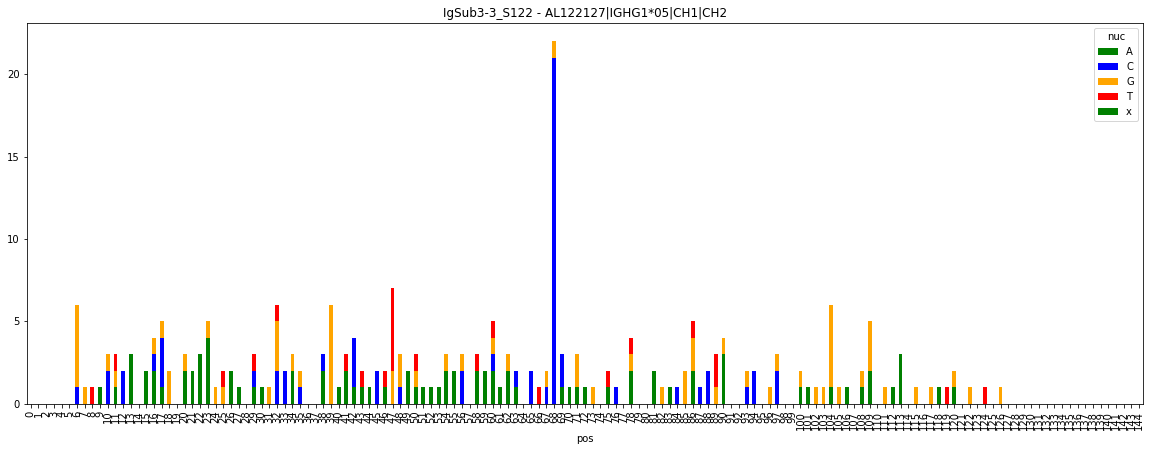

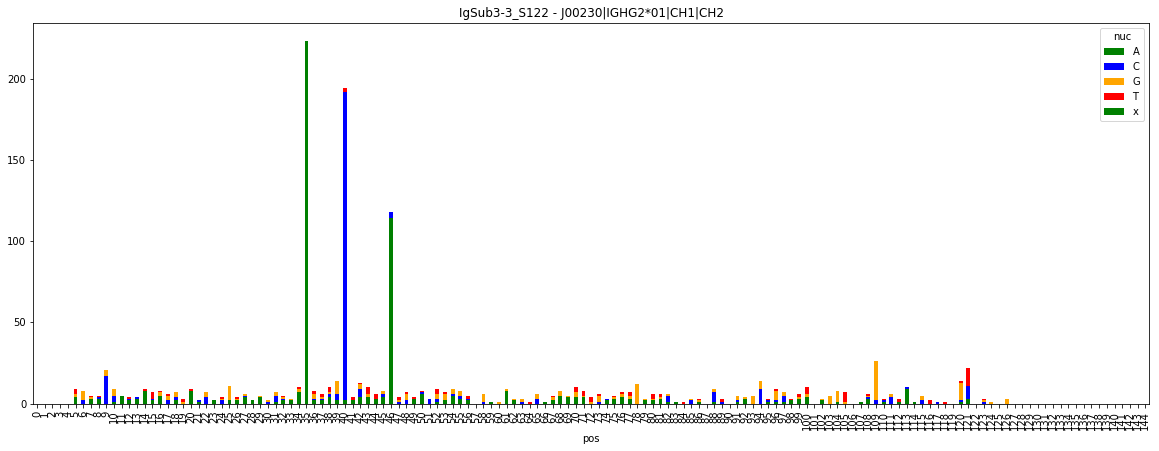

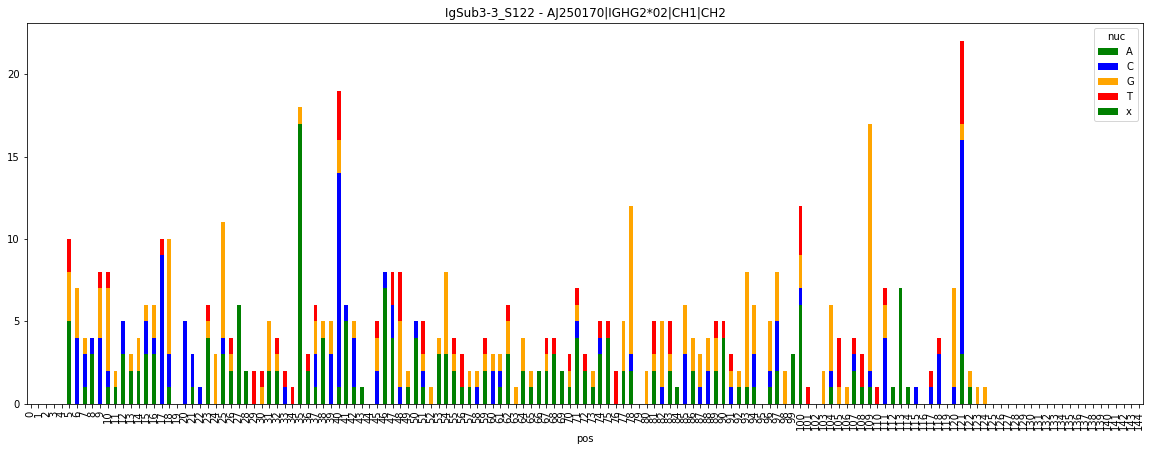

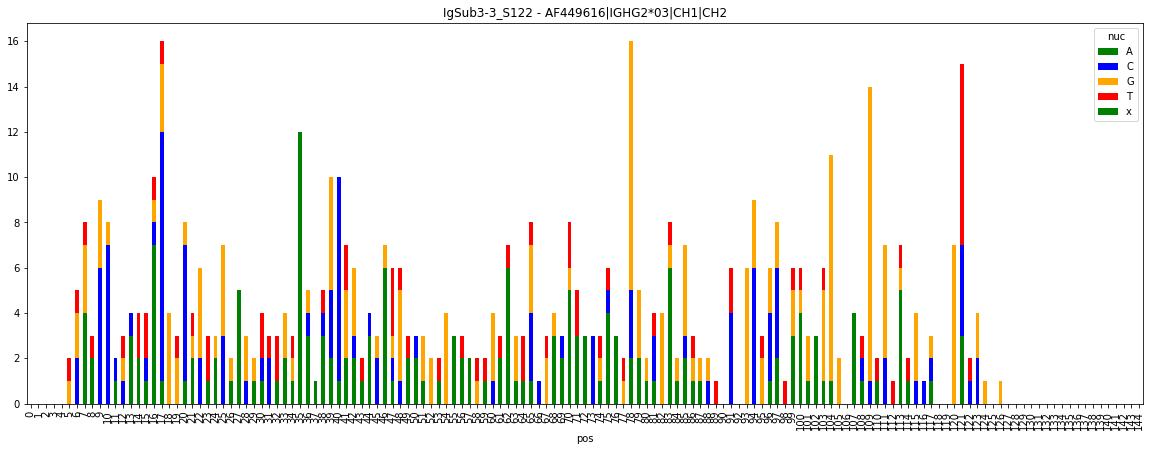

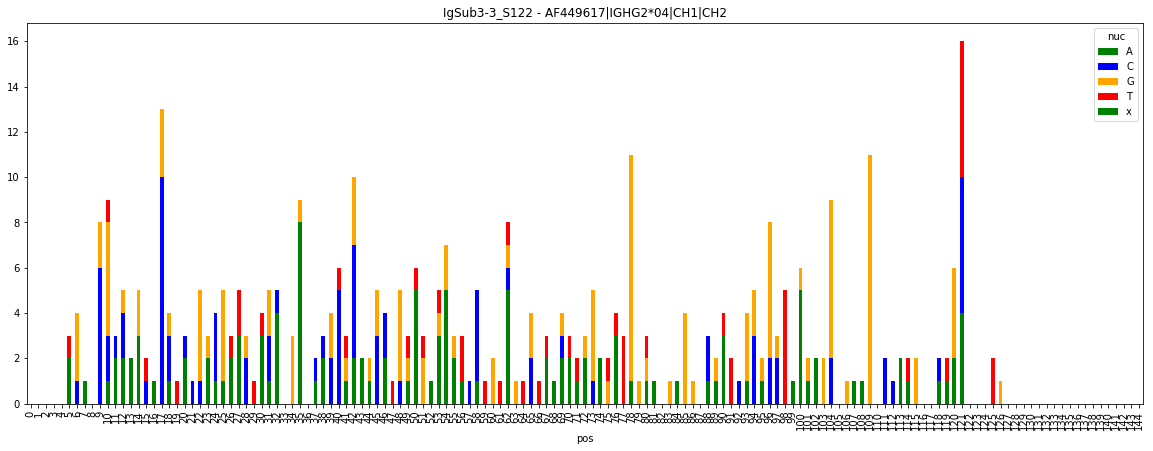

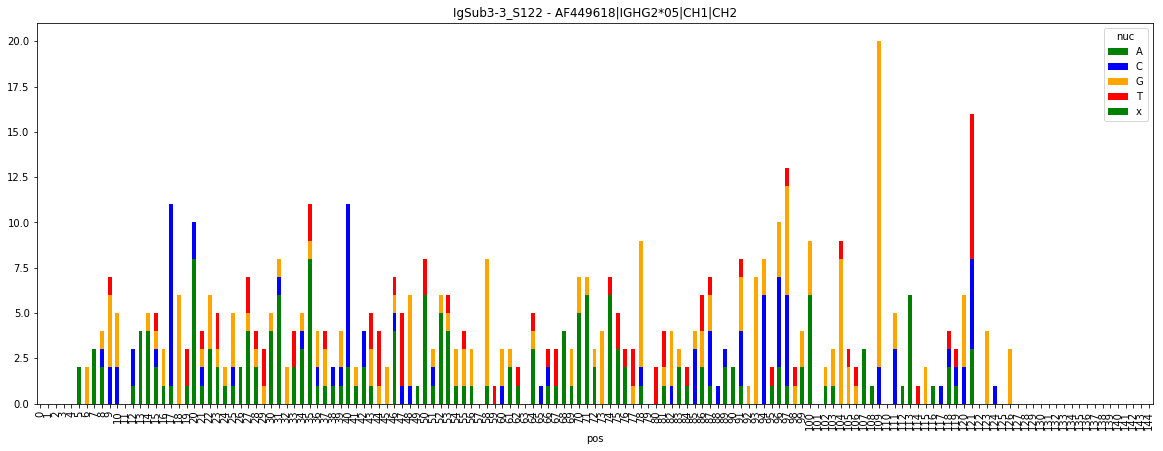

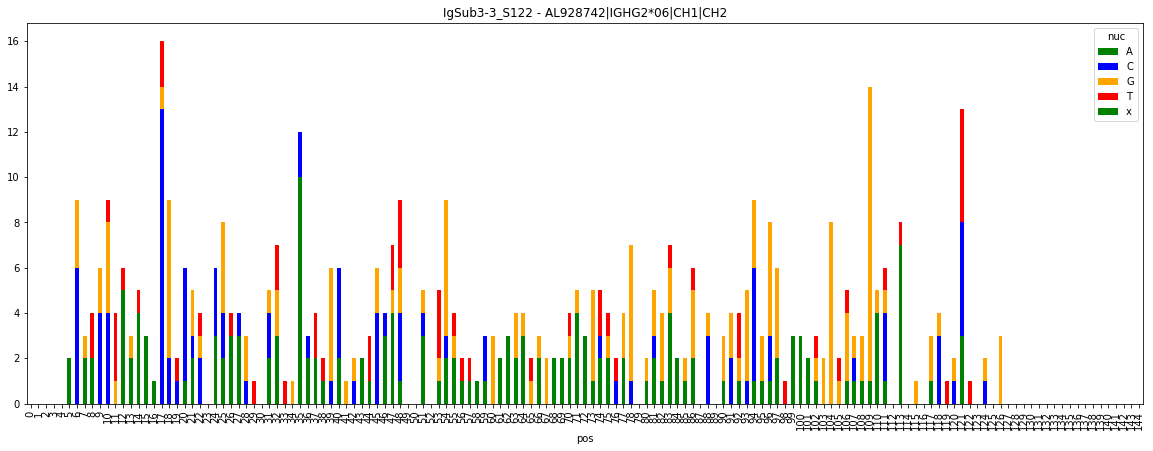

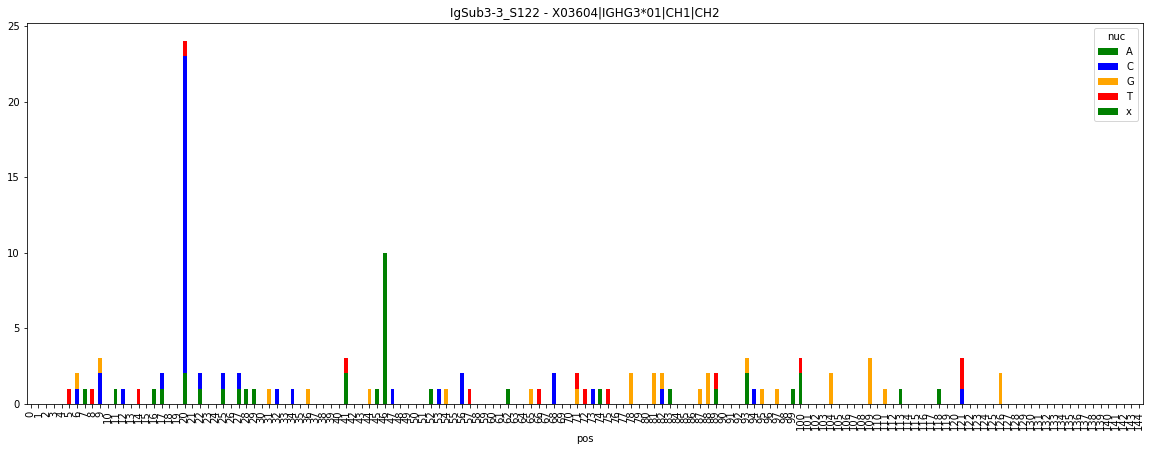

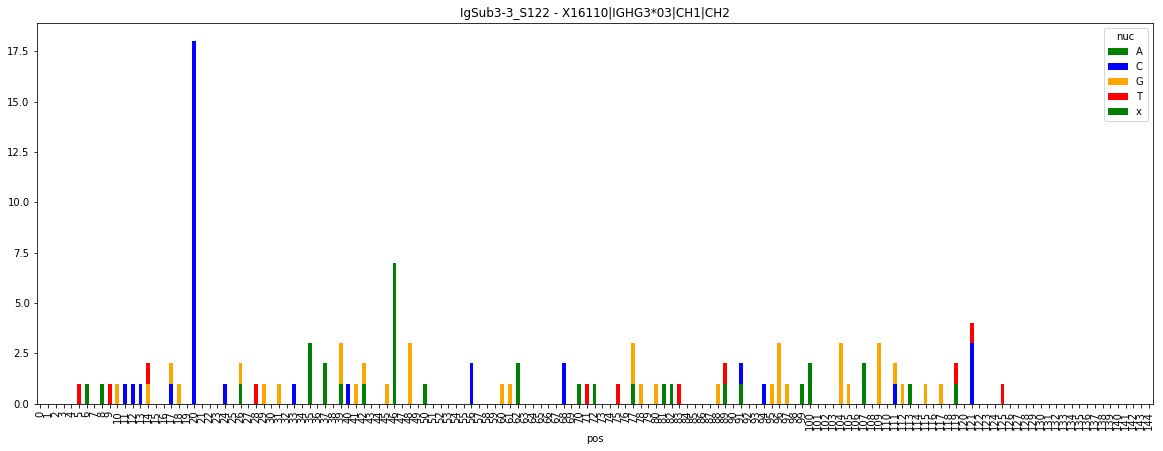

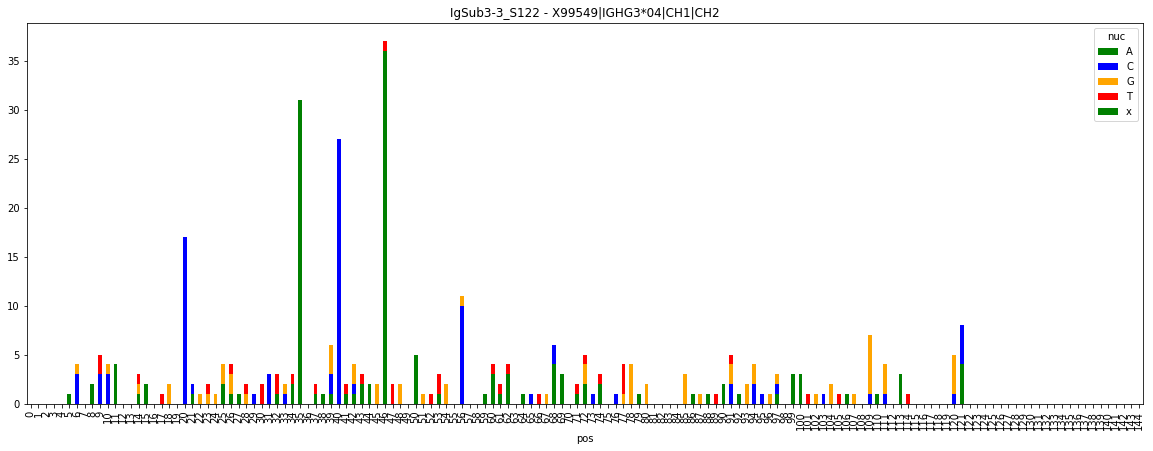

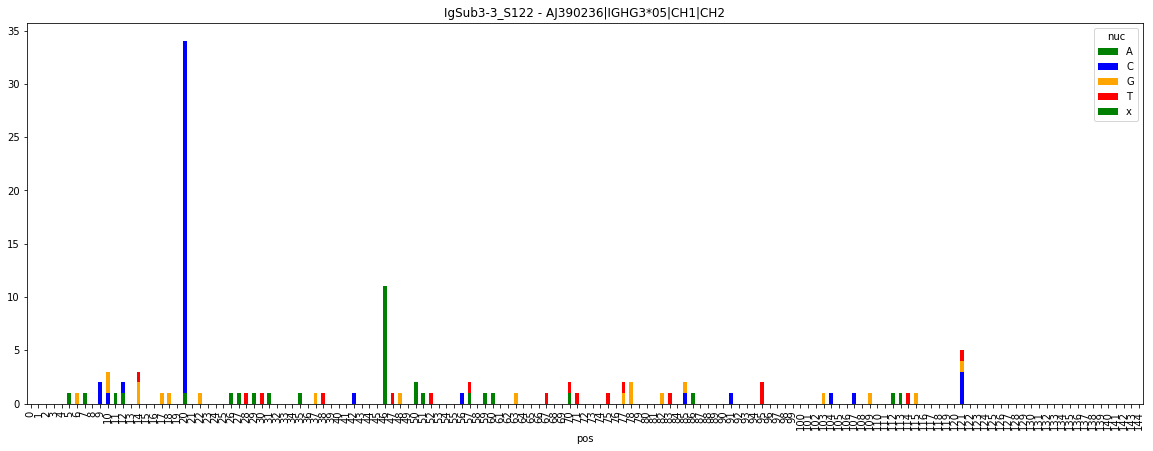

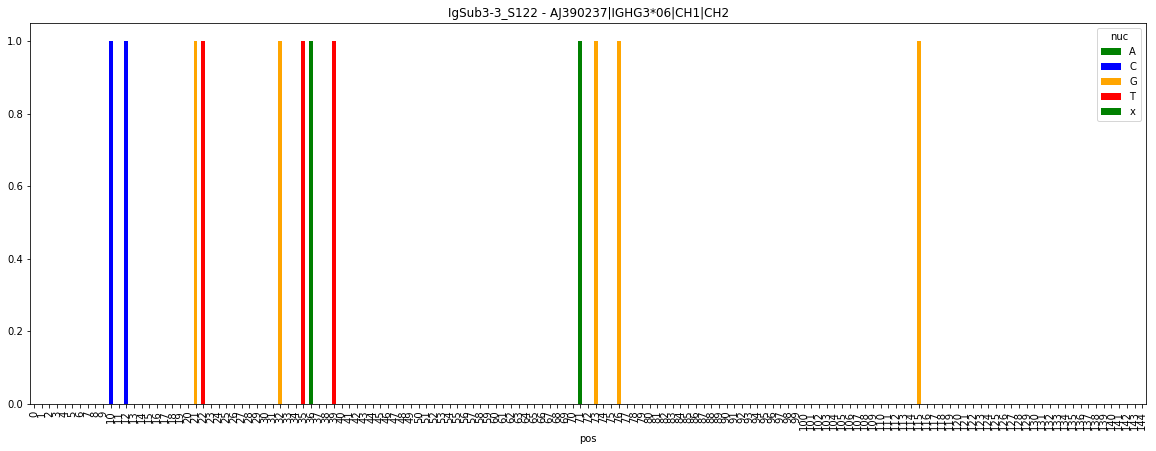

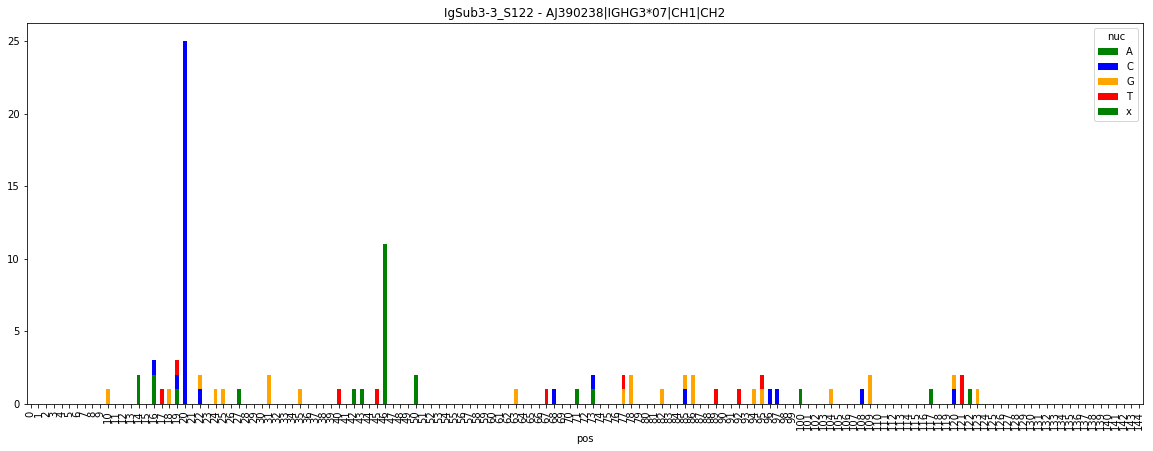

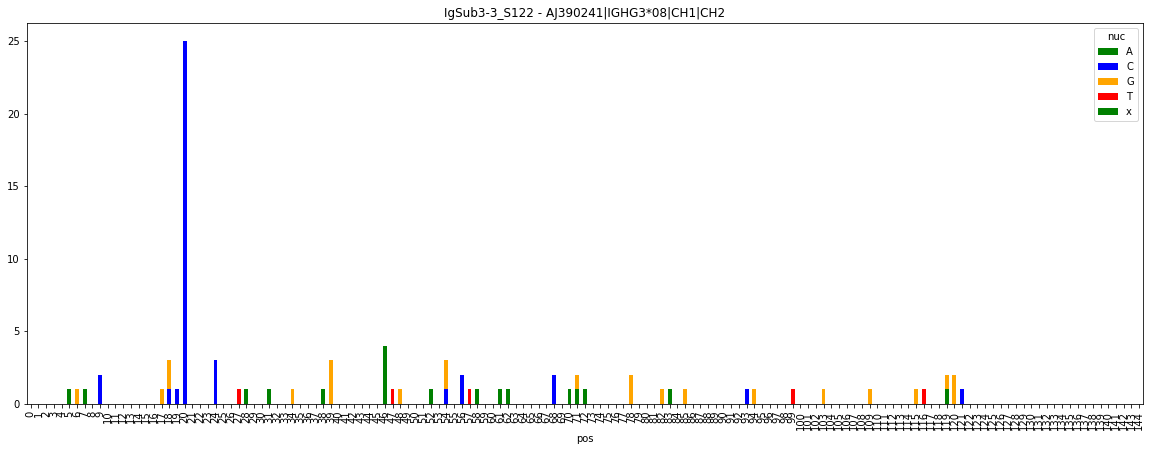

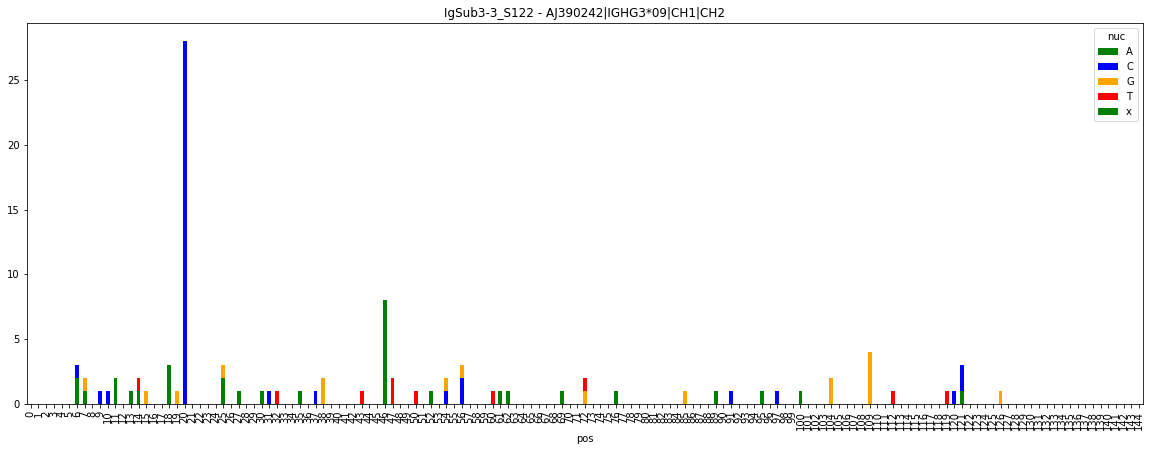

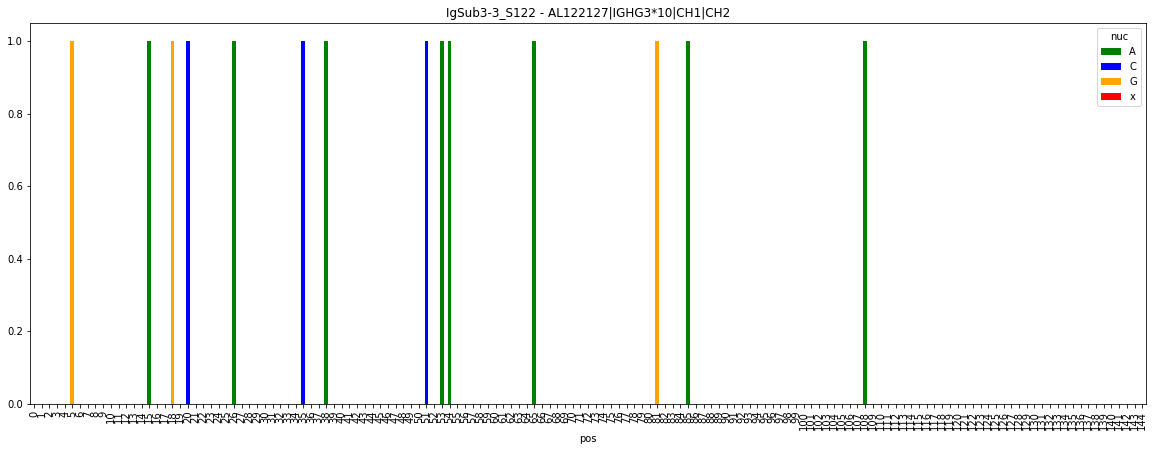

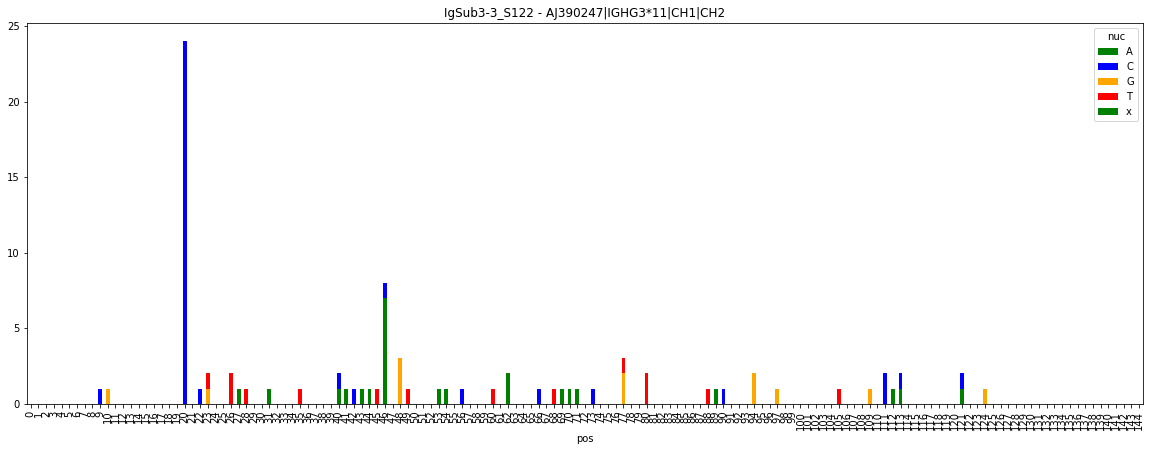

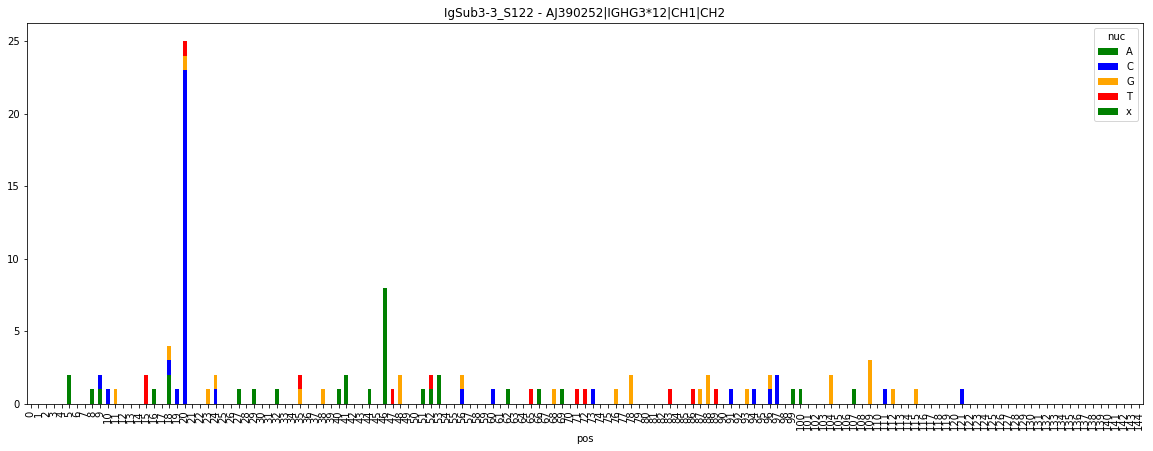

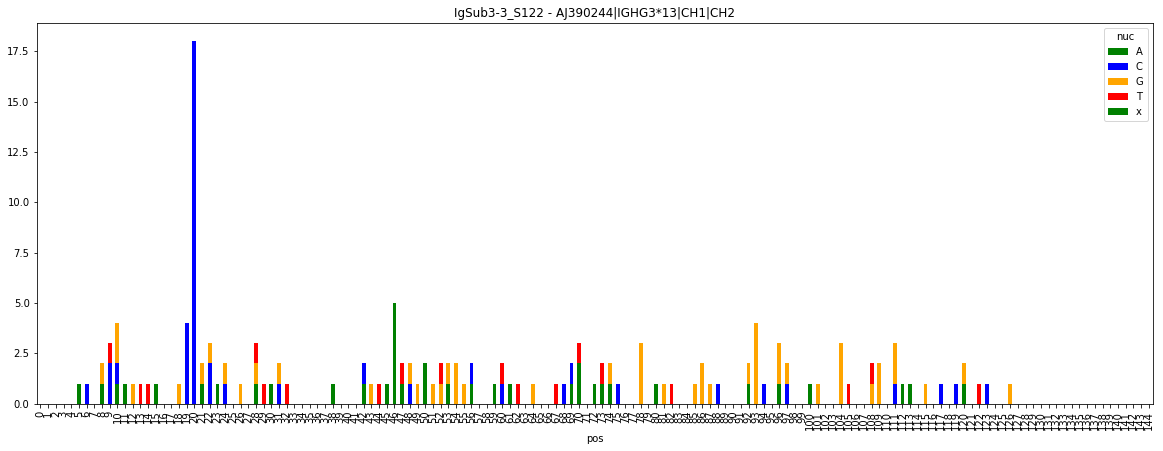

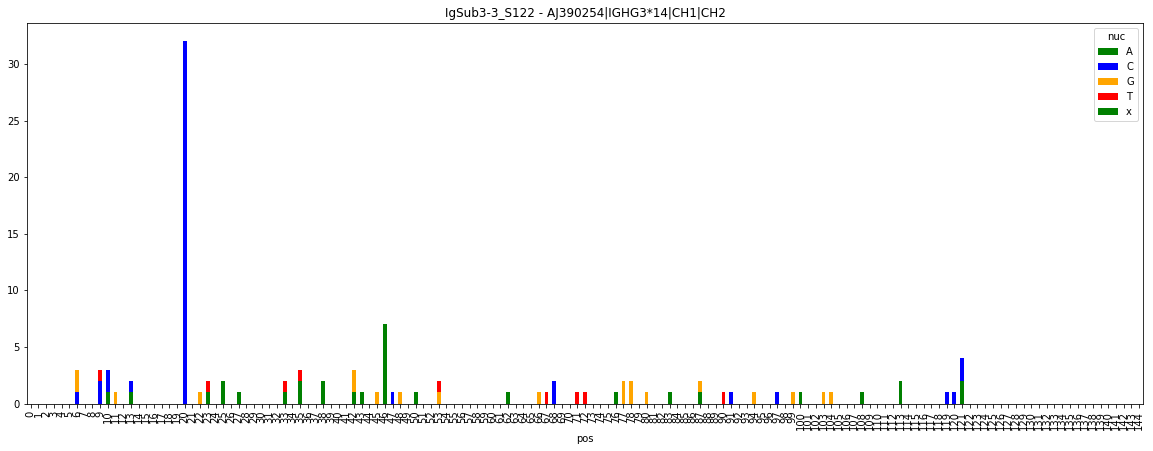

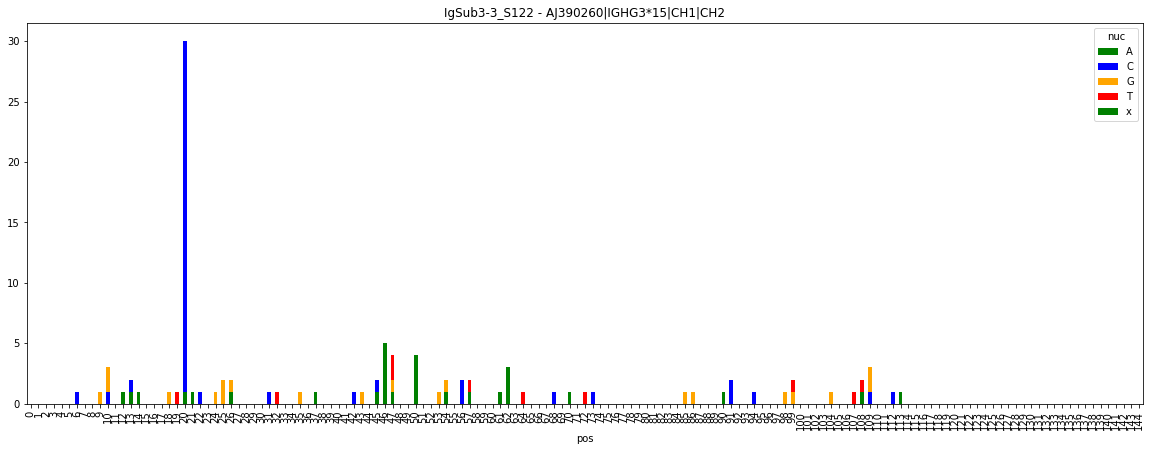

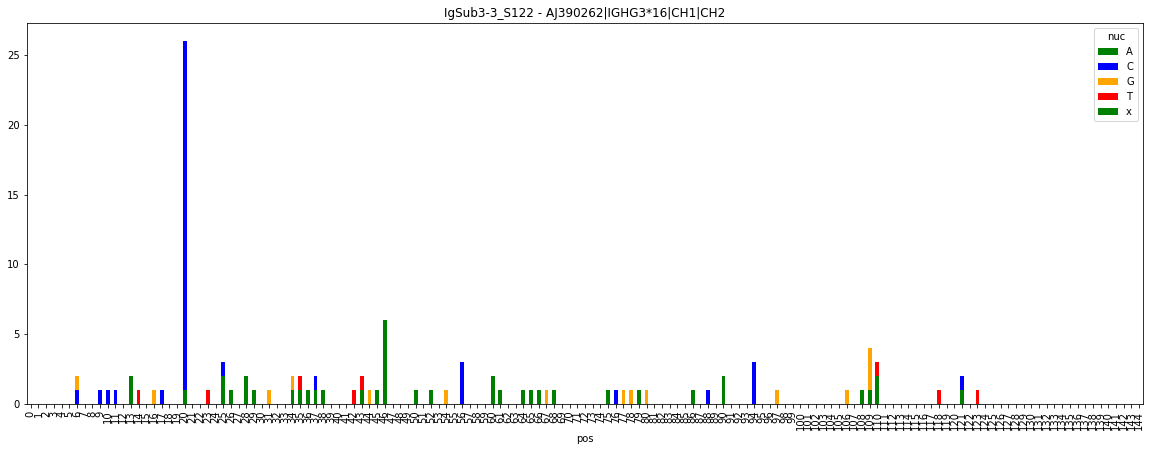

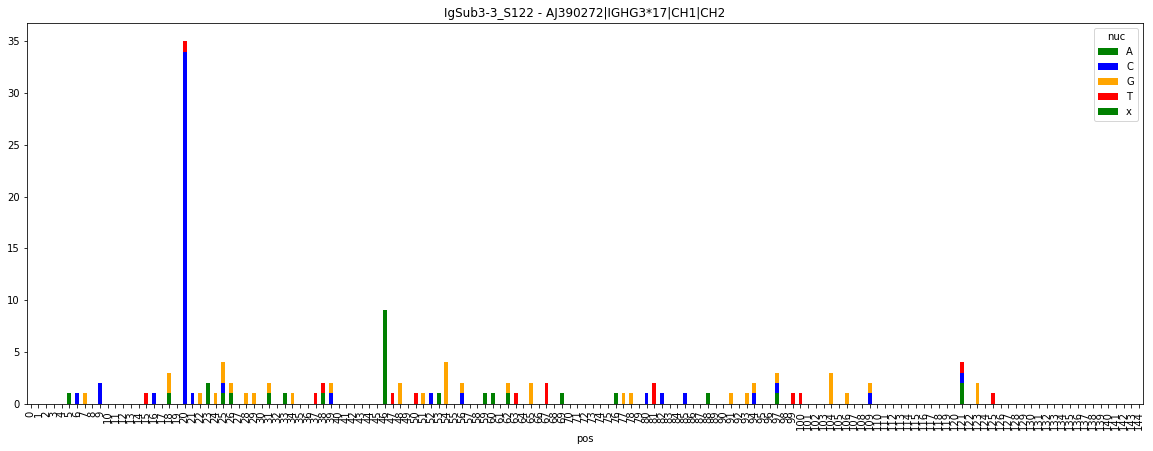

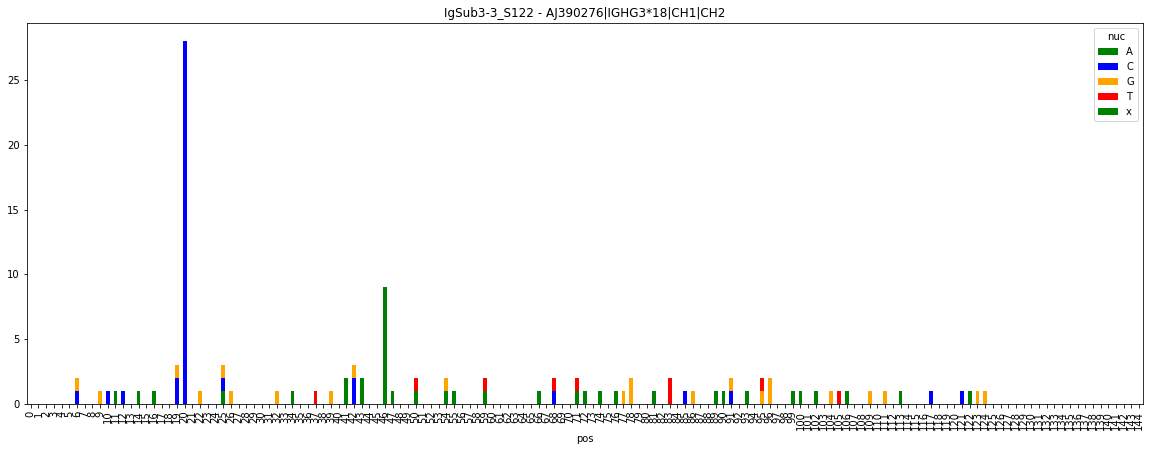

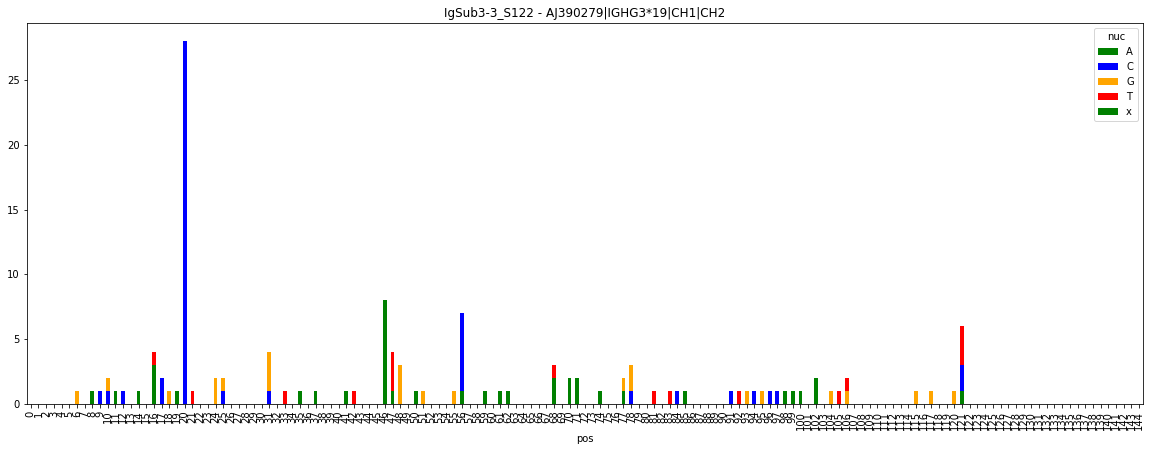

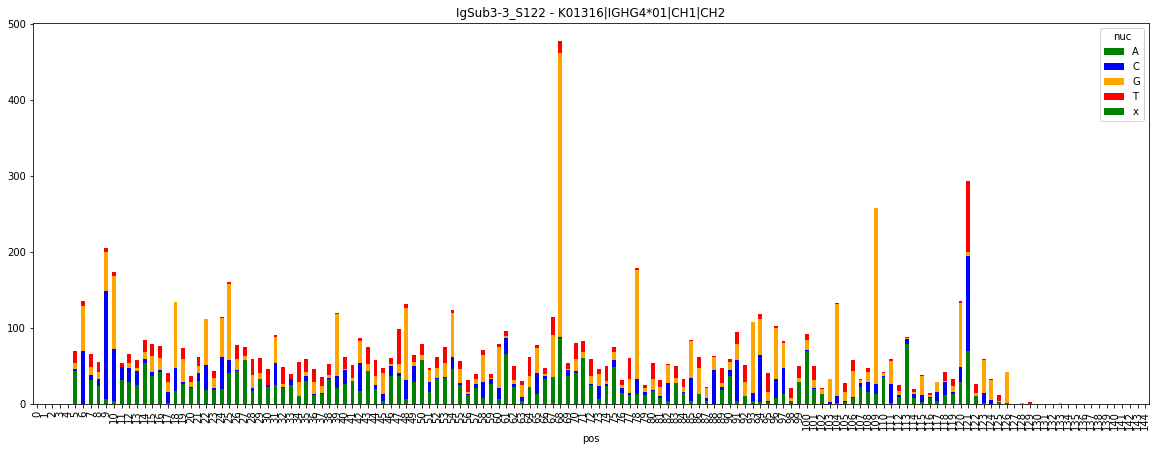

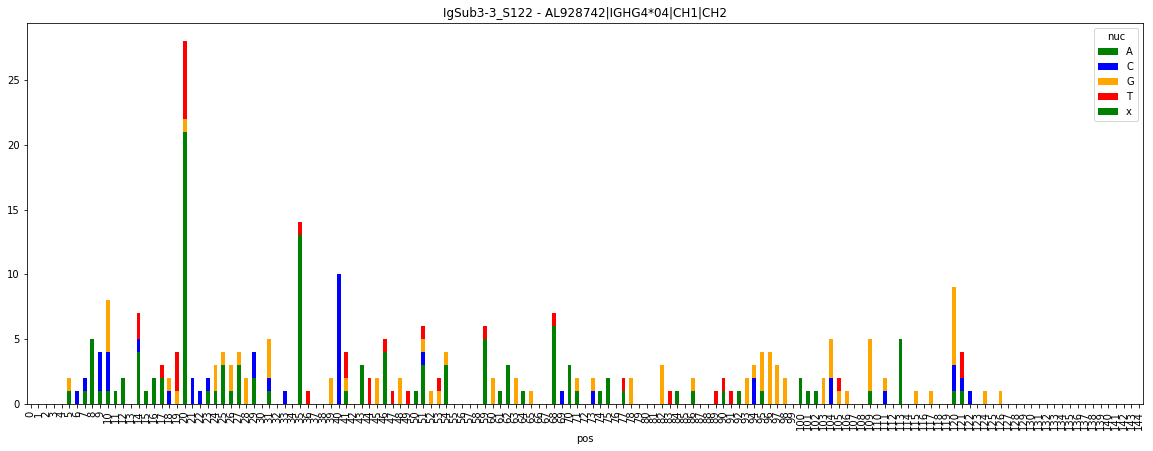

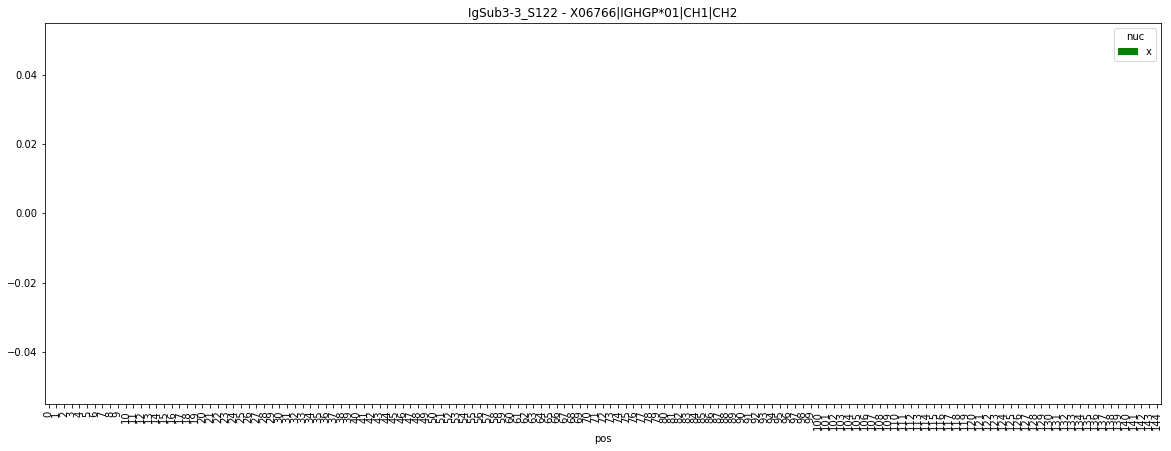

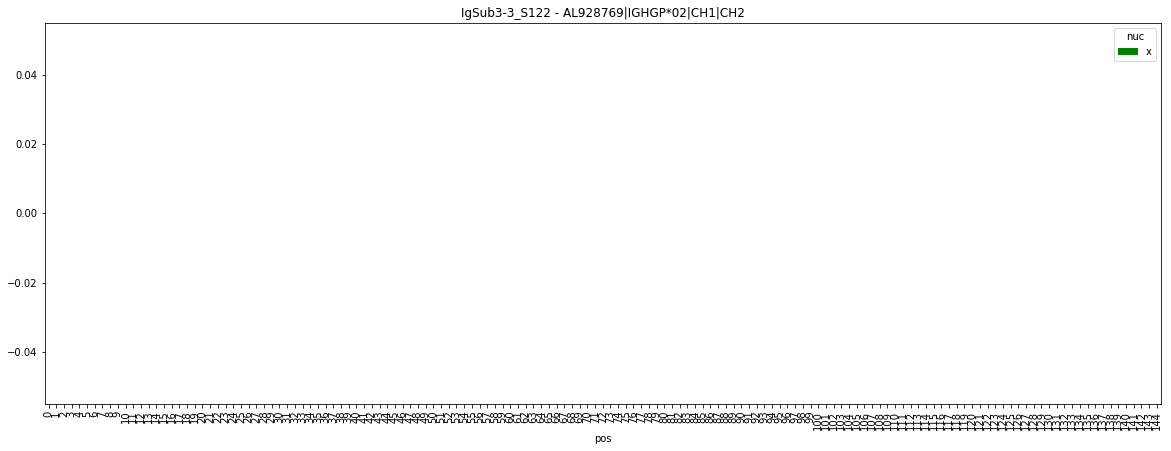

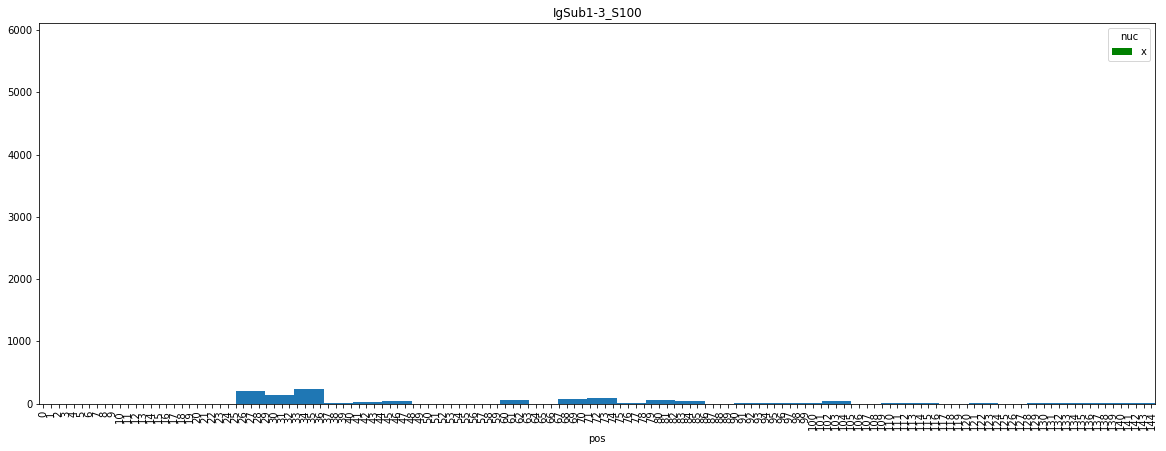

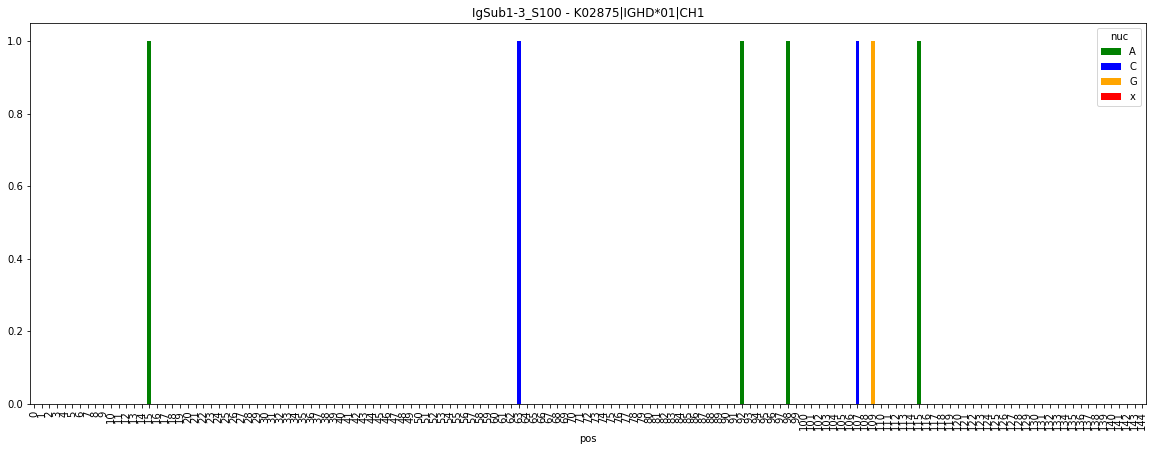

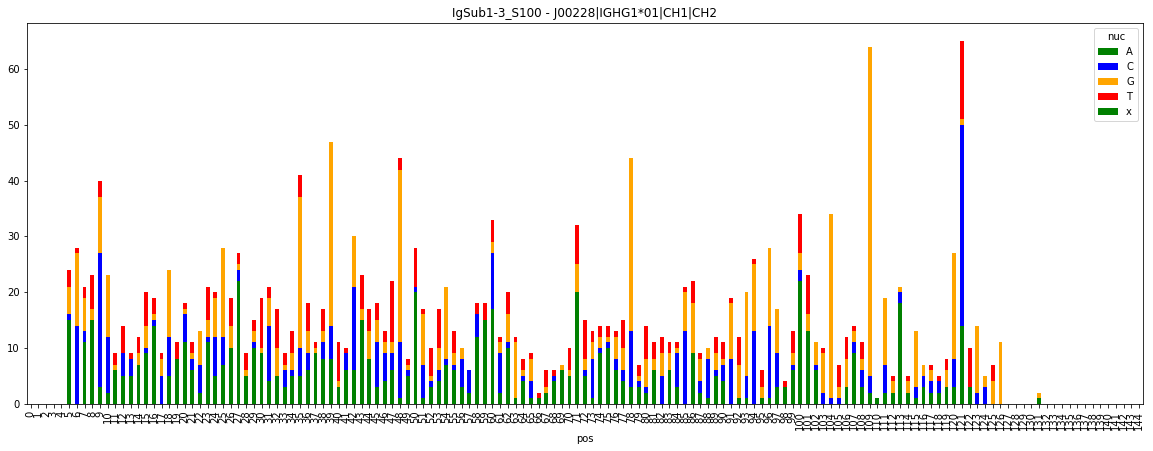

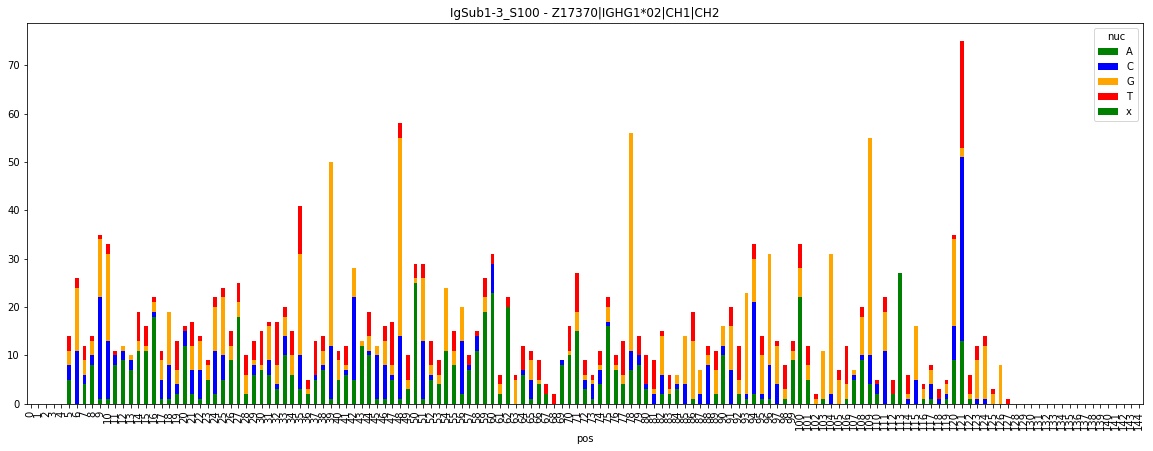

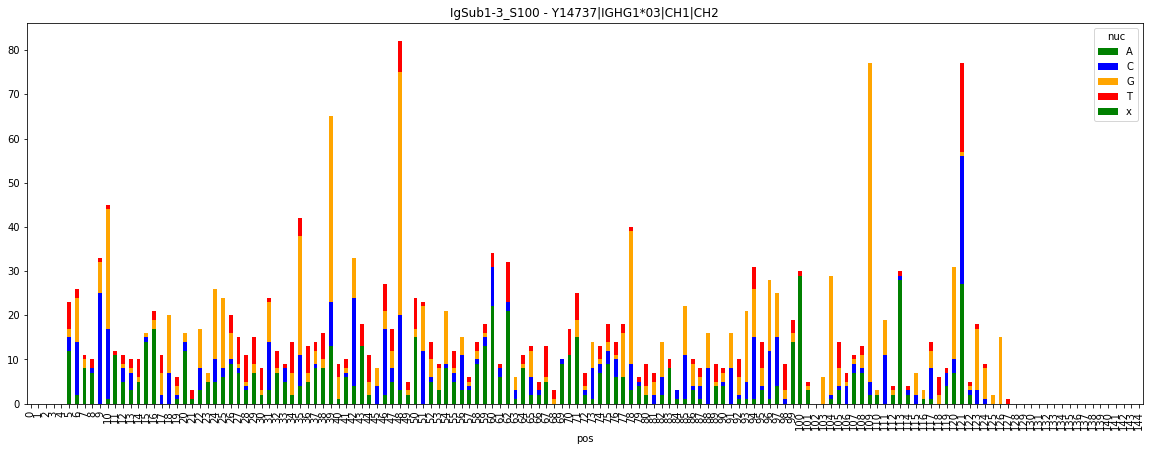

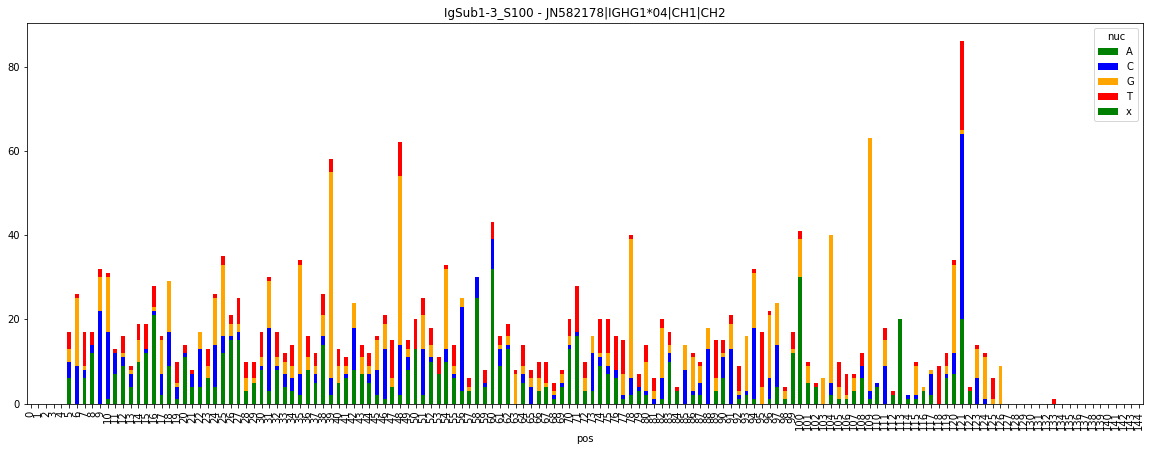

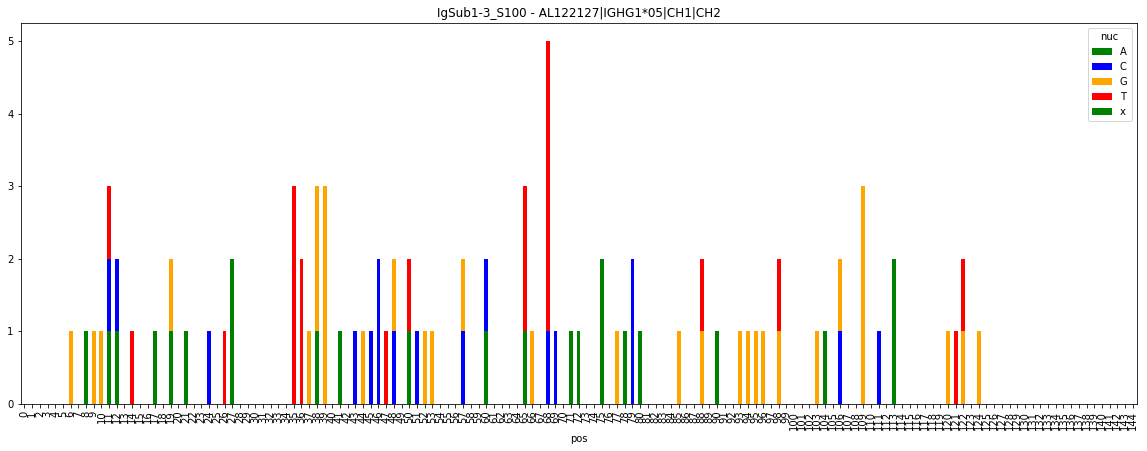

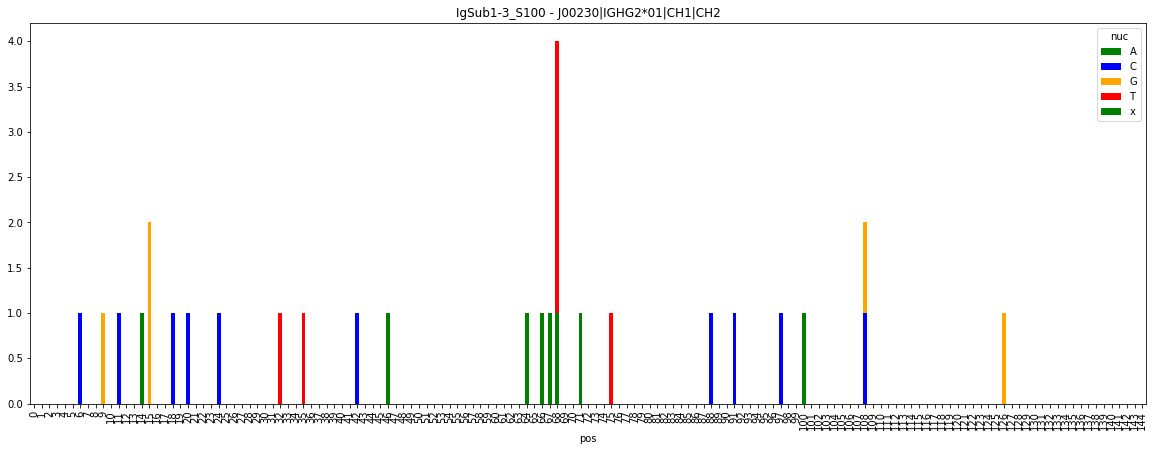

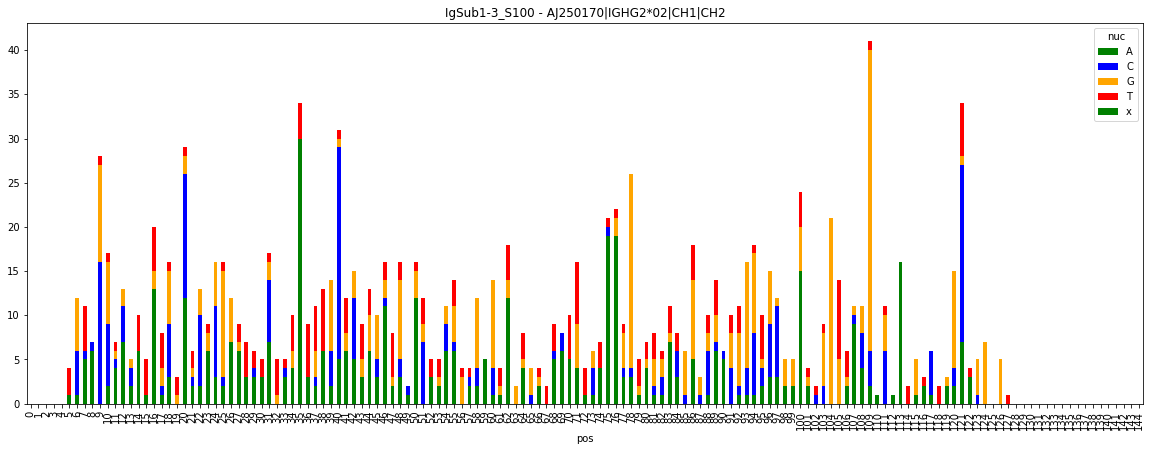

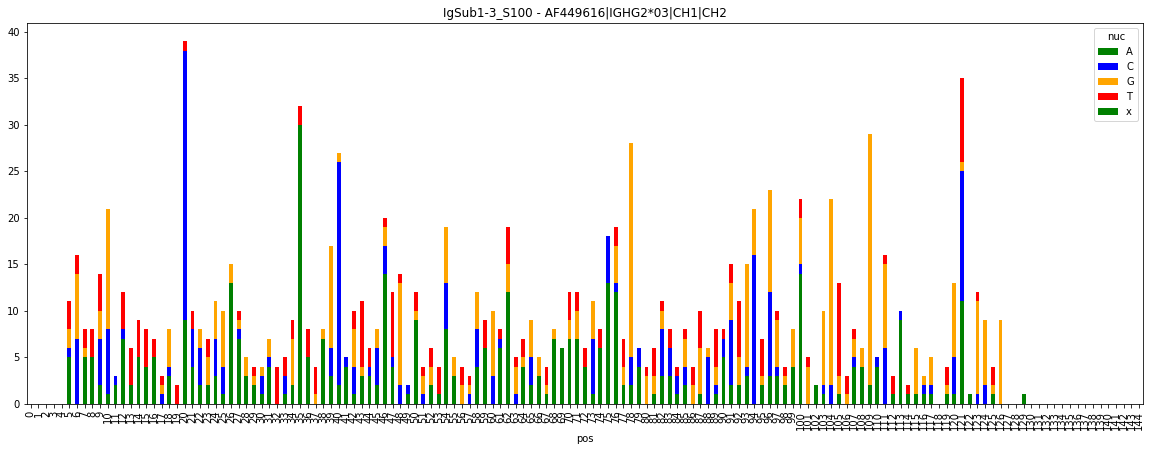

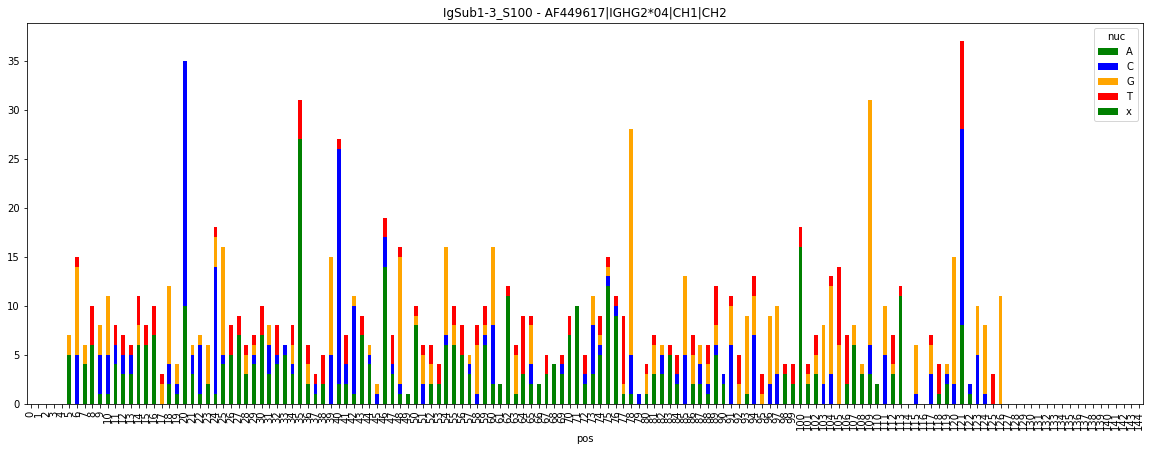

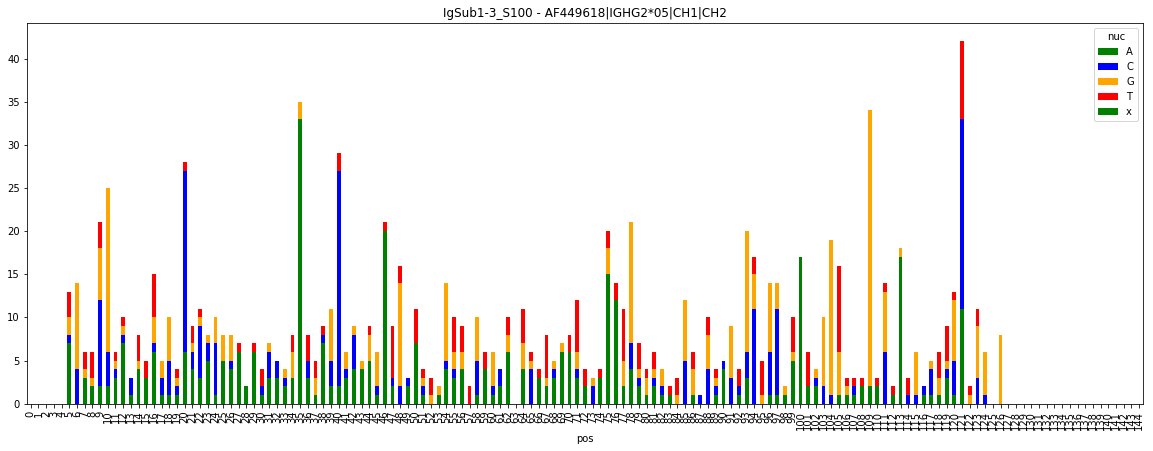

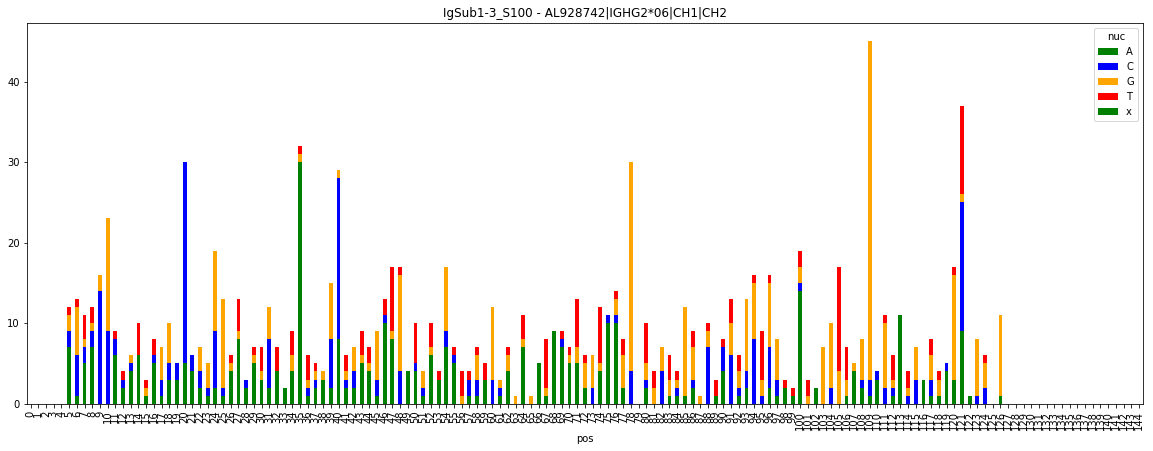

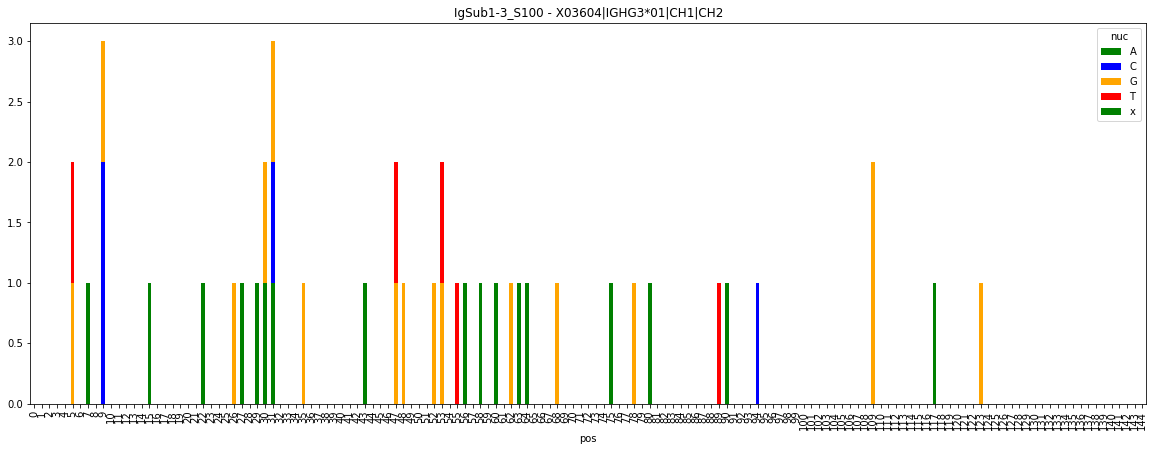

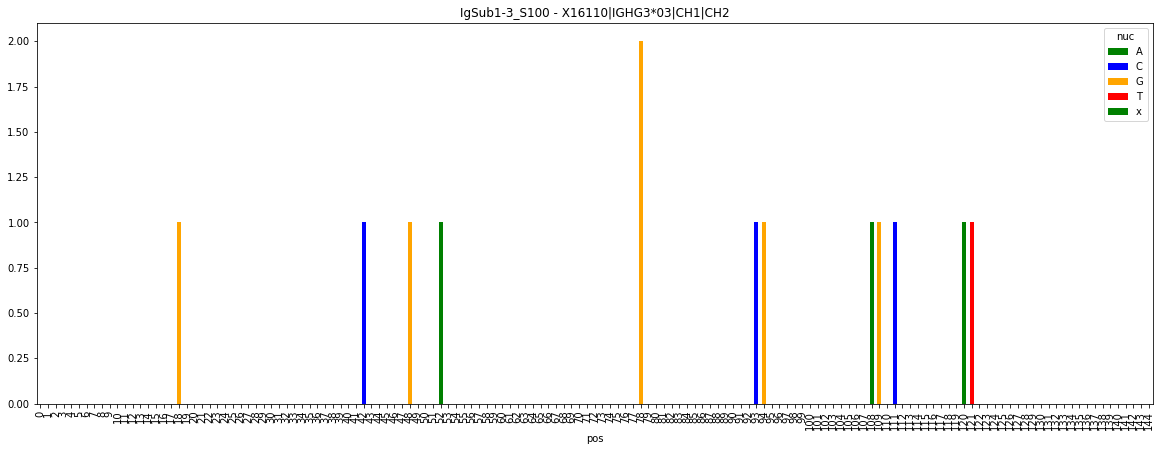

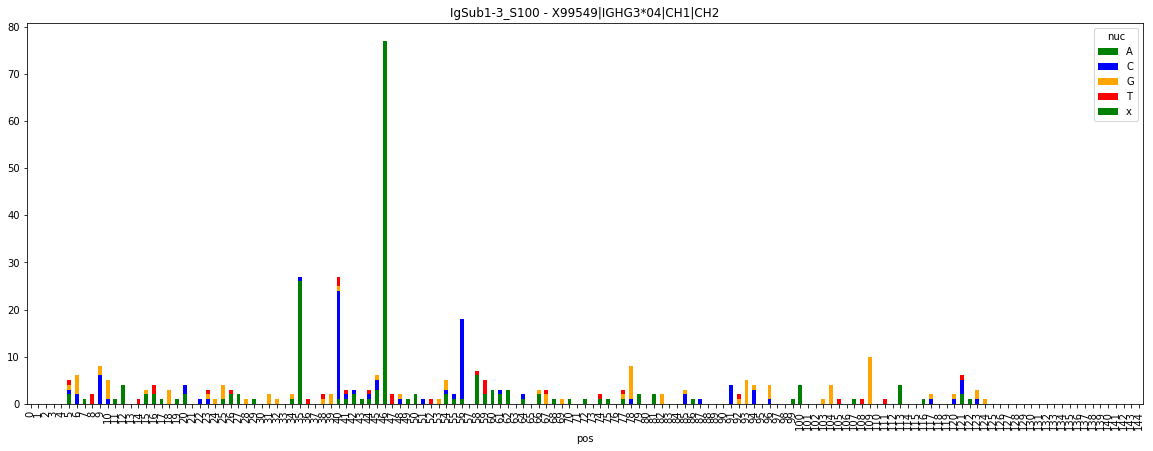

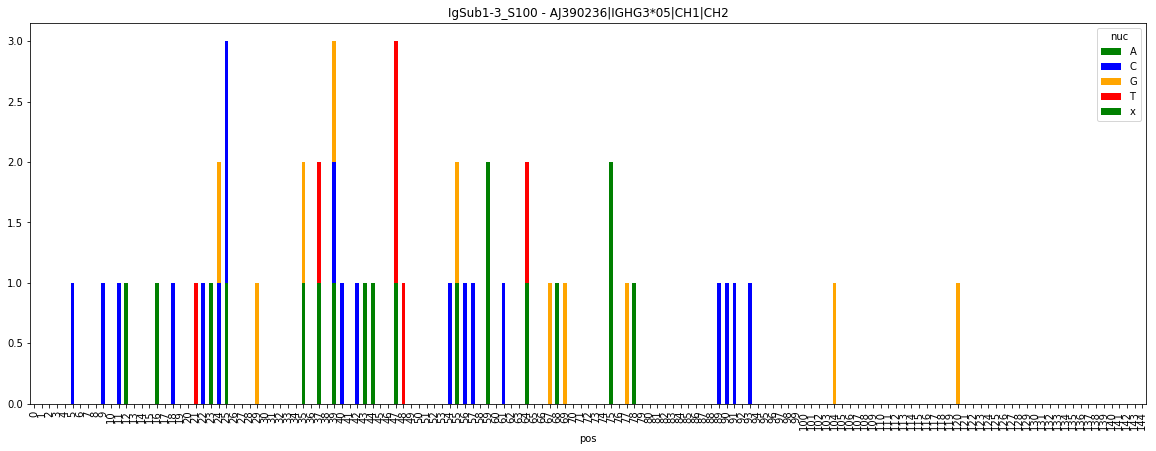

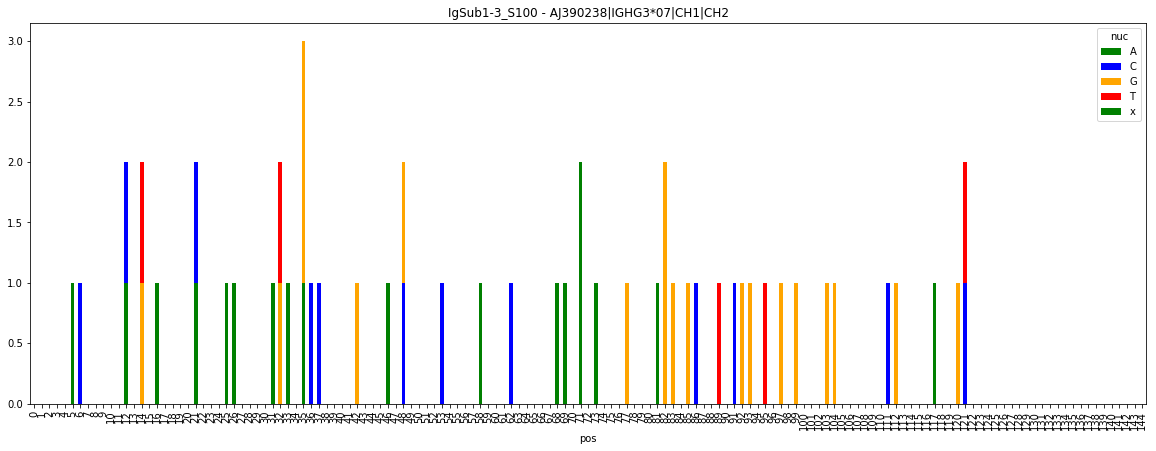

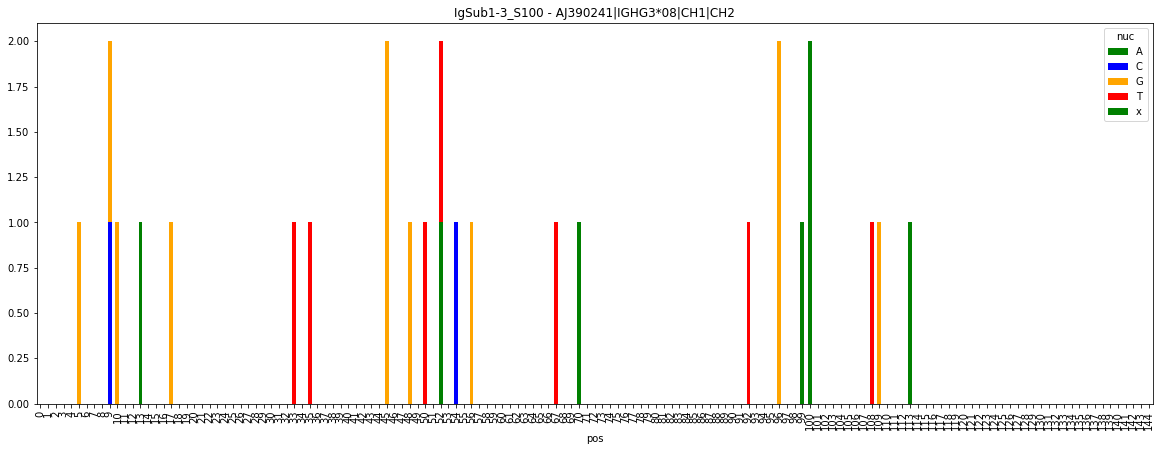

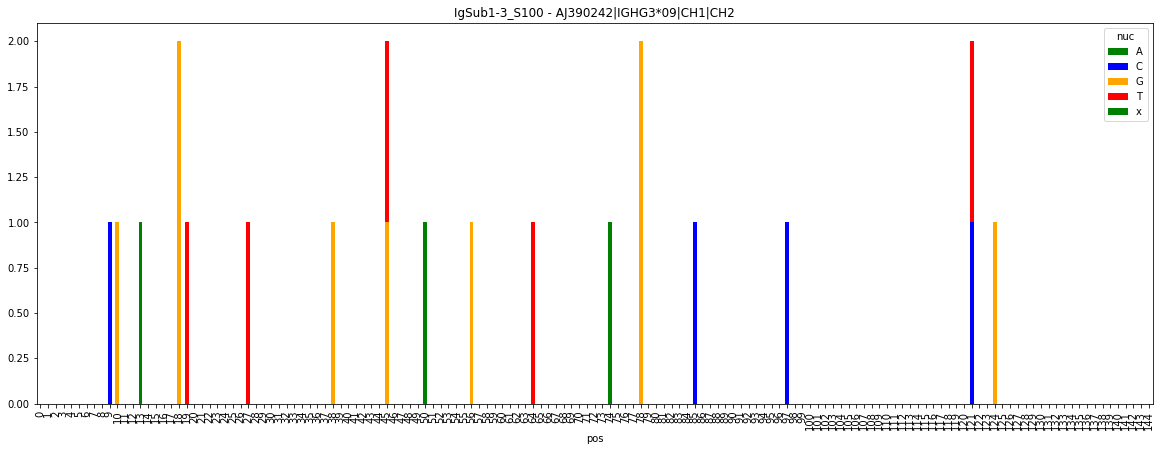

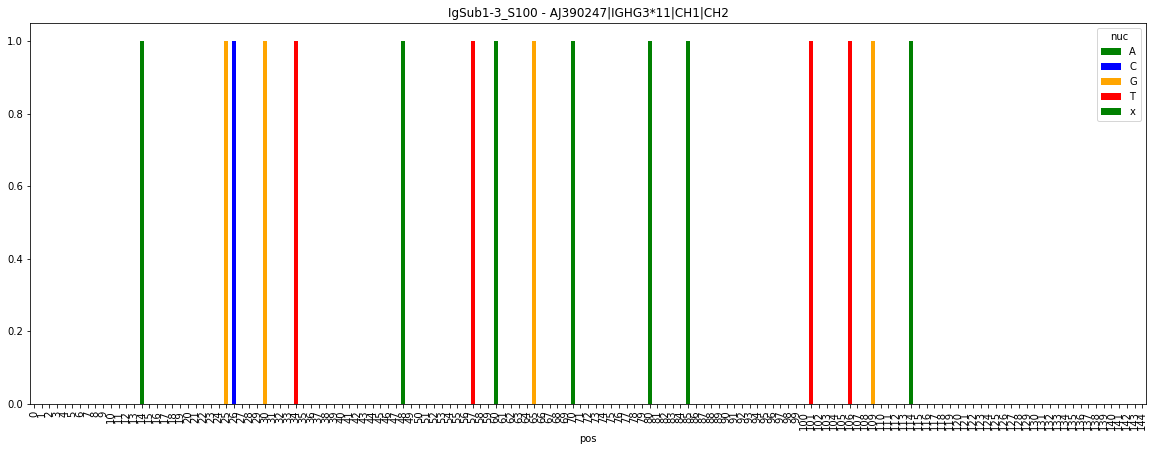

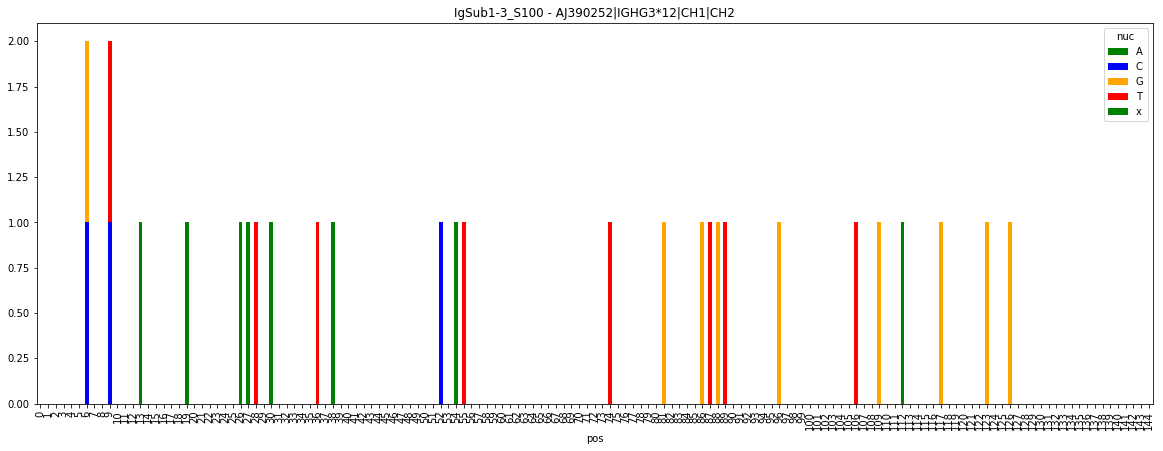

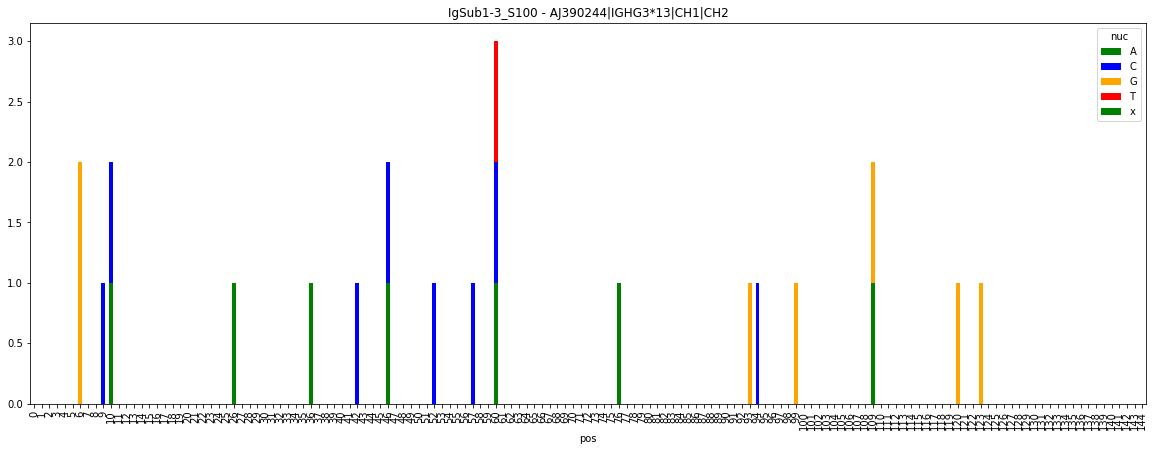

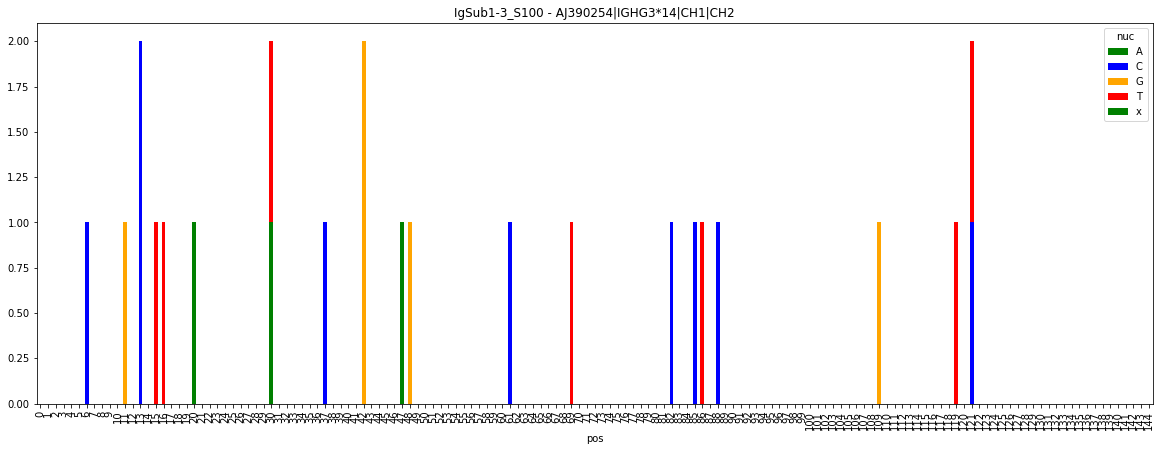

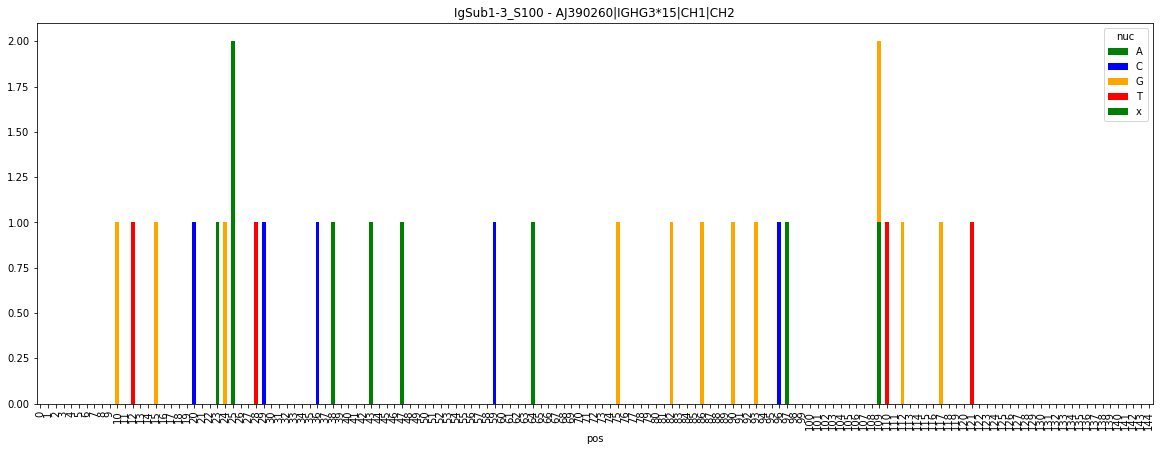

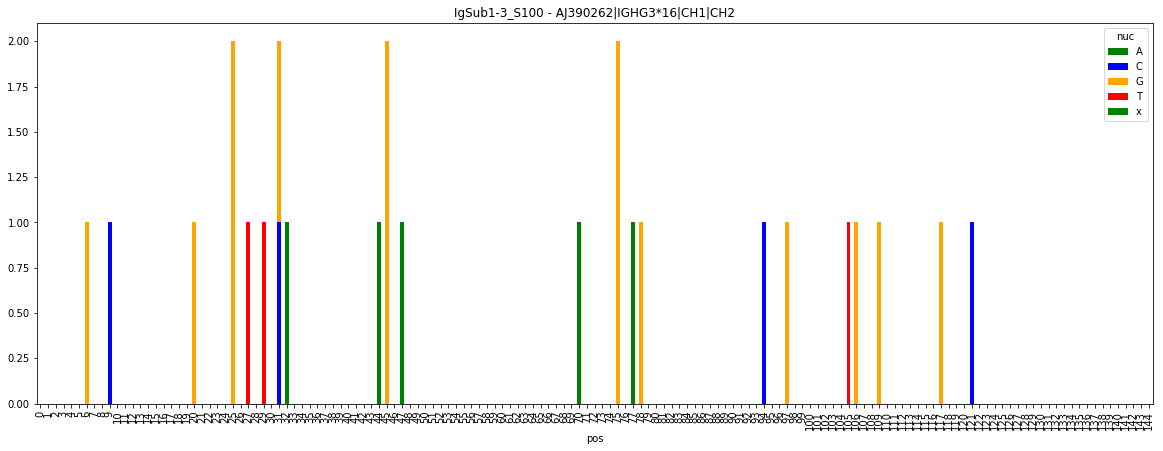

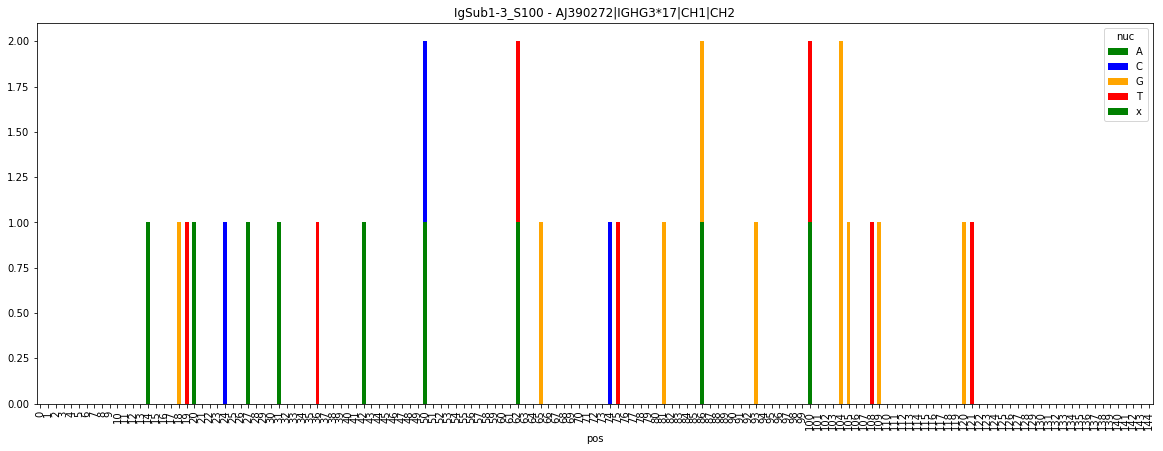

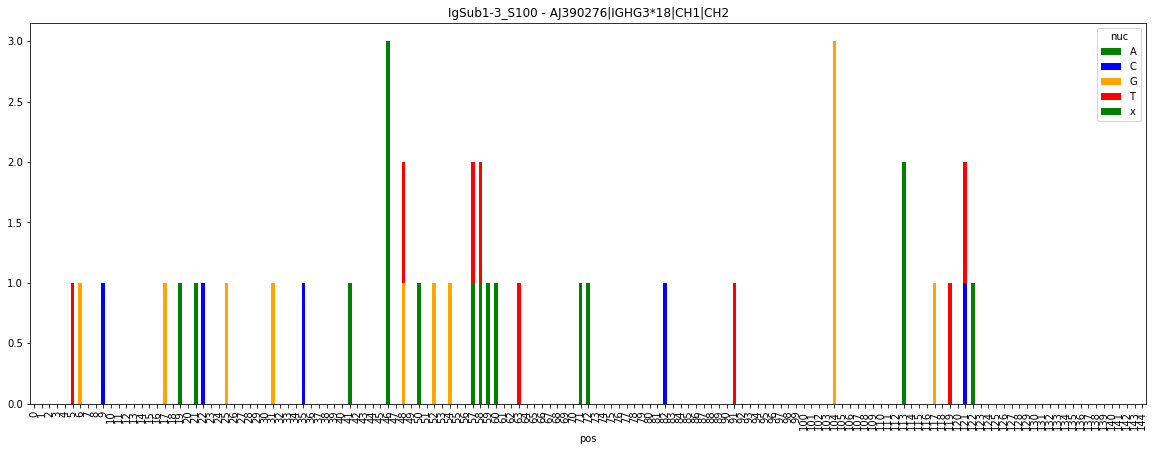

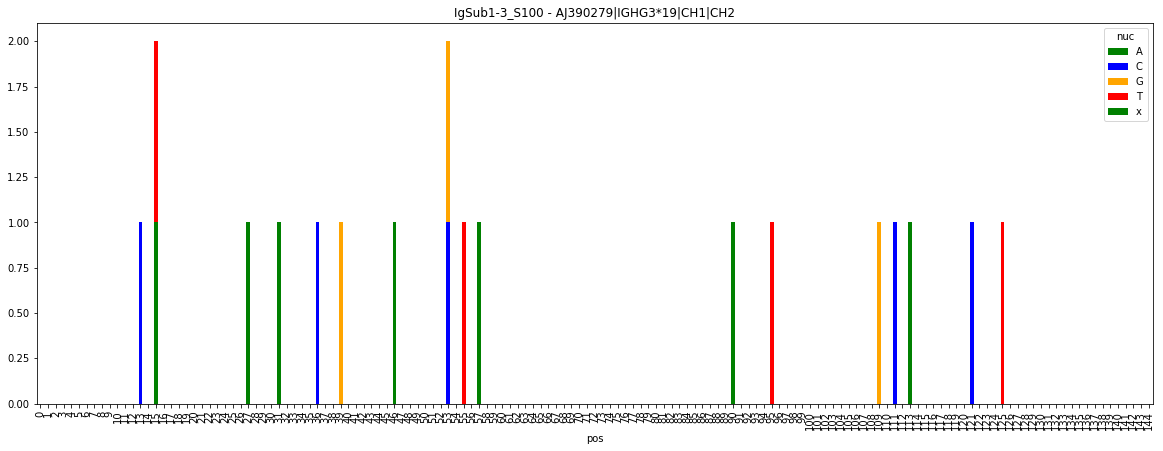

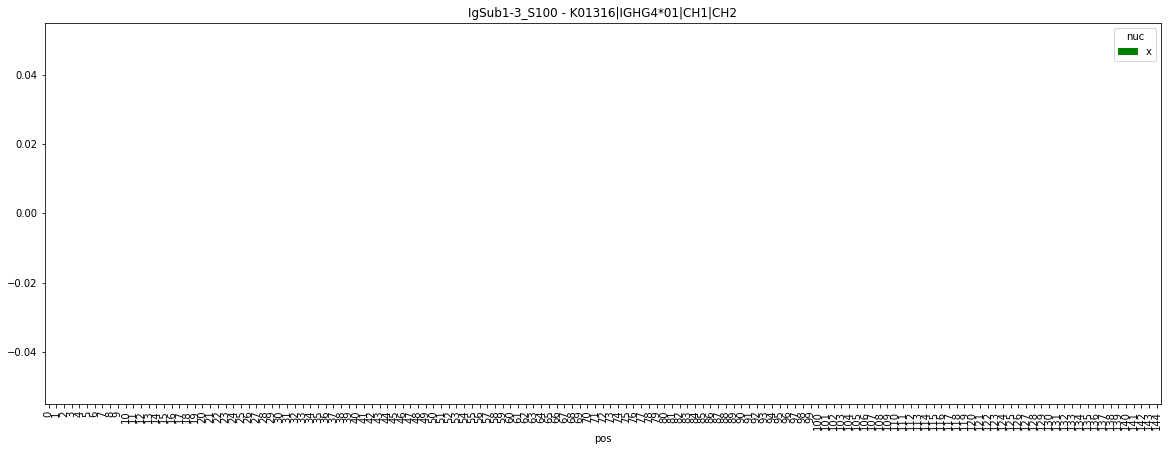

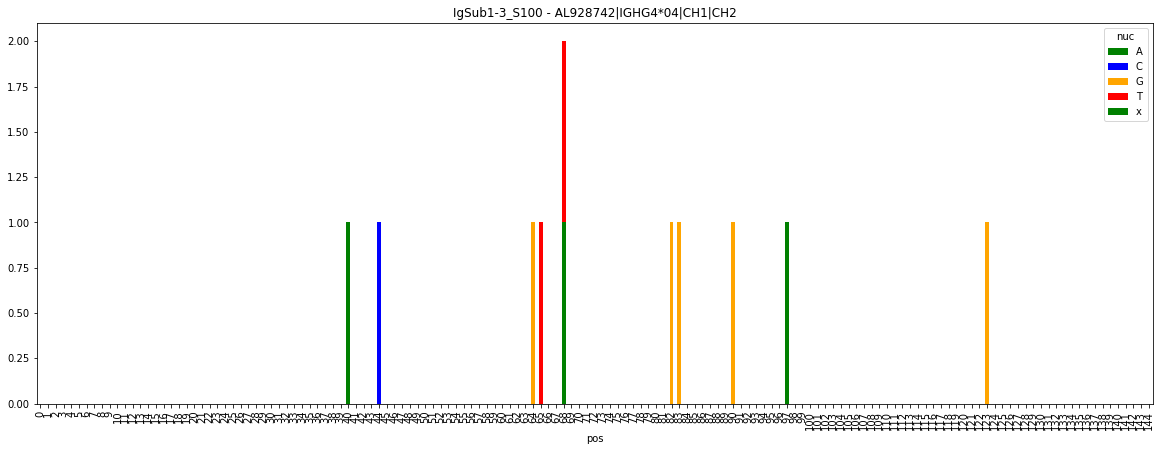

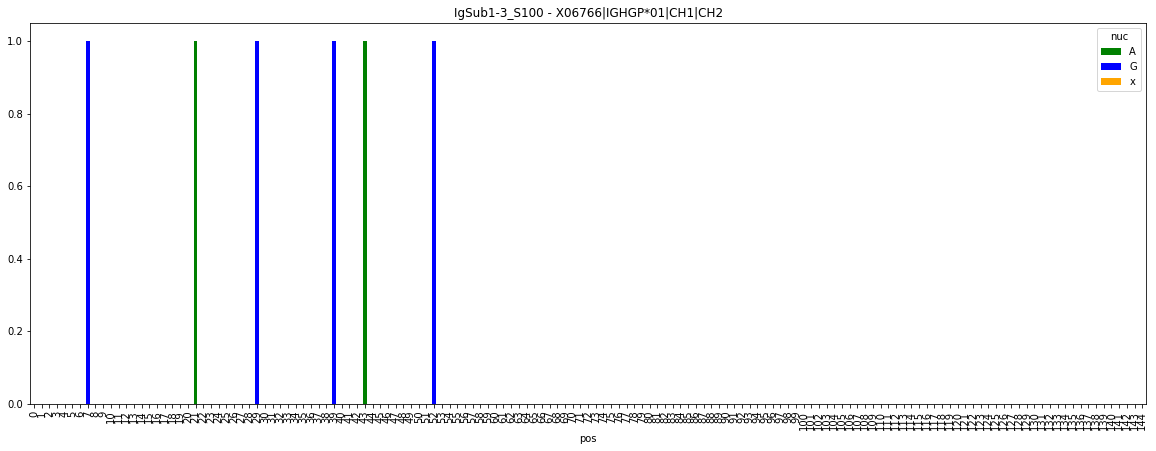

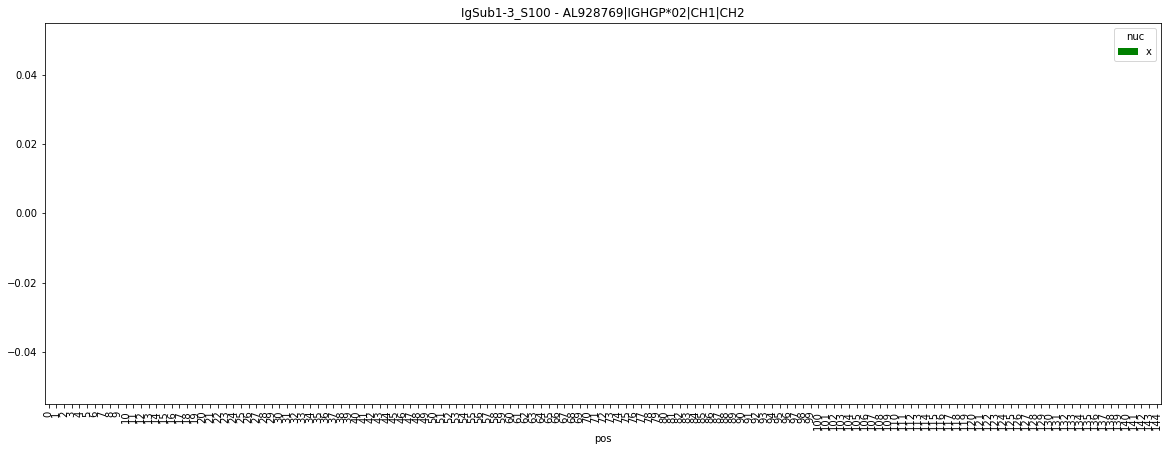

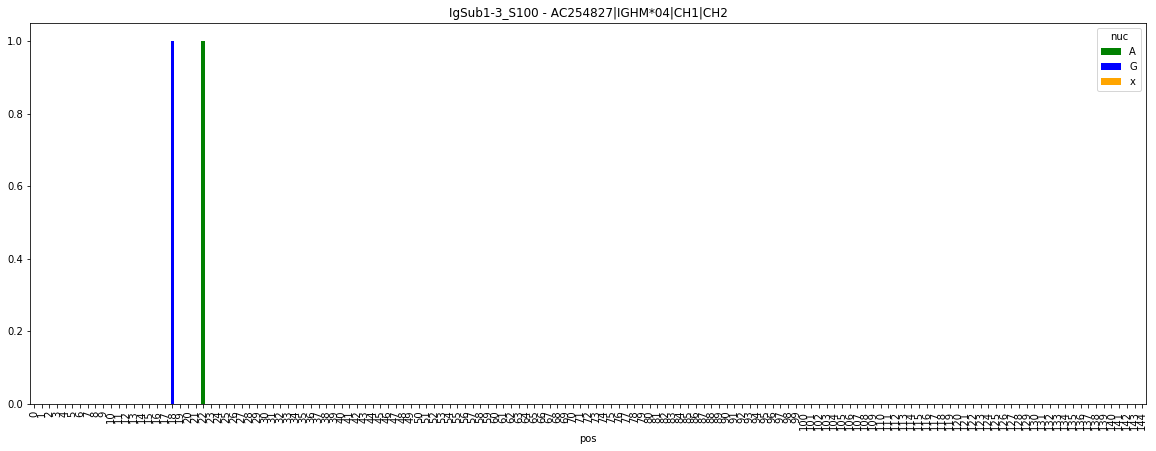

In [18]:
for sample in list(ighc_files.keys()):
    #sample = list(ighc_files.keys())[4]

    print("Sample:", sample)

    # Read sam mutations file
    sam_mut = pd.read_csv(sam_mut_files[sample], sep=" ", na_values=['None', ''])
    plt.hist(sam_mut["start.pos"], bins=100)
    plt.title(sample)
    plt.show()

    # Execute per gene
    mygenes = dict()
    for mygene in set(sam_mut["gene"]):
        gene_name = mygene.split("|")[1]
        mygenes[gene_name] = mygene

    all_variants = pd.DataFrame(columns=["pos", "nuc", "counts", "gene"])
    for name in sorted(mygenes):
        mygene = mygenes[name]
        variants = plotVariants(sam_mut, mygene, sample)
        variants["gene"] = name
        all_variants = all_variants.append(variants)
    all_variants.to_csv(sample + "-variants.csv")